In [1]:
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt

## Boilerplate

In [2]:
path = "./receptive_field_experiments"
if not os.path.exists(path):
    os.mkdir(path)

In [3]:
from matplotlib import rc

params = {
#           'text.latex.preamble': [r'\usepackage{gensymb}'],
          'axes.labelsize': 18, # fontsize for x and y labels (was 10)
          'axes.titlesize': 18,
          'font.size': 16, # was 10
          'legend.fontsize': 16, # was 10
          'xtick.labelsize': 14,
          'ytick.labelsize': 14,
          'font.family': 'serif',
          'figure.dpi': 300
}
#mpl.rcParams['figure.dpi'] = 900
import matplotlib
matplotlib.rcParams.update(params)
#rc('text', usetex=True)

In [4]:
receptive_fields = {
    'VGG13': './receptive_field/VGG13.csv',
    'VGG13_D2': './receptive_field/VGG13_D2.csv',
    'VGG13_D4': './receptive_field/VGG13_D4.csv',
}

resolutions = {
    'Cifar10': 32,
    'Cifar10_132': 132,
    'Cifar10_140': 140,
    'Cifar10_150': 150,
    'Cifar10_75': 75,
    'Cifar10_38': 38,
    'Cifar10_300': 300,
    'Cifar10_600': 600,
}

In [5]:
from typing import Tuple

def extract_layer_stat(df, epoch=19, primary_metric=None, stat='saturation') -> Tuple[pd.DataFrame, float]:
    """
    Extracts a specific statistic for a single epoch from a result dataframe as produced by the CSV-writer
    :param df: The dataframe produced by a CSVWriter
    :param epoch: Epoch to filter by
    :param primary_metric: Primary metric for performance evaluation (optional)
    :param stat: The statistic to match. Must be a substring matching all columns belonging to stat statistic like "saturation"
    :return: A dataframe with a single row, corresponding to the epoch containing only the columns that contain the substring
    described in the stat-parameter in their name. Second return value is the primary metric value
    """
    cols = list(df.columns)
    train_cols = [col for col in cols if
                  'train' in col and not 'accuracy' in col and stat in col and not 'classifier' in col and not 'downsample' in col and not "shortcut" in col and not 'fc' in col and not "linear" in col]
    #print(train_cols)
    
    if not np.any(epoch == df.index.values):
        raise ValueError(f'Epoch {epoch} could not be recoreded, dataframe has only the following indices: {df.index.values}')
    epoch_df = df[df.index.values == len(df)-1]
    pm = None if primary_metric is None else epoch_df[primary_metric].values[0]
    epoch_df = epoch_df[train_cols]
    return epoch_df, pm

def find_border_layer(receptive_fields_in_layer, input_res):
    #print(receptive_fields_in_layer)
    k = receptive_fields_in_layer > input_res
    x = np.argmax(k)
    #print(k)
    return len(k)-1 if all(k == False) else x + 1

def plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res: int = 32):
    template = f"./logs/{model}/{dataset}_{input_res}/{run_id}"
    receptive_field = f"{template}/" + f"receptive_field_{model}_{dataset}_{input_res}.csv"
    file: str = f'{template}/{model}-{dataset}-r{input_res}-bs{batch_size}-e{epochs}.csv'
    rf = pd.read_csv(receptive_field, sep=';', index_col=0)
    mdl = pd.read_csv(file, sep=';', index_col=0)
    df, pm = extract_layer_stat(mdl, epoch=29, primary_metric='test_accuracy', stat='saturation')
    res = "2x2" if "TinyImageNet" in dataset else "4x4"
    probe_accs = pd.read_csv(f'{template}/{res}_probe_performances.csv', sep=';', index_col=0)
    probe_accs.head()

    feature_maps = rf['map_size'].values

    fig, ax1 = plt.subplots(figsize=(8, 2.5))

    receptive_field_evolution = rf['receptive_field'].values
    indices = list(range(len(receptive_field_evolution)))

    ax1.plot(indices, receptive_field_evolution, label='Receptive Field', color='blue')
    ax1.scatter(indices, receptive_field_evolution, color='blue')
    
   # ax1.plot(indices, feature_maps, label='Feature Map Size', color='blue')
   # ax1.scatter(indices, feature_maps, color='blue')
    
    ax2 = ax1.twinx() 
    
    print(len(df.columns), len(indices), len(probe_accs))
    if "Squeeze" in model:
        ax2.plot(indices[:-1], df.values[0,:], label='Saturation', color="green")
        ax2.scatter(indices[:-1], df.values[0,:], color="green")
    else:
        ax2.plot(indices[:], df.values[0,:], label='Saturation', color="green")
        ax2.scatter(indices[:], df.values[0,:], color="green")
    if 'VGG' in model:
        ax2.plot(indices, probe_accs['eval_acc'].values[:-2], label='Probe Accuracy', color="red")
        ax2.scatter(indices, probe_accs['eval_acc'].values[:-2], color="red")
    elif "Squeeze" in model:
        ax2.plot(indices, probe_accs['eval_acc'].values[:], label='Probe Accuracy', color="red")
        ax2.scatter(indices, probe_accs['eval_acc'].values[:], color="red")
    elif 'ResNet' in model:
        filtered_probes = cleaned_probe_accs(probe_accs)['eval_acc']
        ax2.plot(indices, filtered_probes, label='Probe Accuracy', color="red")
        ax2.scatter(indices, filtered_probes, color="red")
    if pm is not None:
        model_baseline = [pm / 100 for _ in range(len(indices))]
        ax2.plot(indices, model_baseline, color='black', linestyle='--', label=f'model test acc.: {round(pm, 2)}%')
    ax2.set_ylabel("Saturation / Probe Acc.")
    ax1.set_ylabel("Receptive Field Size")
    
    ax2.vlines(find_border_layer(receptive_field_evolution, input_res), 0, 1)

    plt.grid()
    fig.legend(bbox_to_anchor=(.9, 1.4), framealpha=0.2, ncol=2)
    
    ax1.set_xticks([])
    ax1.set_xlabel("Layers")

    #plt.title(f"Test Accuracy: {round(1*pm, 2)}%")

def cleaned_probe_accs(probe_accs):
    return probe_accs[probe_accs['name'].apply(lambda name: not 'fc' in name and not 'downsample' in name and not "linear" in name and not "shortcut" in name)]

### Figure 4

8 8 10
10 10 12
13 13 15
16 16 18


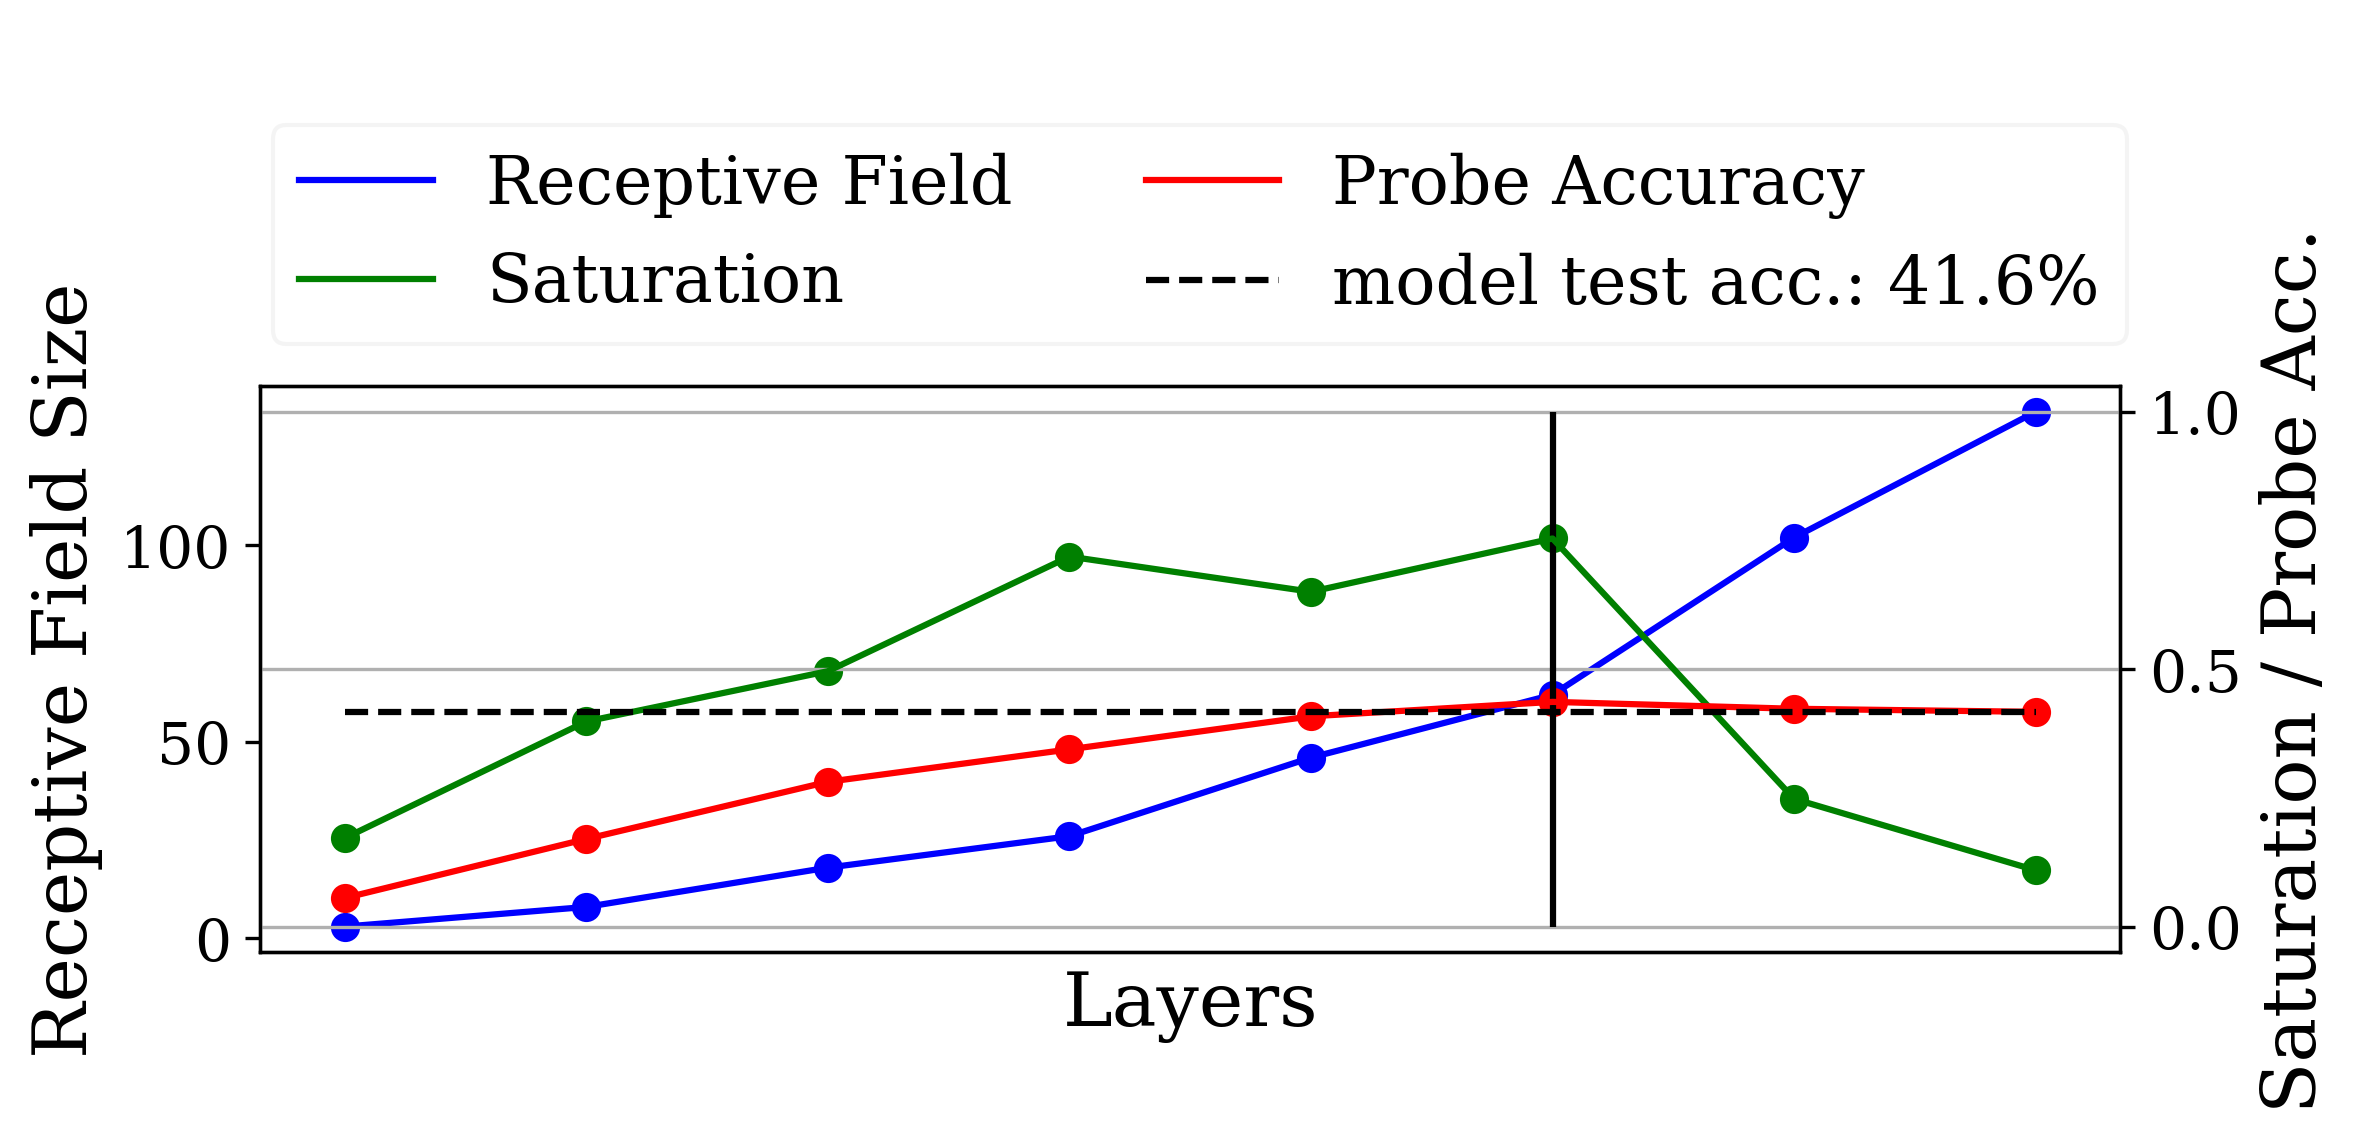

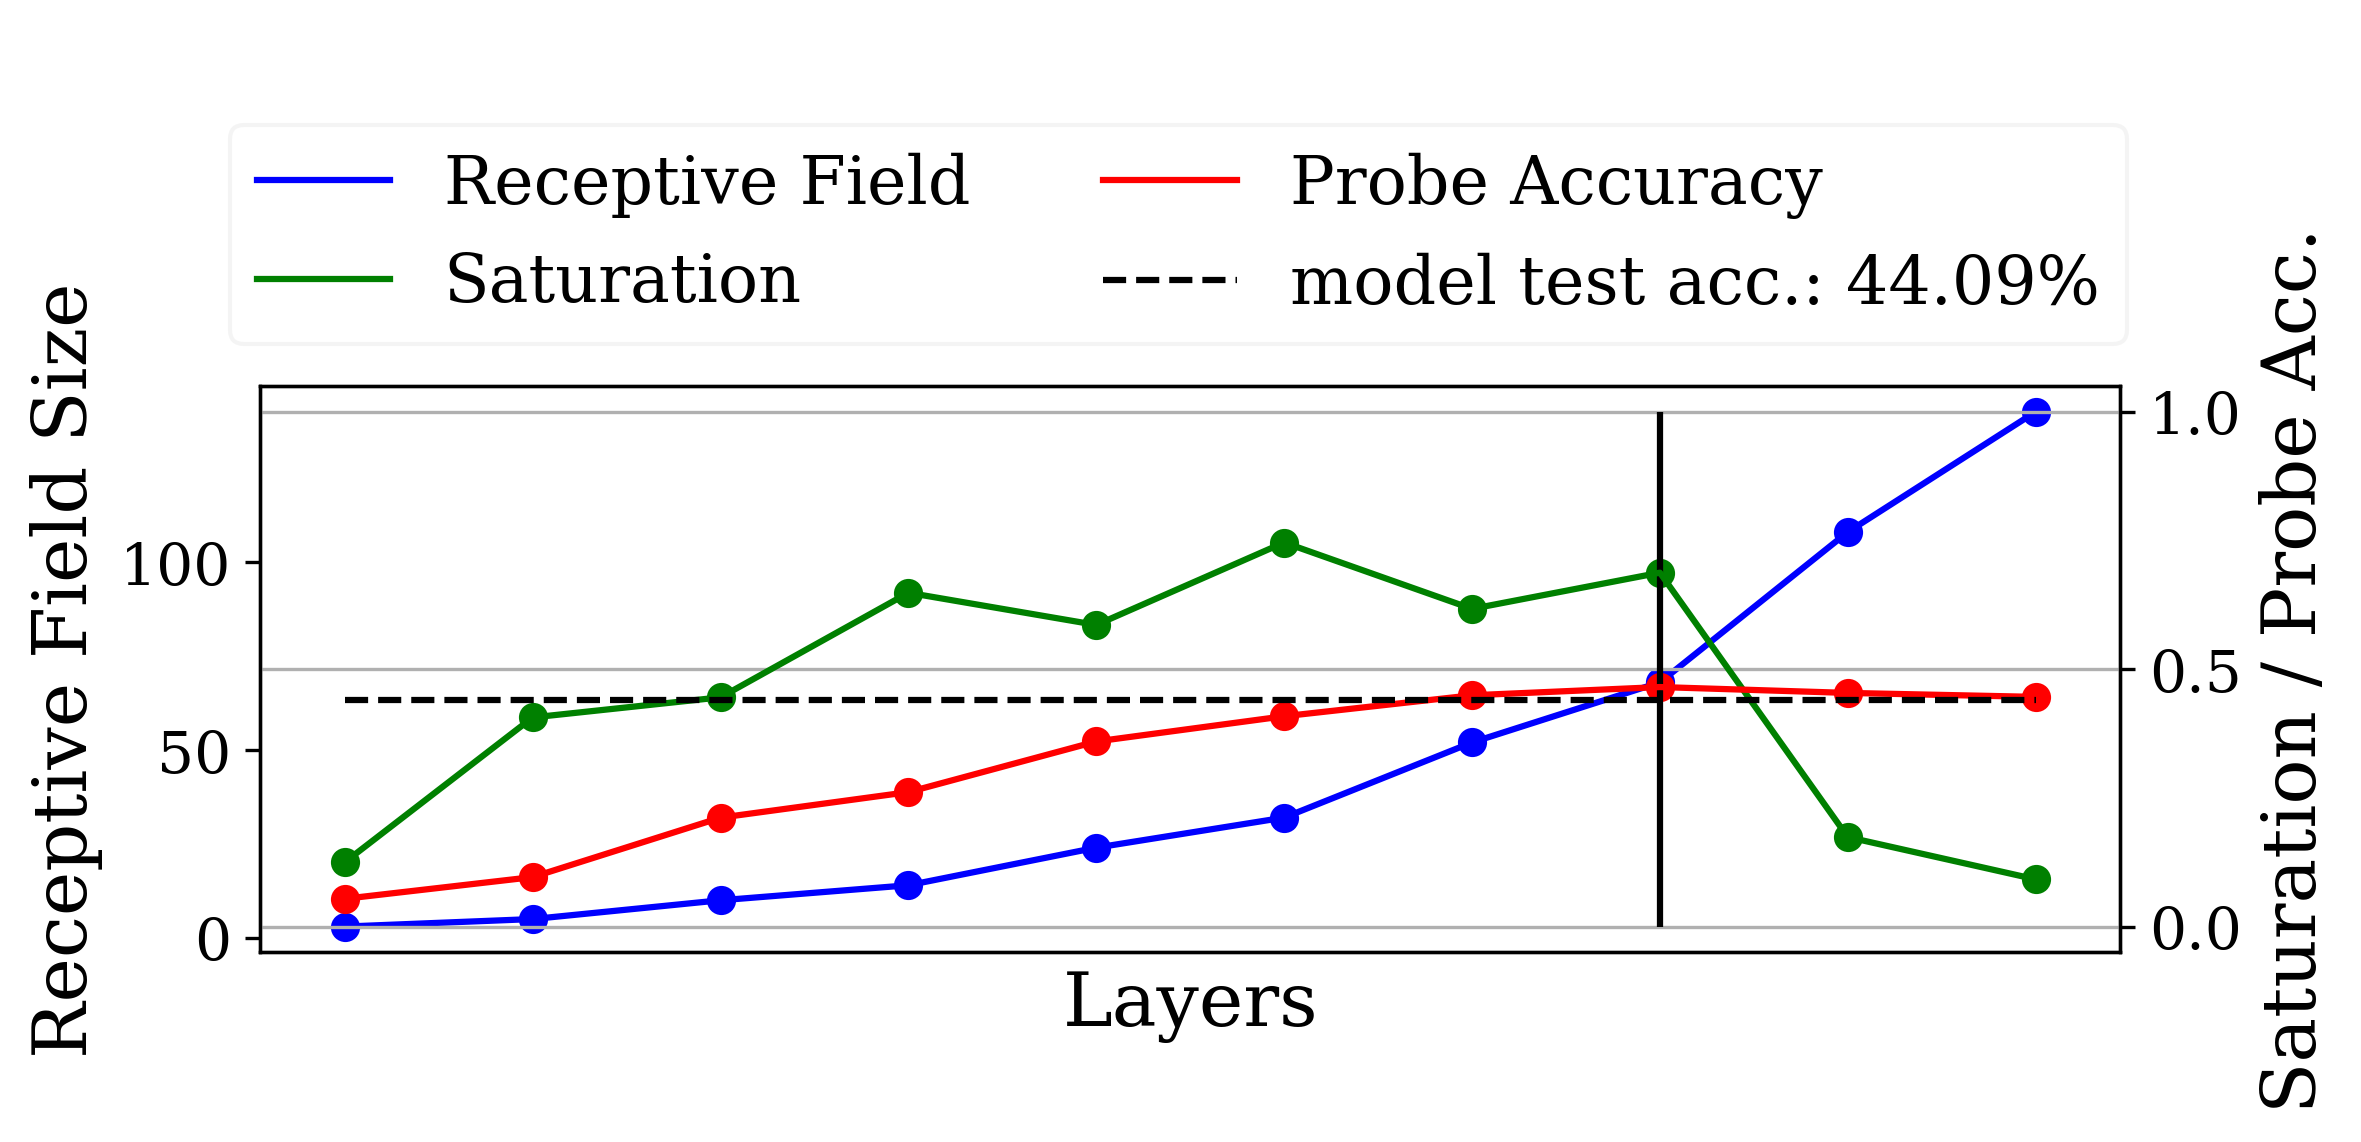

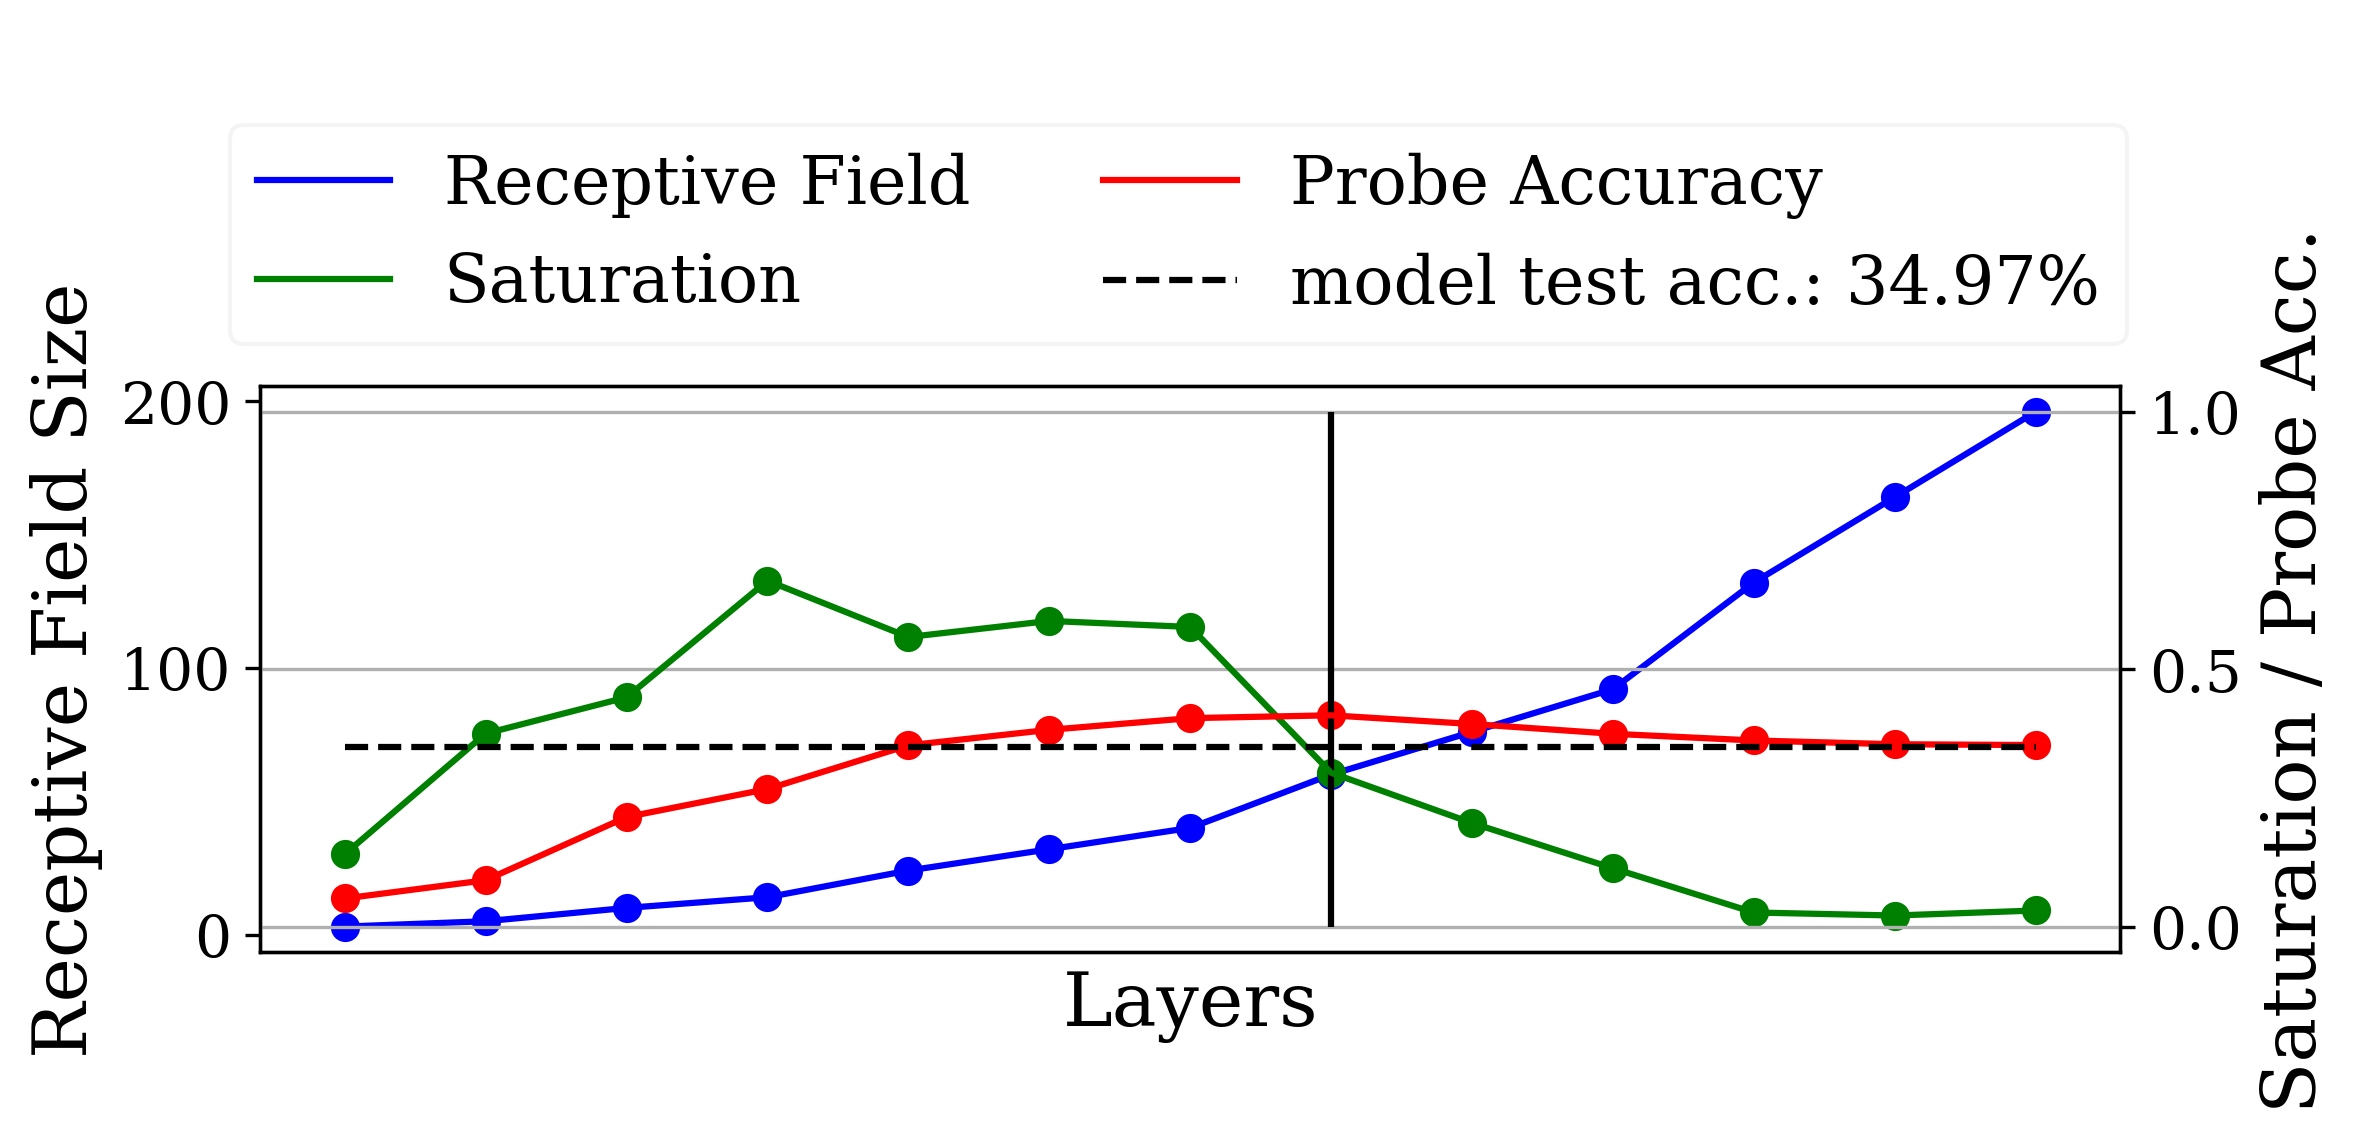

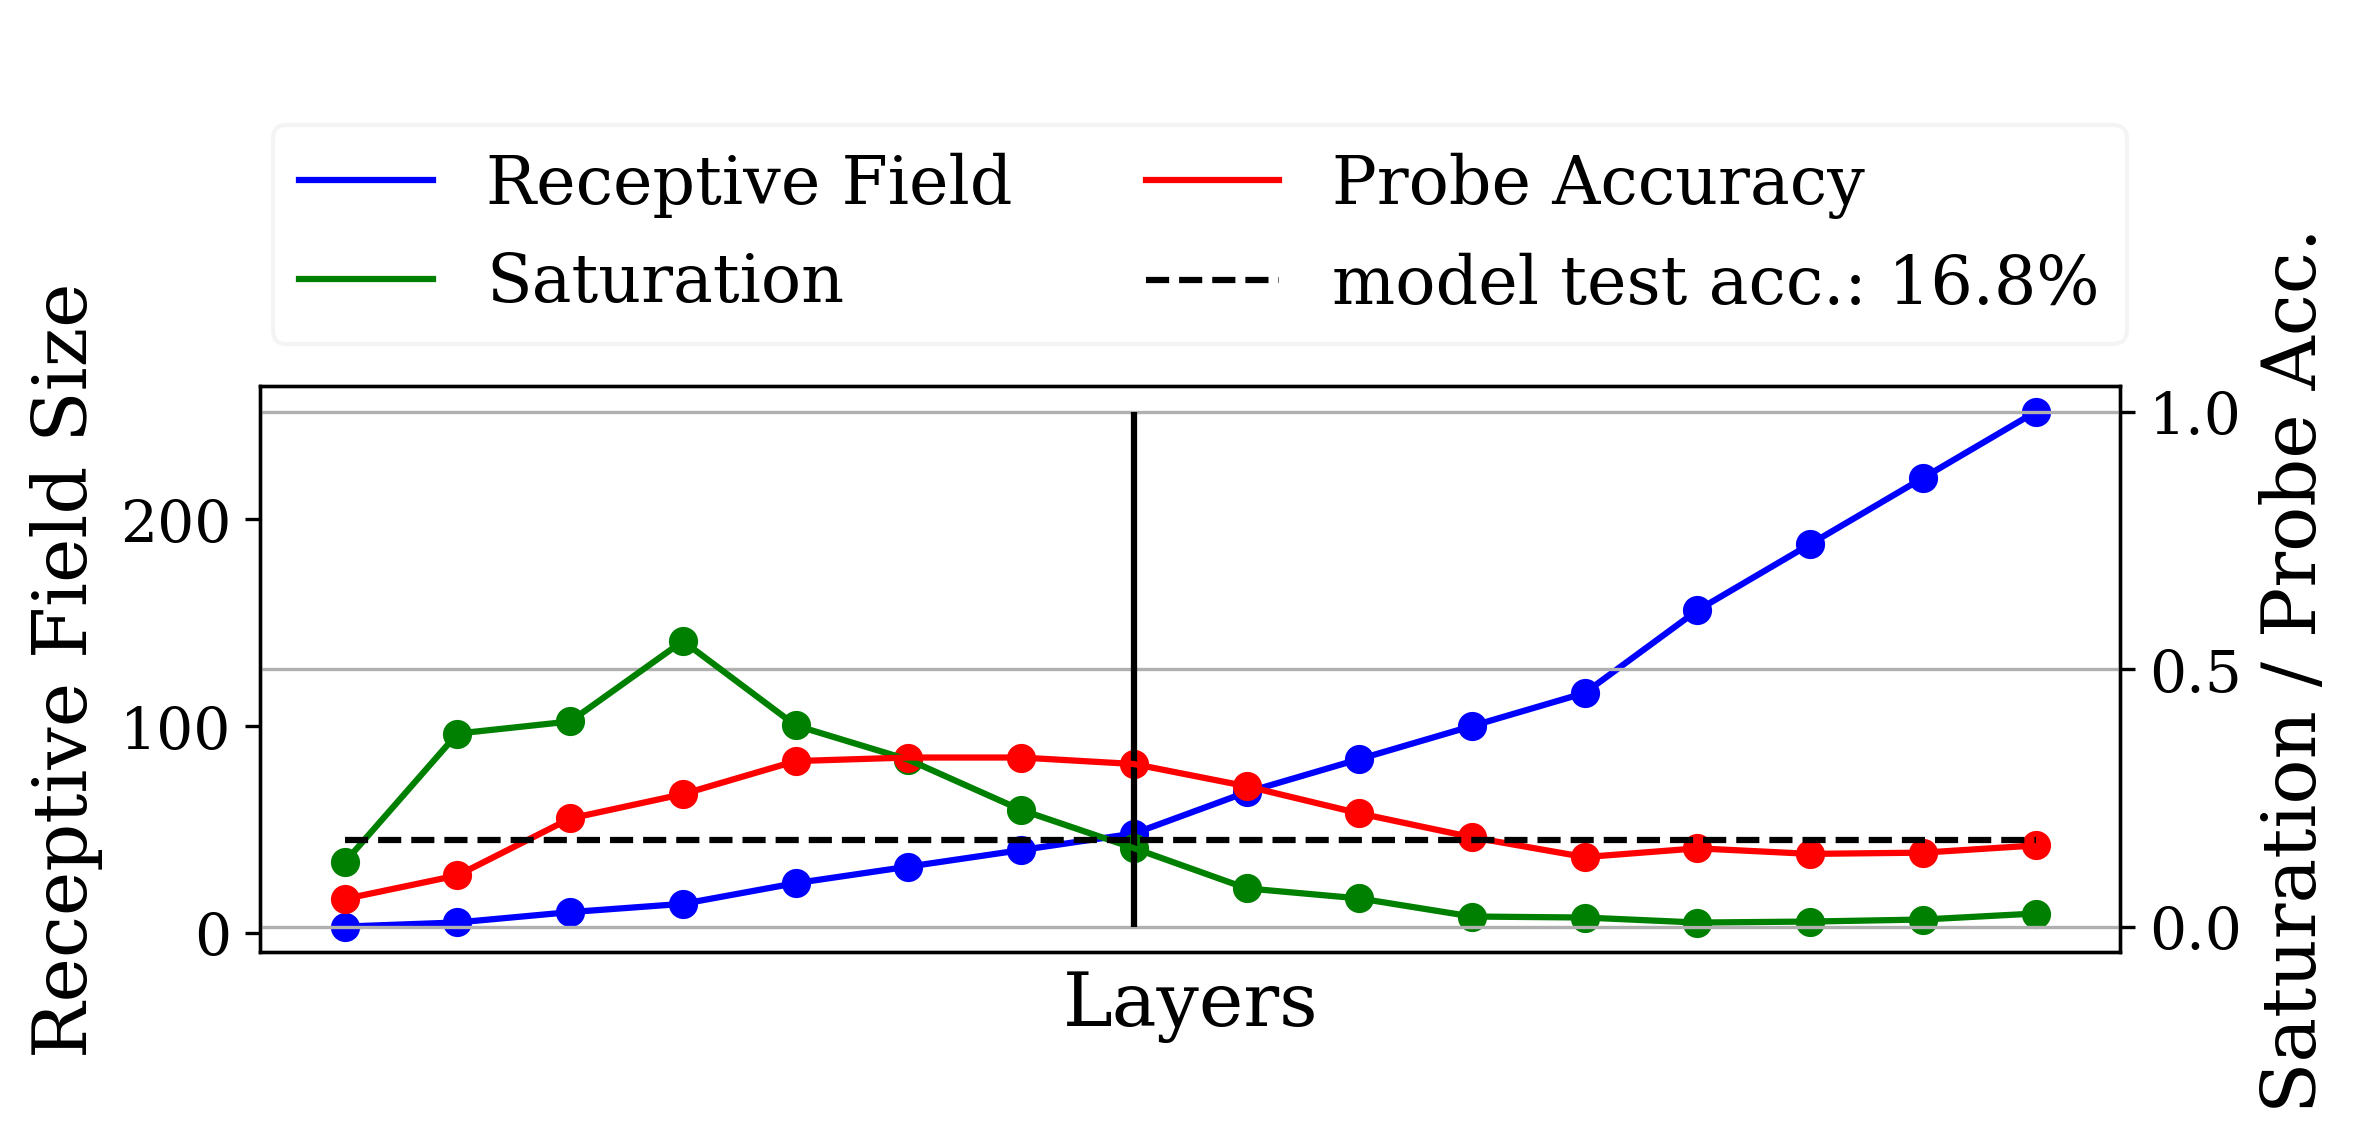

In [6]:
for model in ['VGG11', "VGG13", "VGG16", "VGG19"]:
    dataset = 'Cifar10'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

### Figure 5

8 8 10
10 10 12
13 13 15
16 16 18


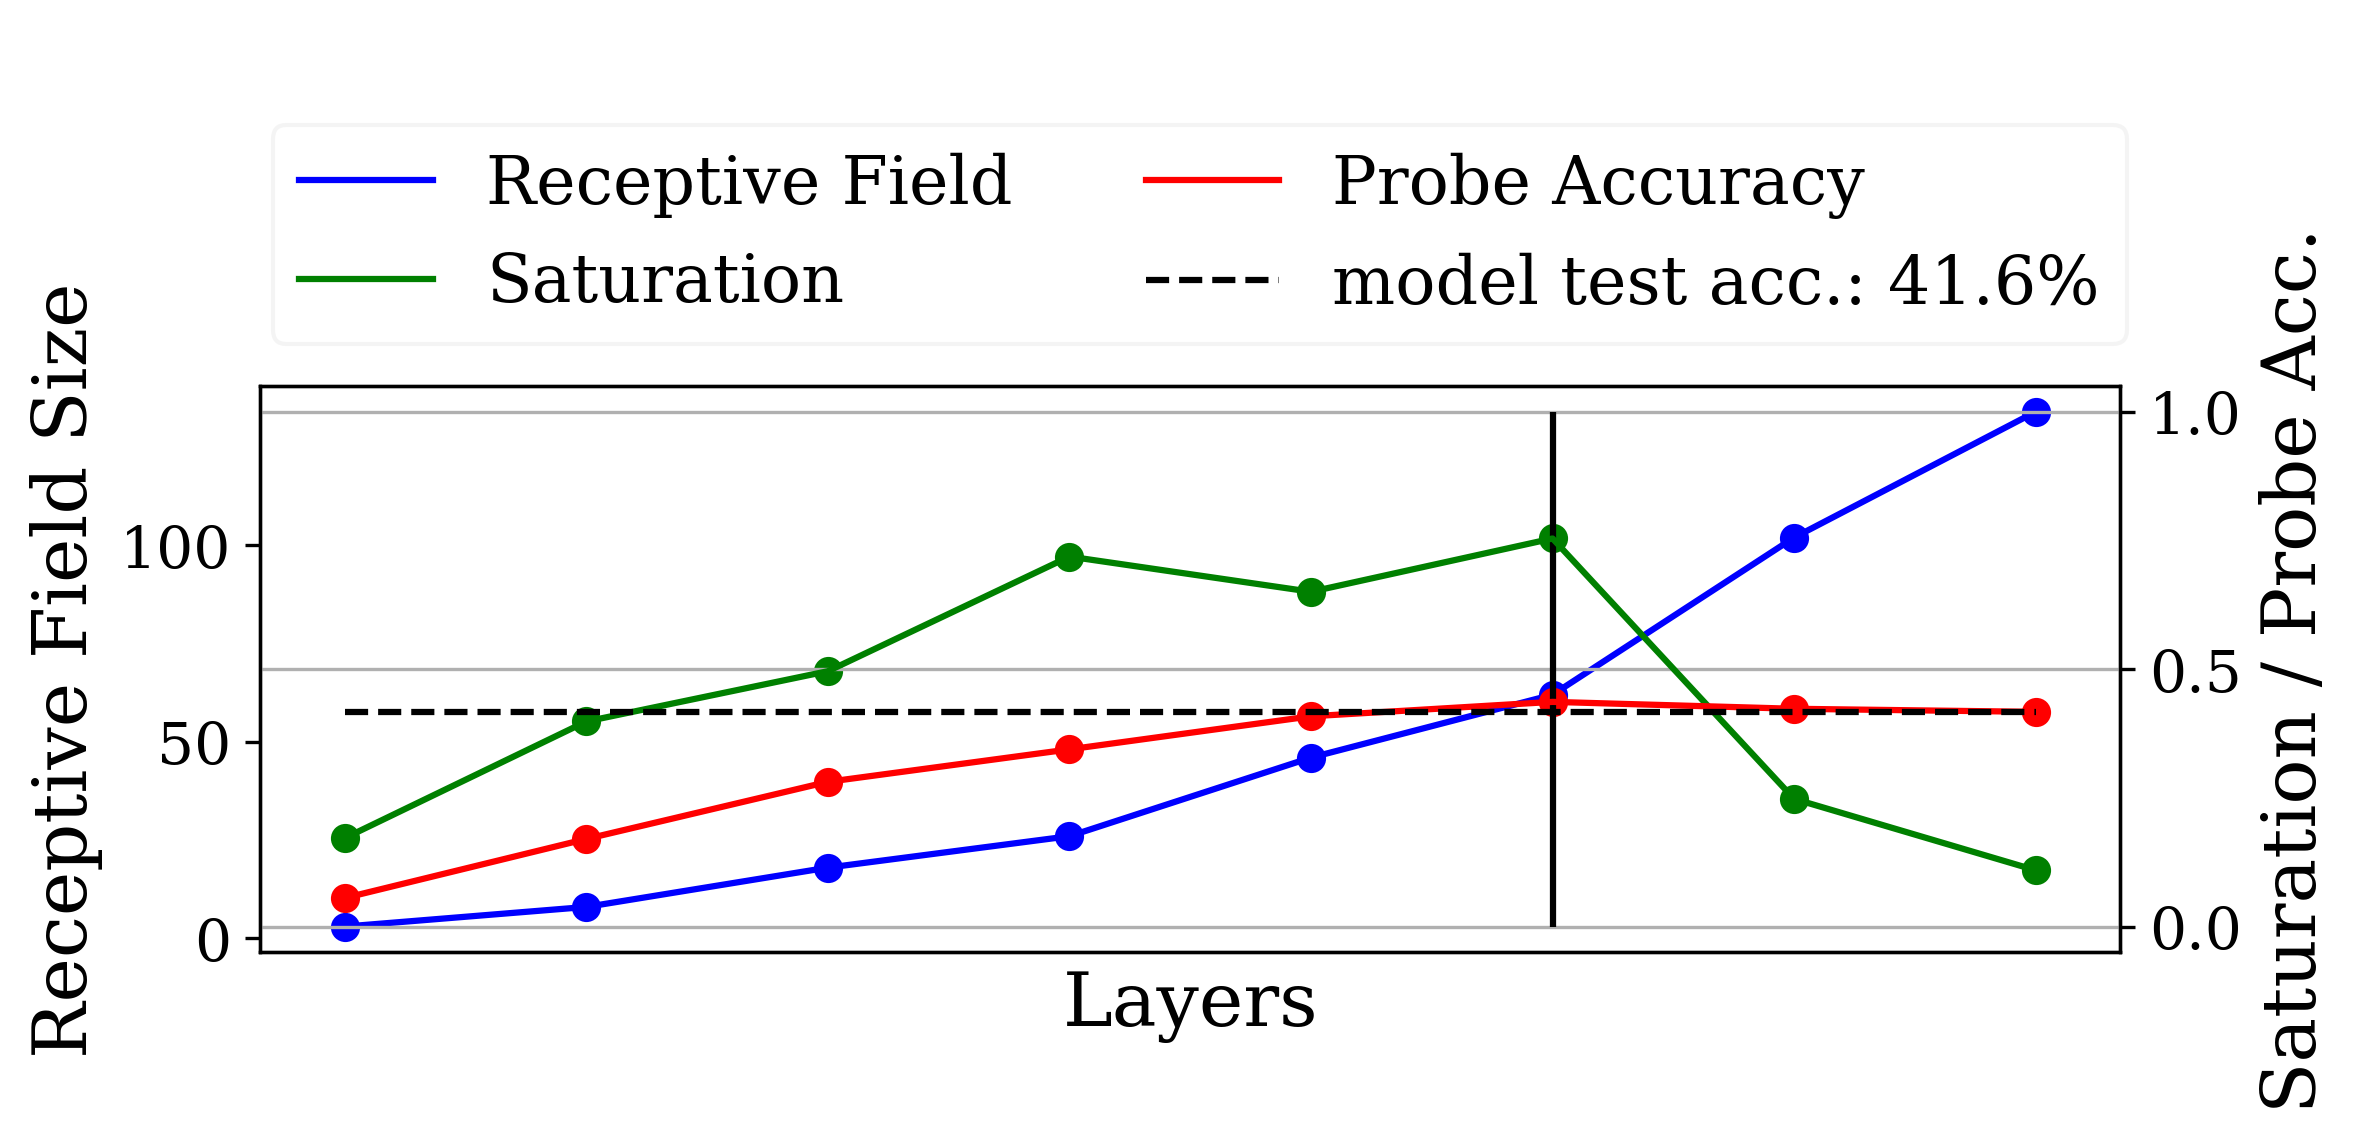

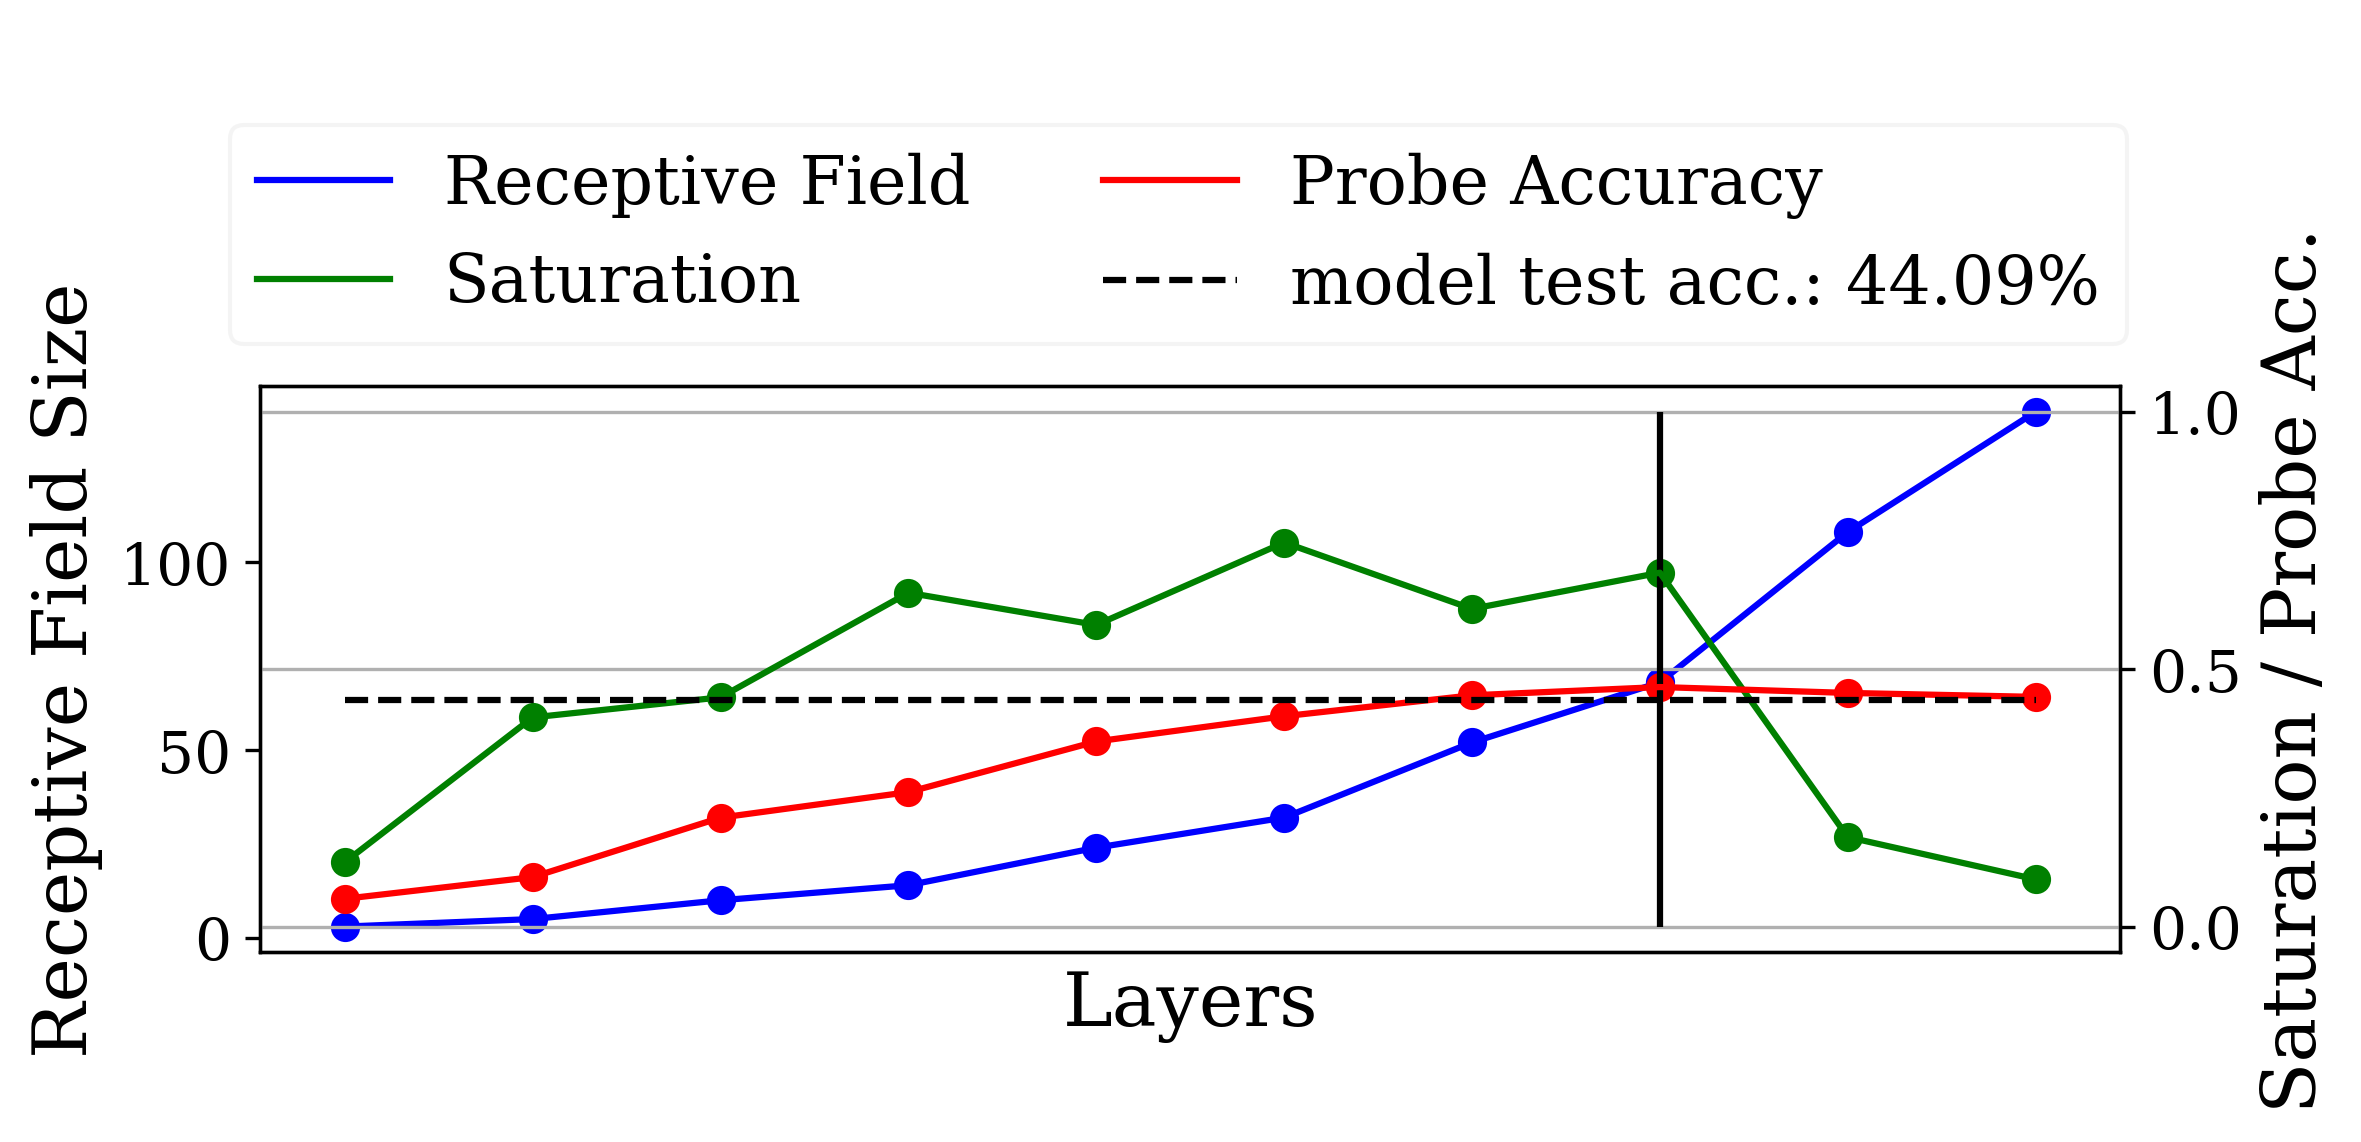

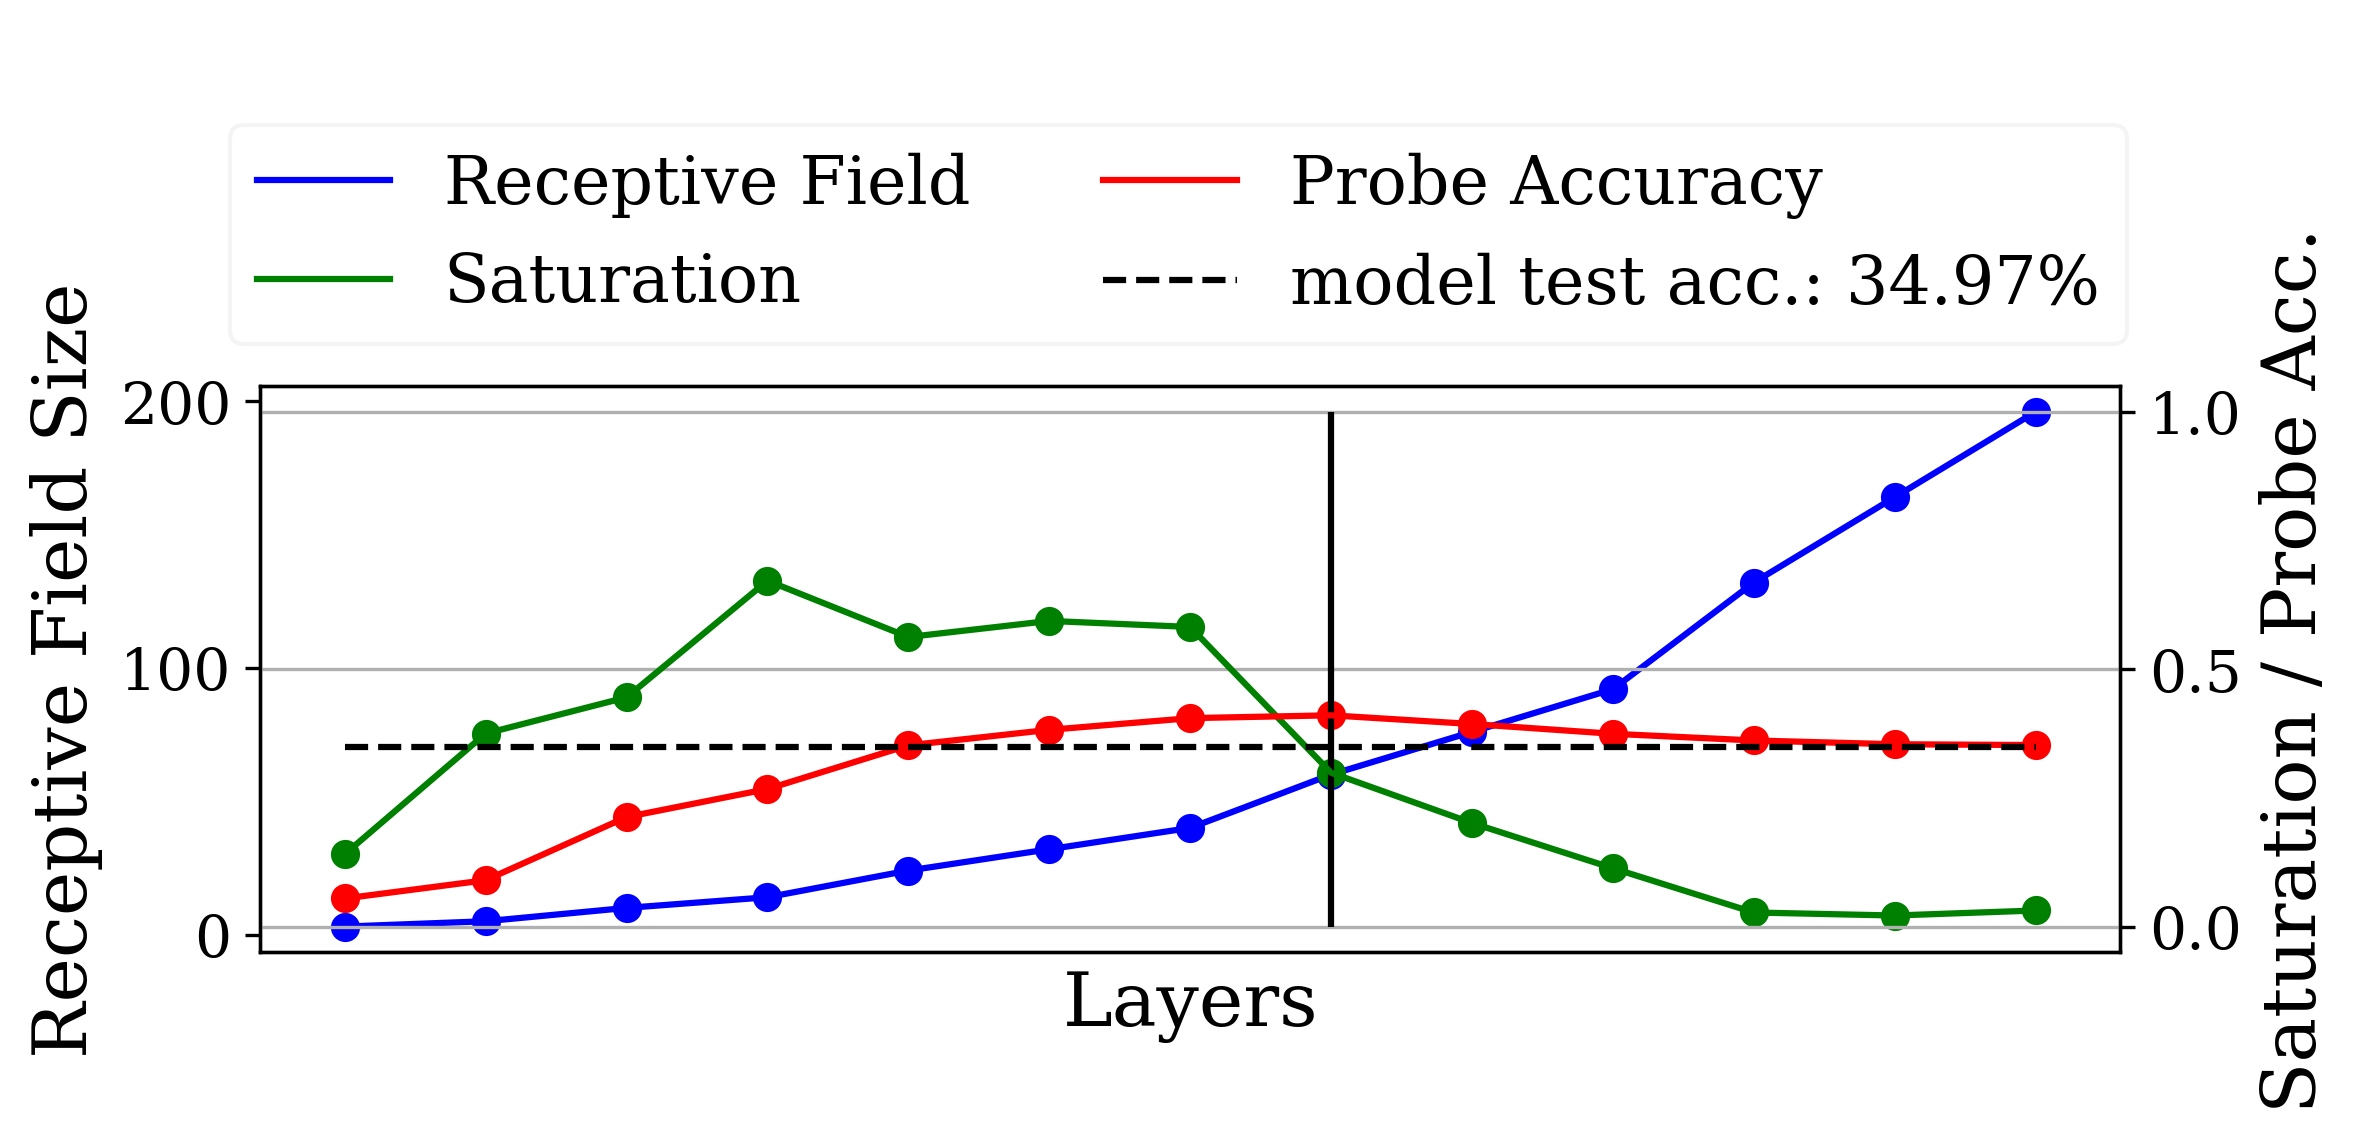

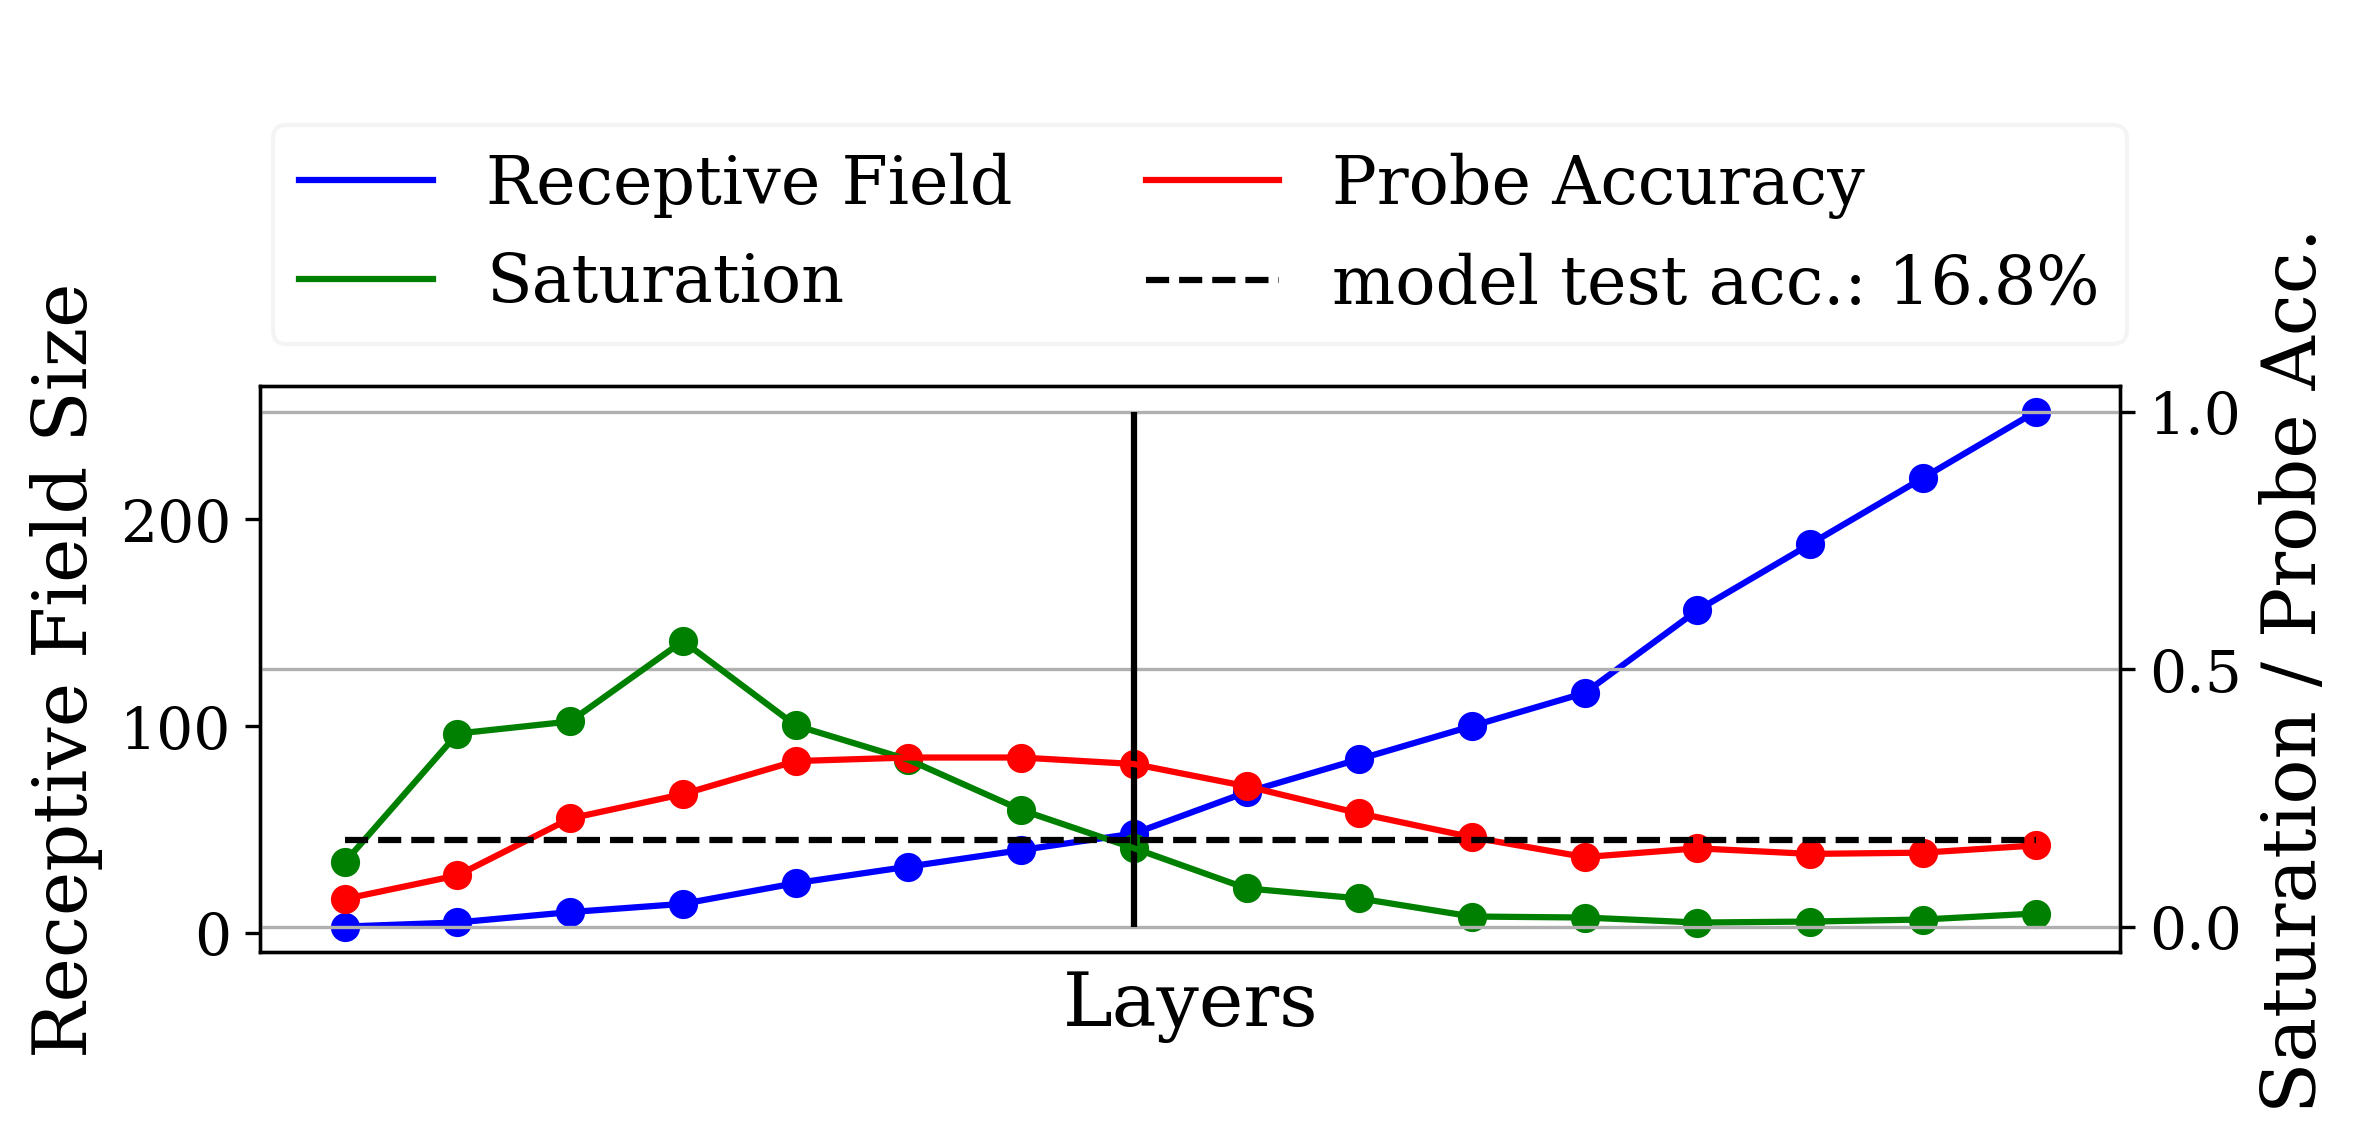

In [6]:
for model in ["resnet18noskip", "vgg19_d3"]:
    dataset = 'Cifar10'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

### Figure 8

8 8 10
10 10 12
13 13 15
16 16 18


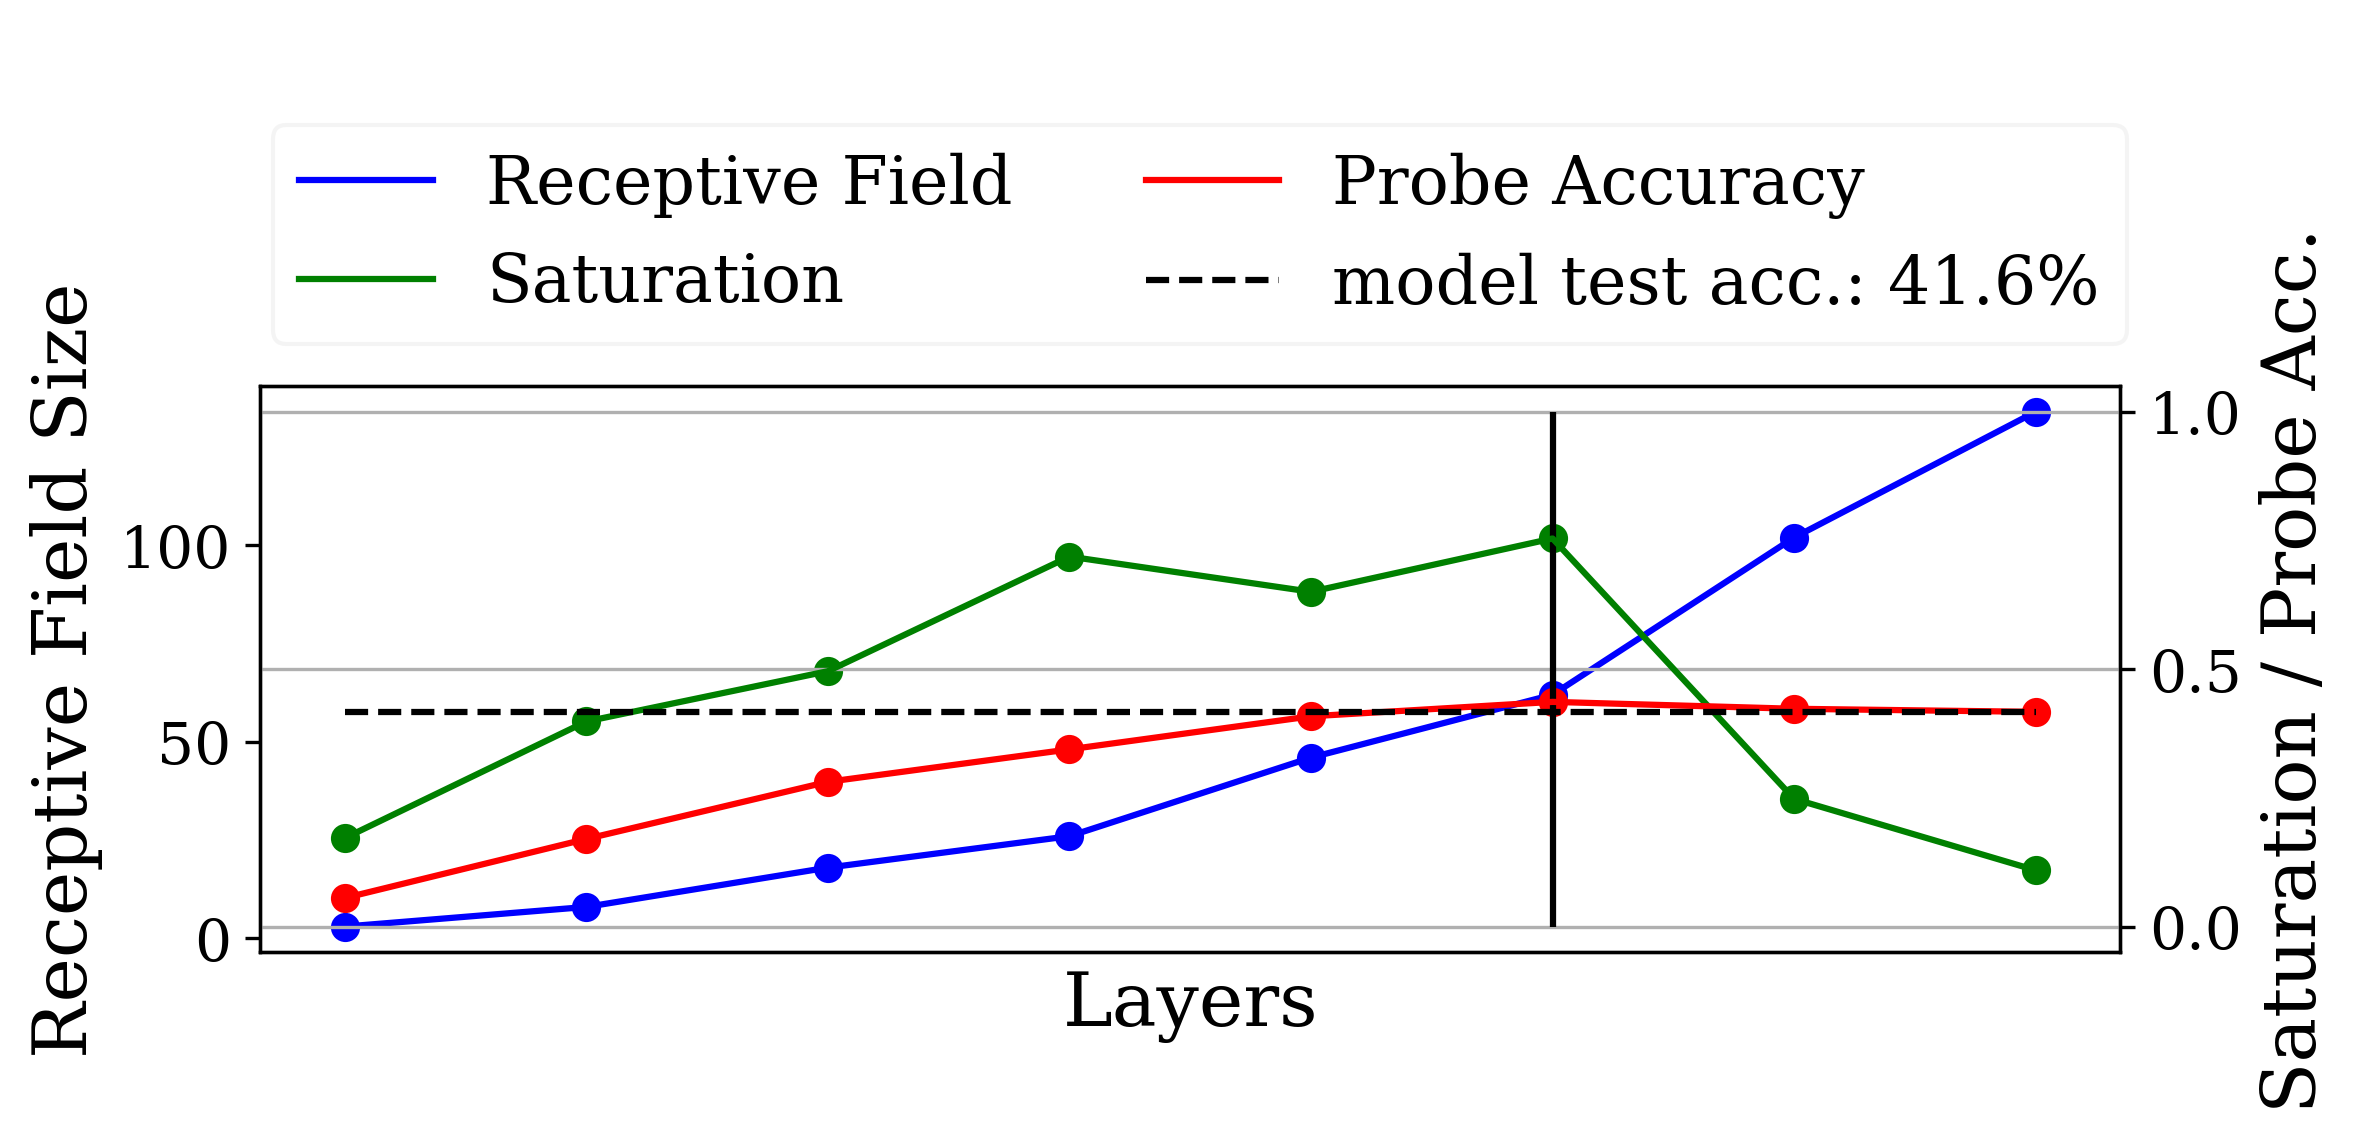

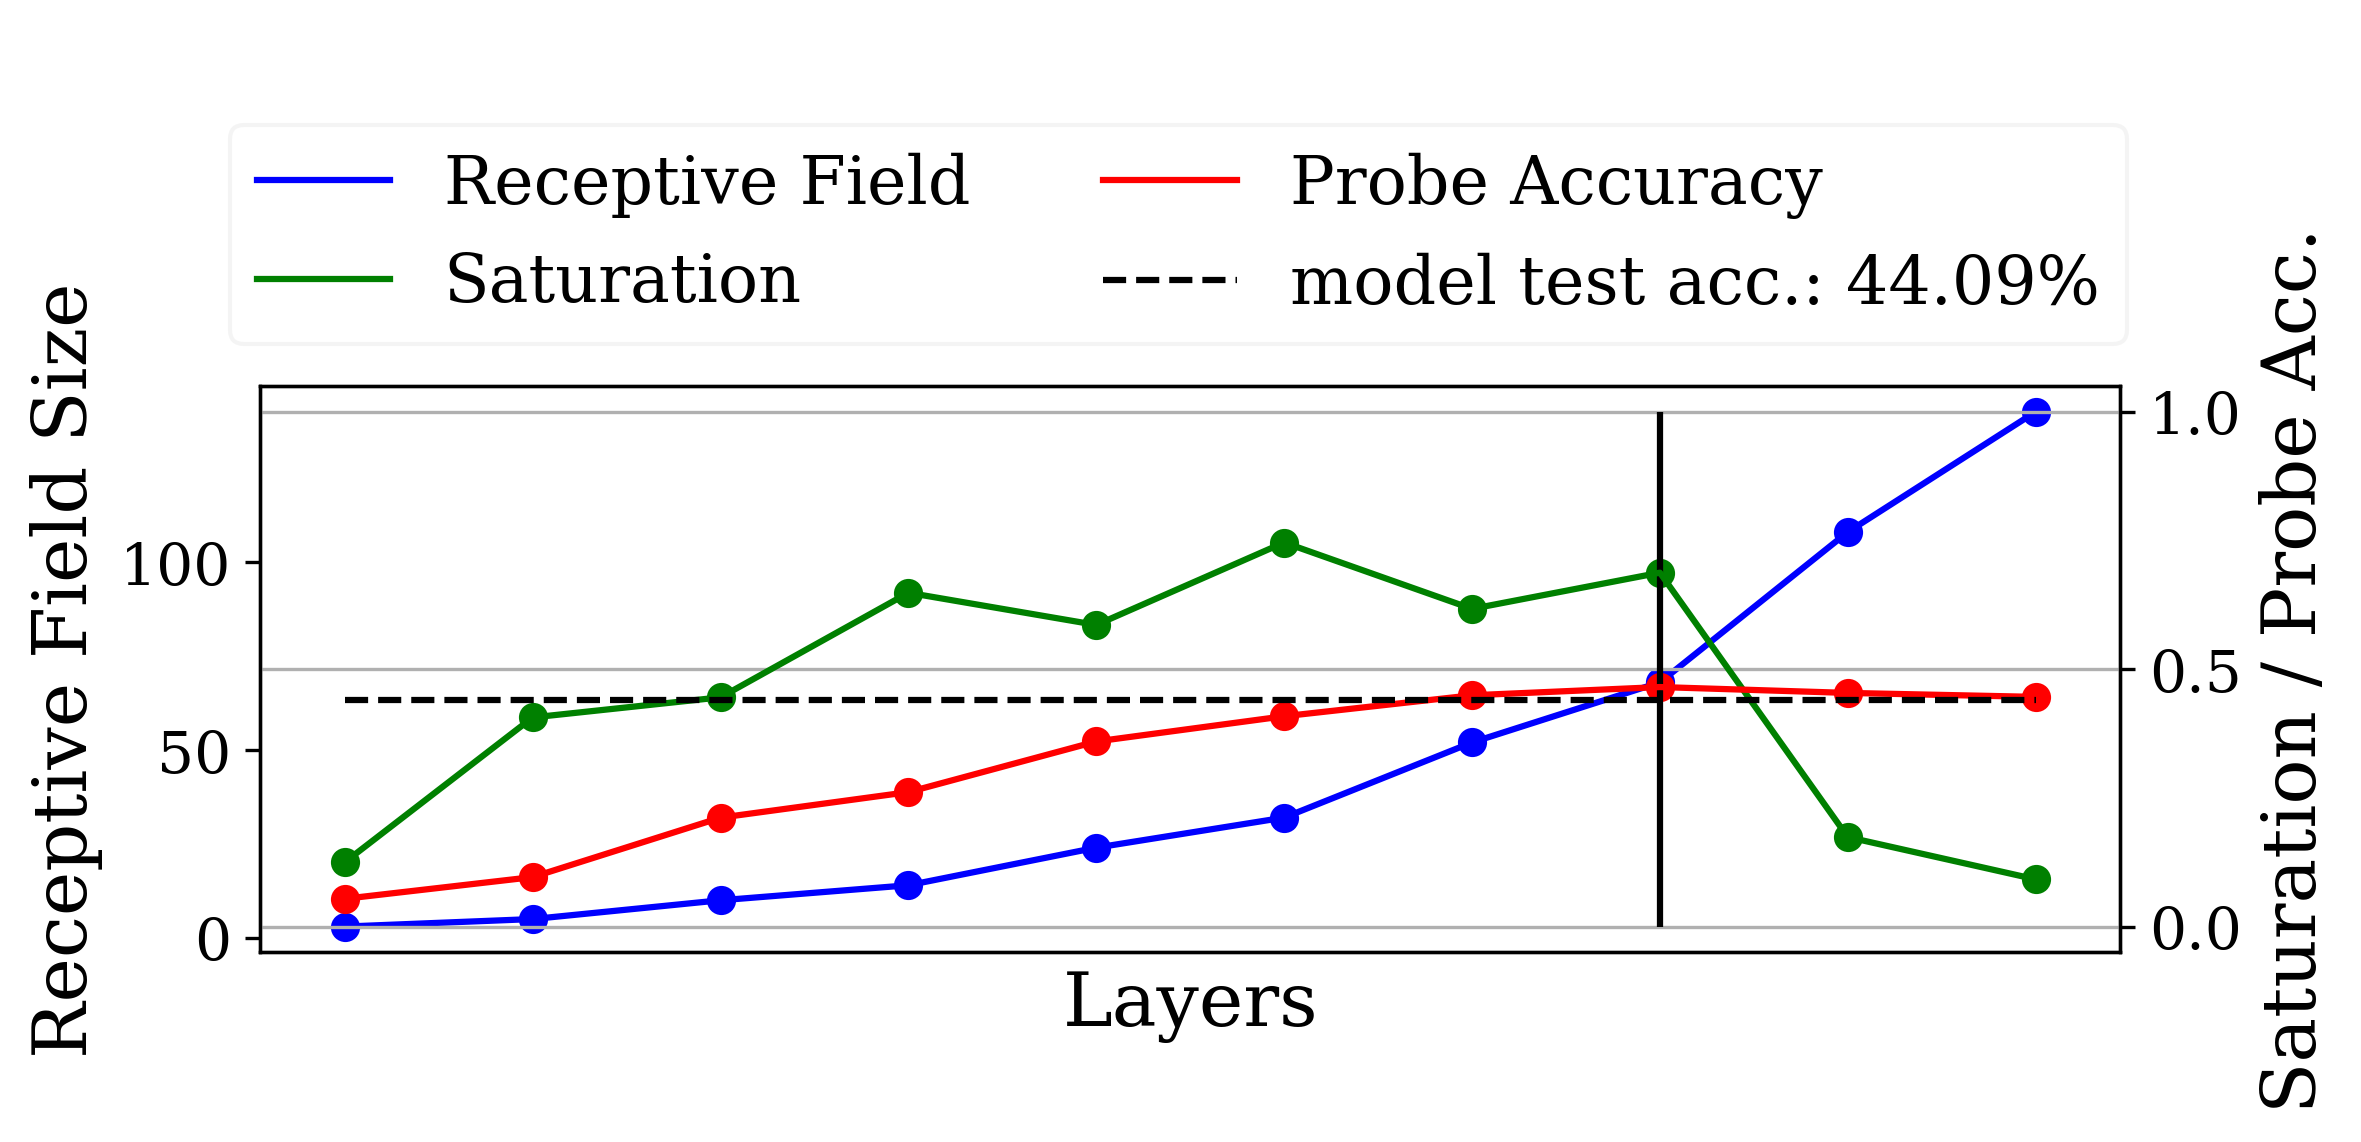

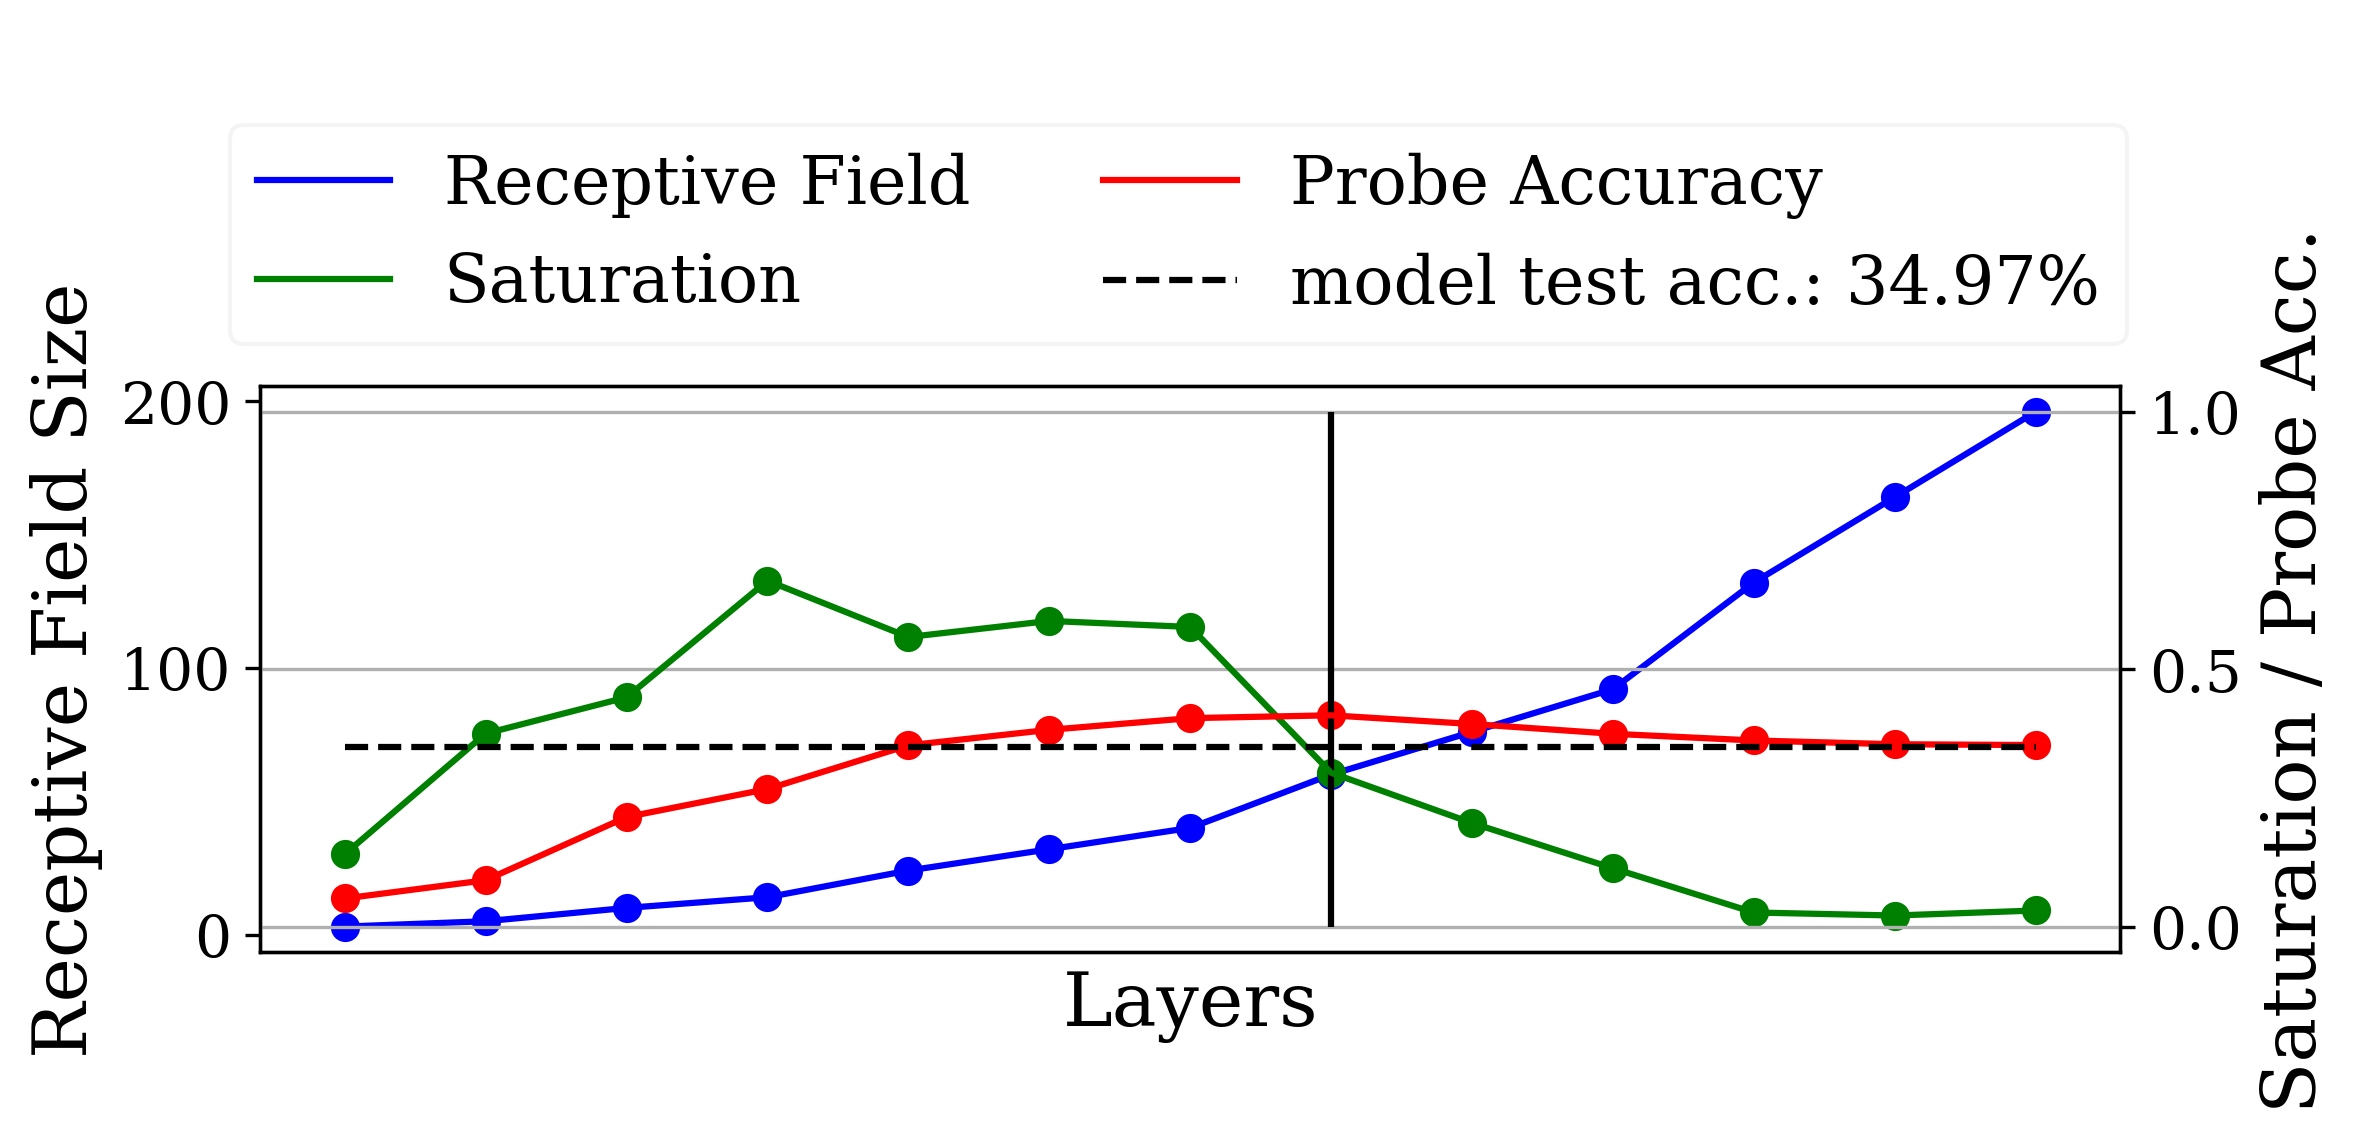

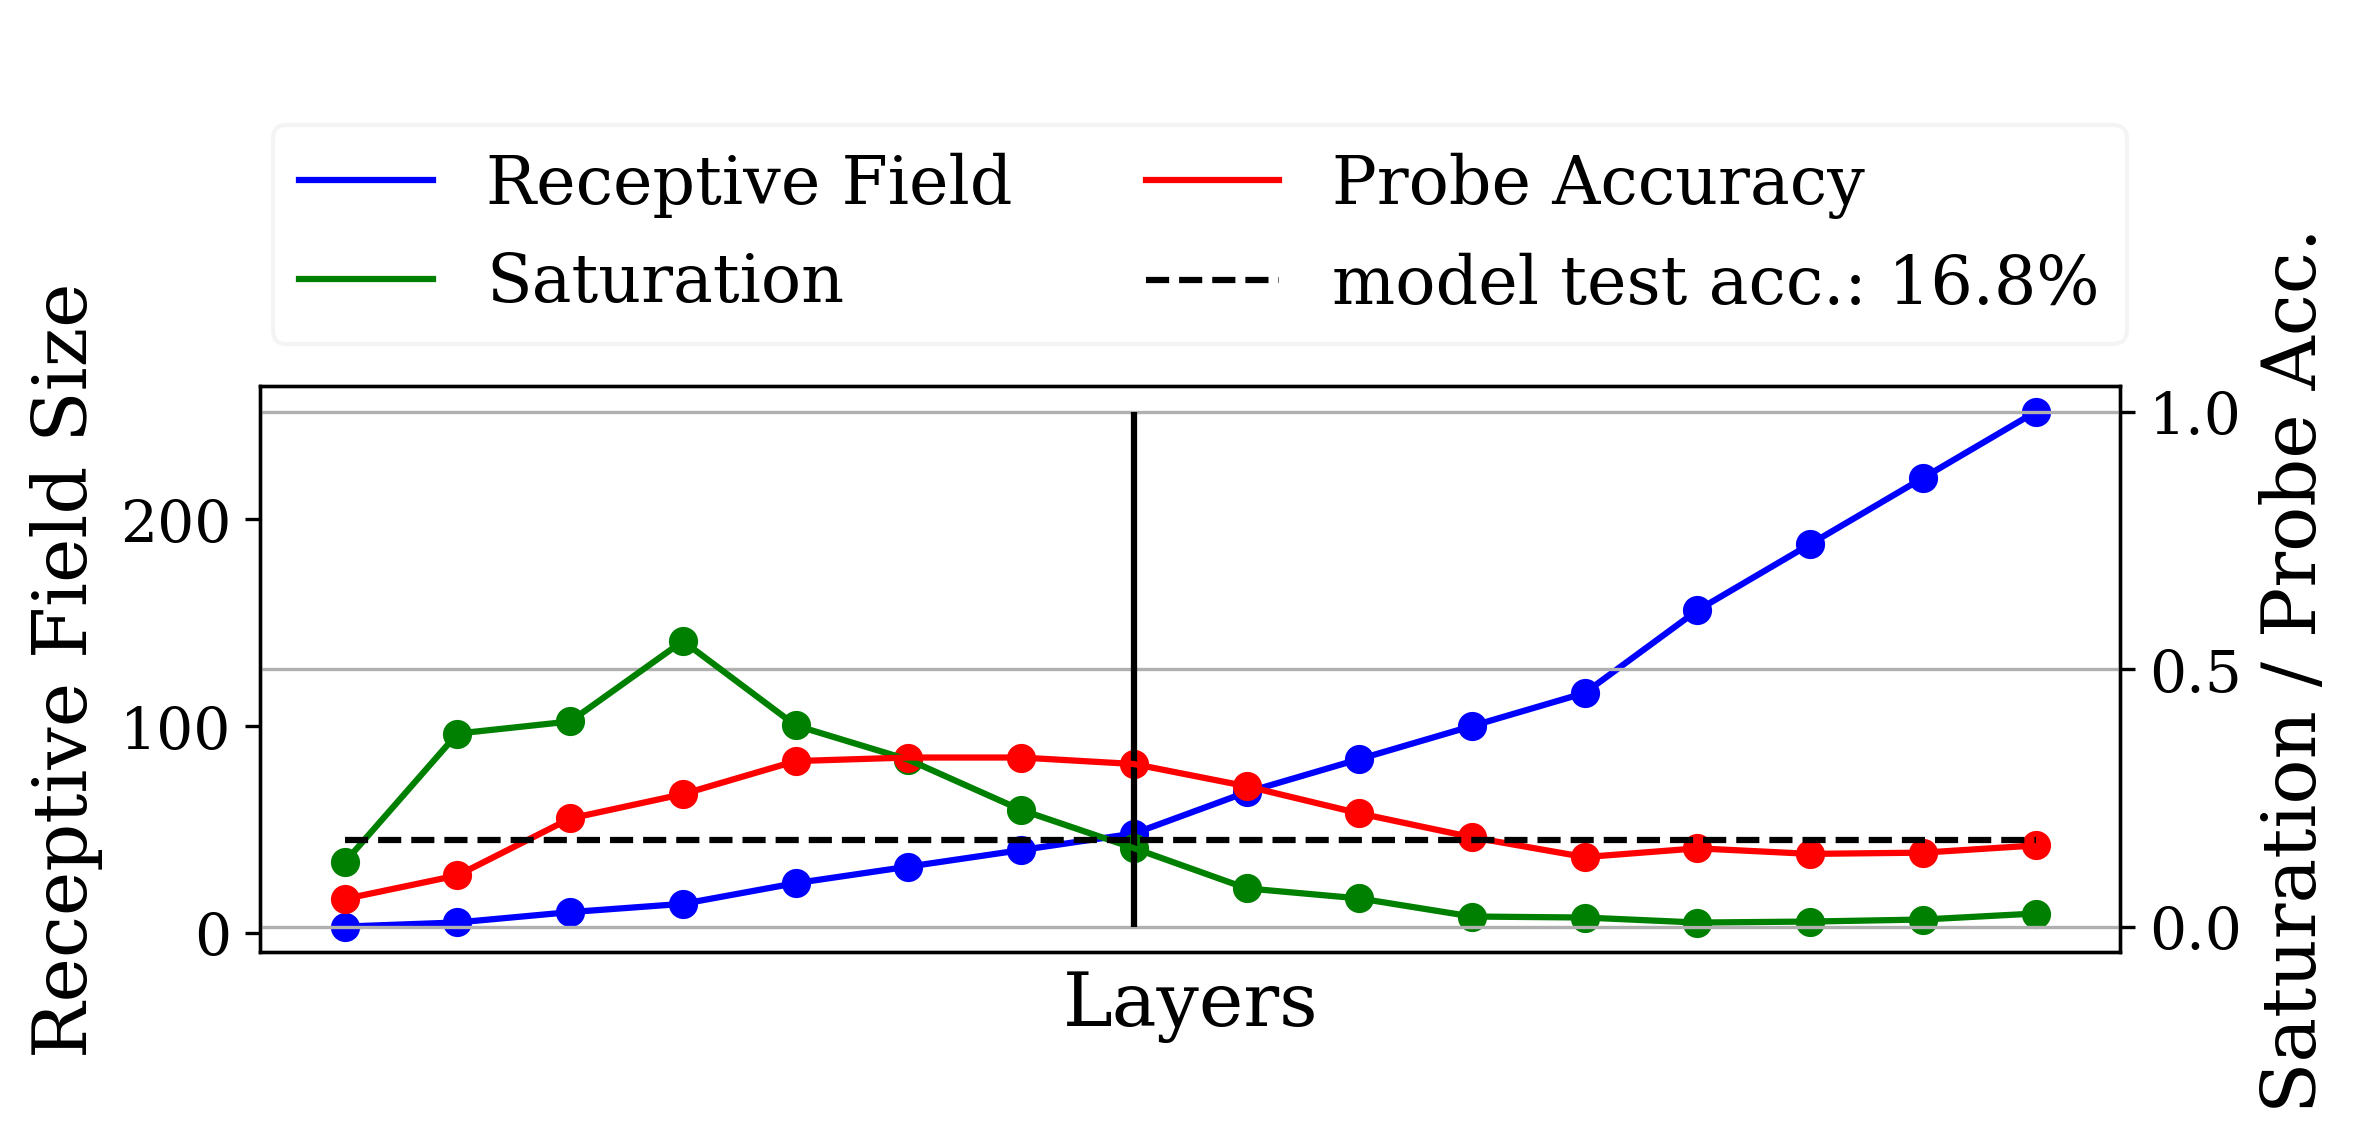

In [6]:
for model in ["ResNet18_PC", "ResNet34_PC"]:
    dataset = 'Cifar10'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

### Figure 15

8 8 10
10 10 12
13 13 15
16 16 18


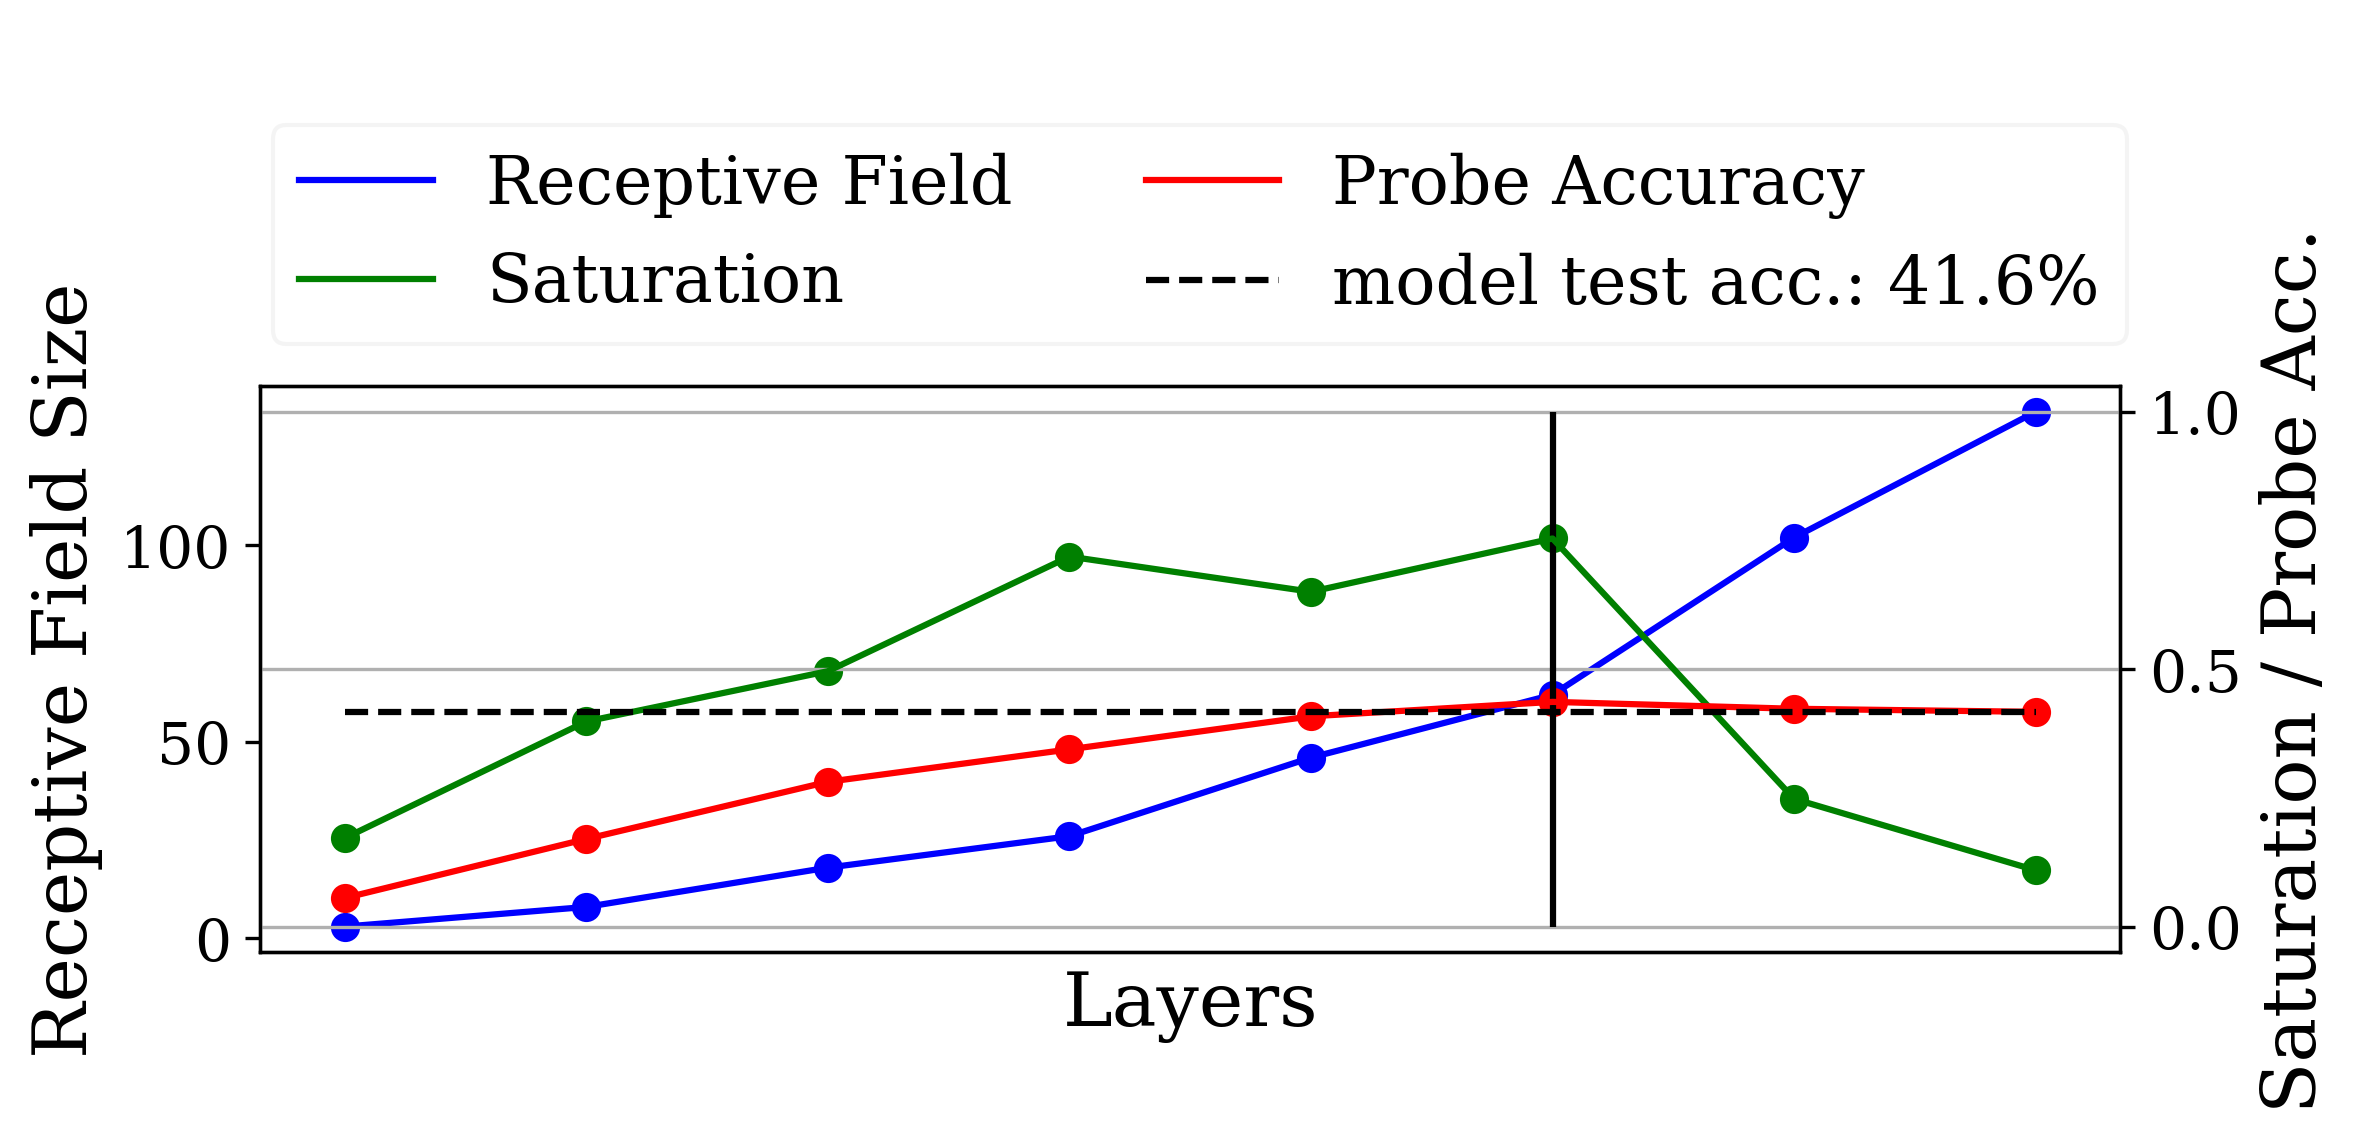

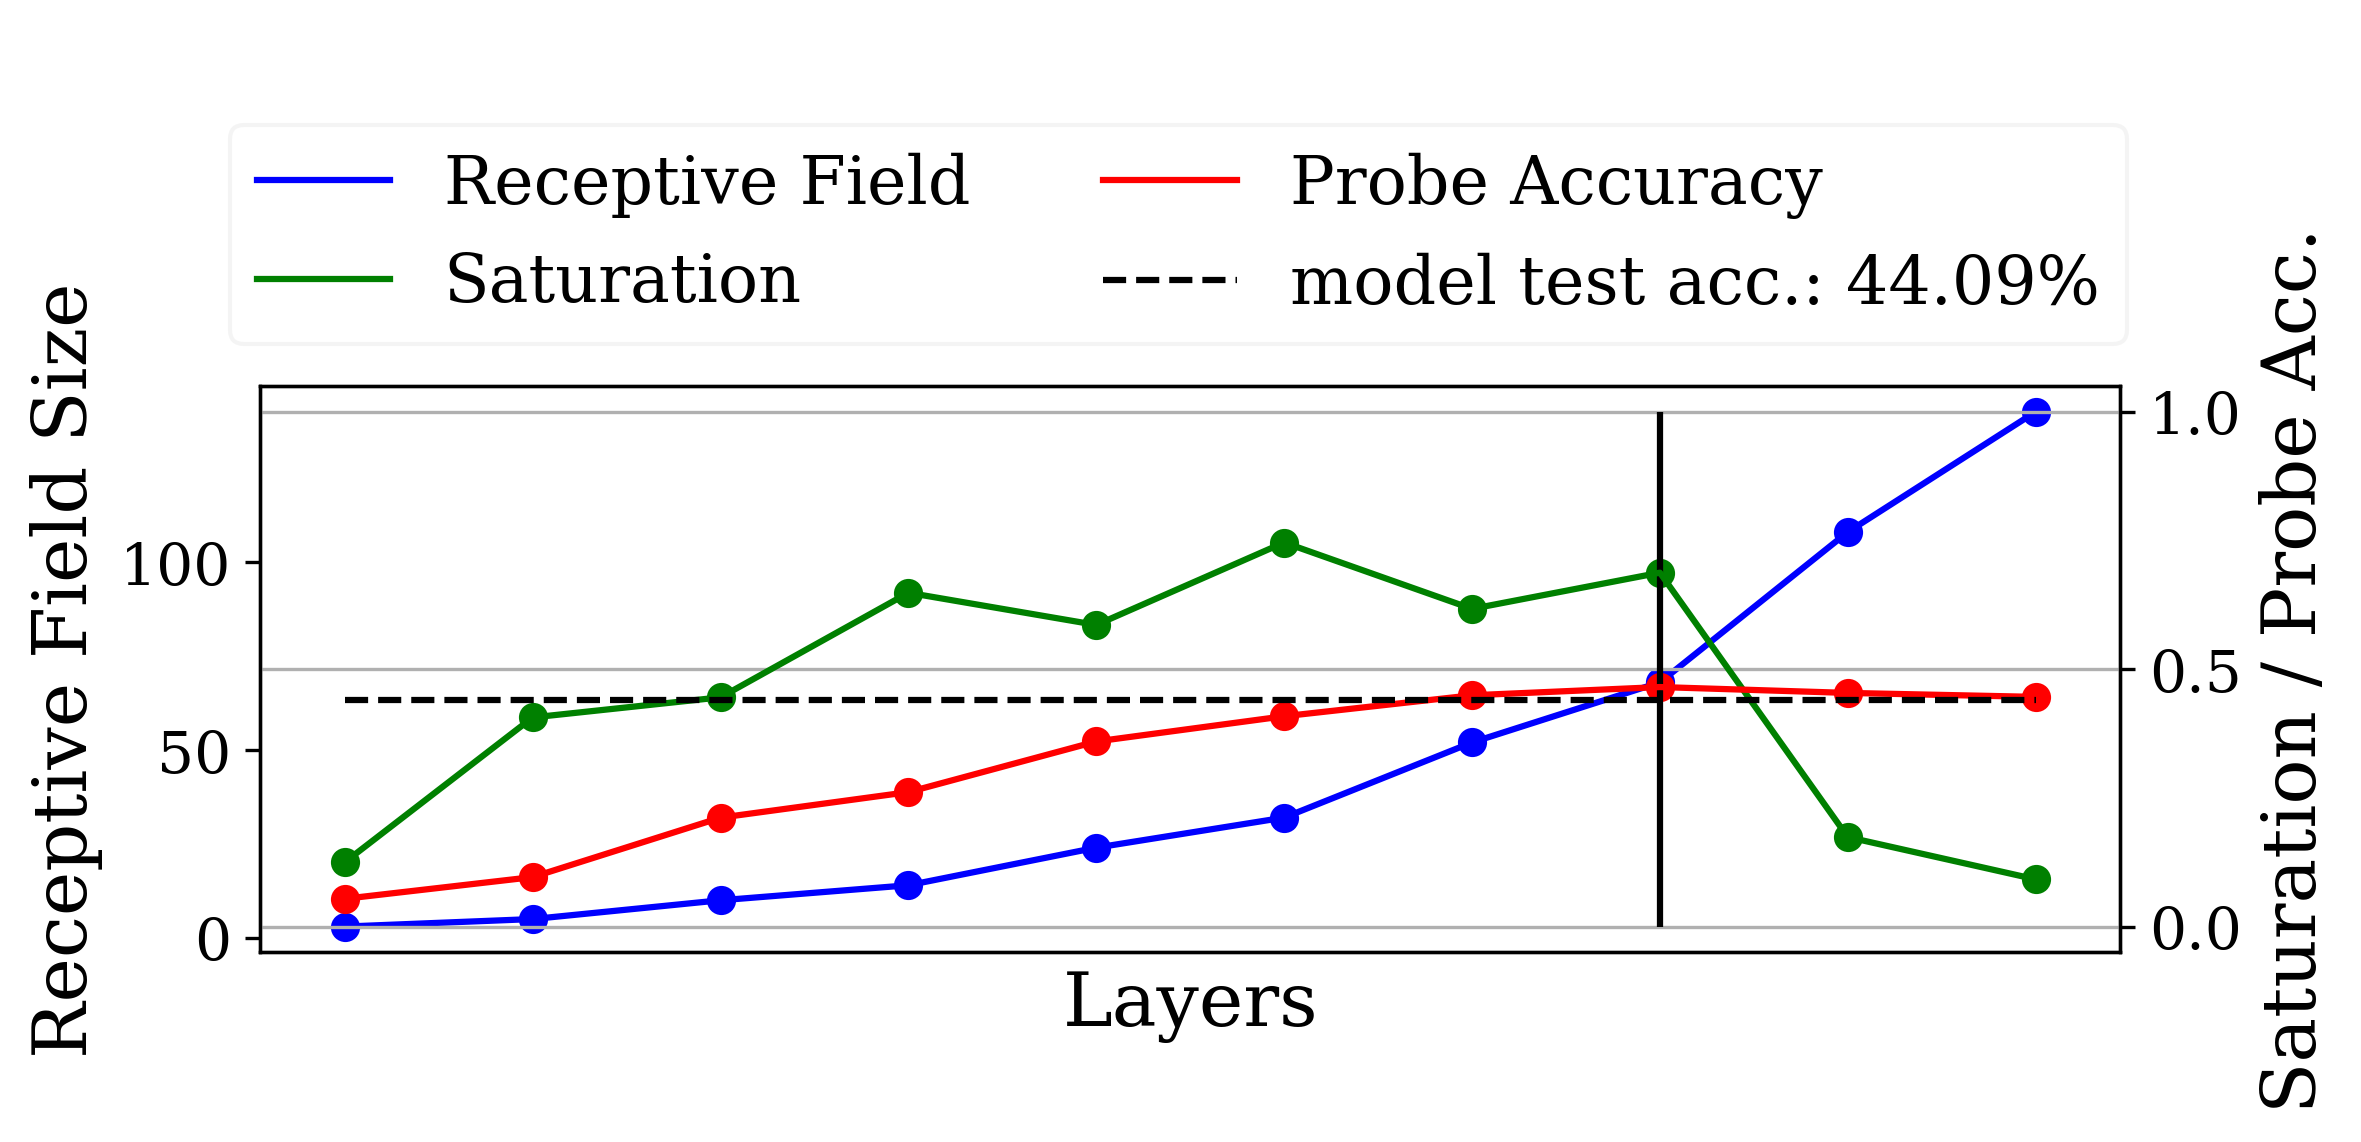

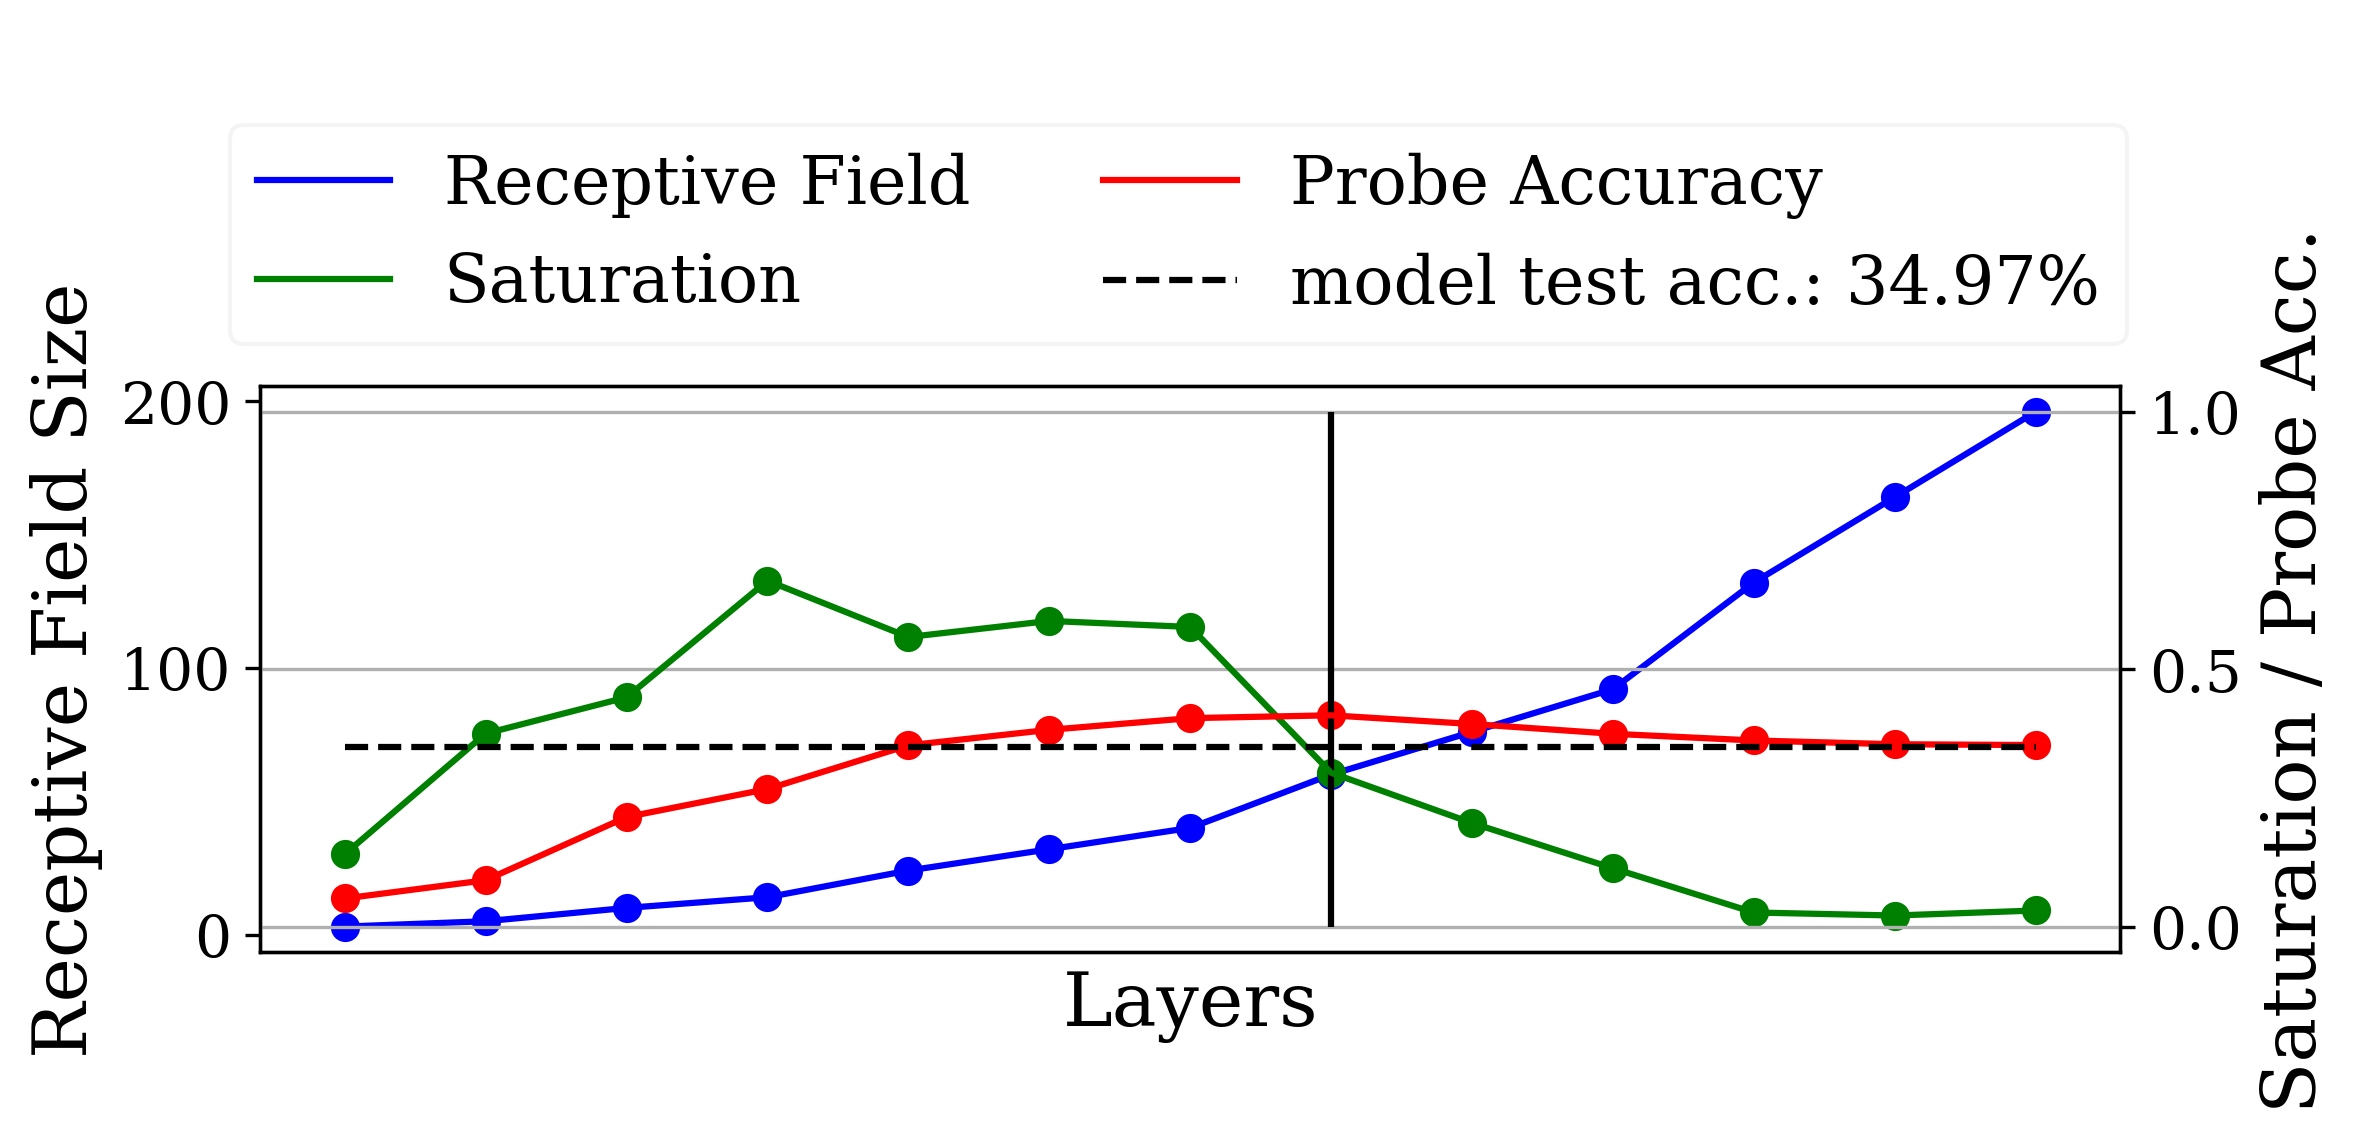

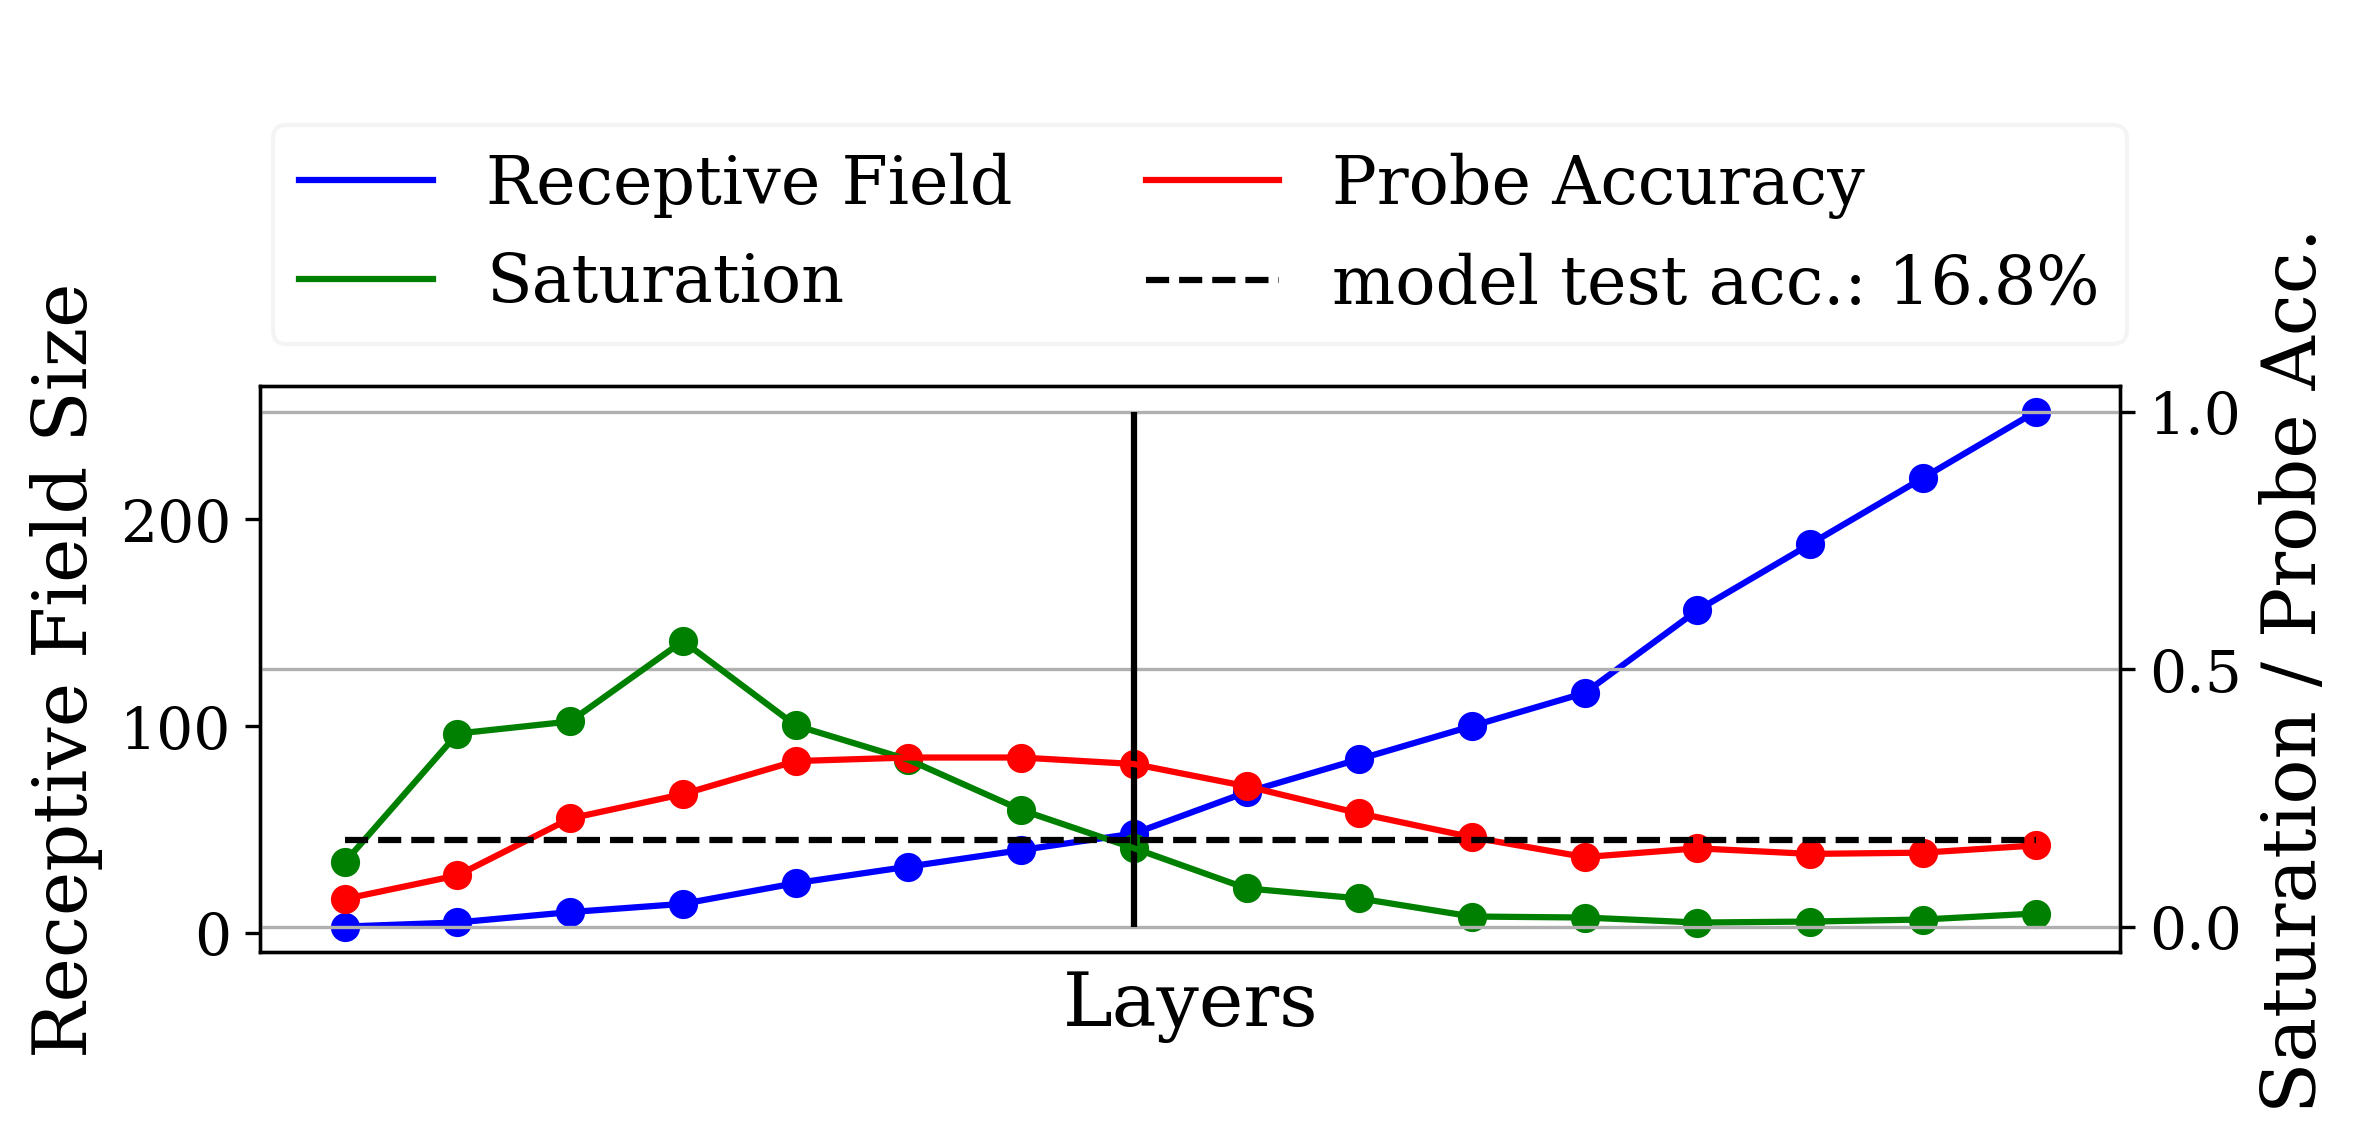

In [6]:
for model in ["VGG11", "VGG13", "VGG16"]:
    dataset = 'TinyImageNet'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

### Figure 16

In [ ]:
for model in ["VGG11", "VGG13", "VGG16"]:
    dataset = 'Cifar10'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

### Figure 16

8 8 10
10 10 12
13 13 15
16 16 18


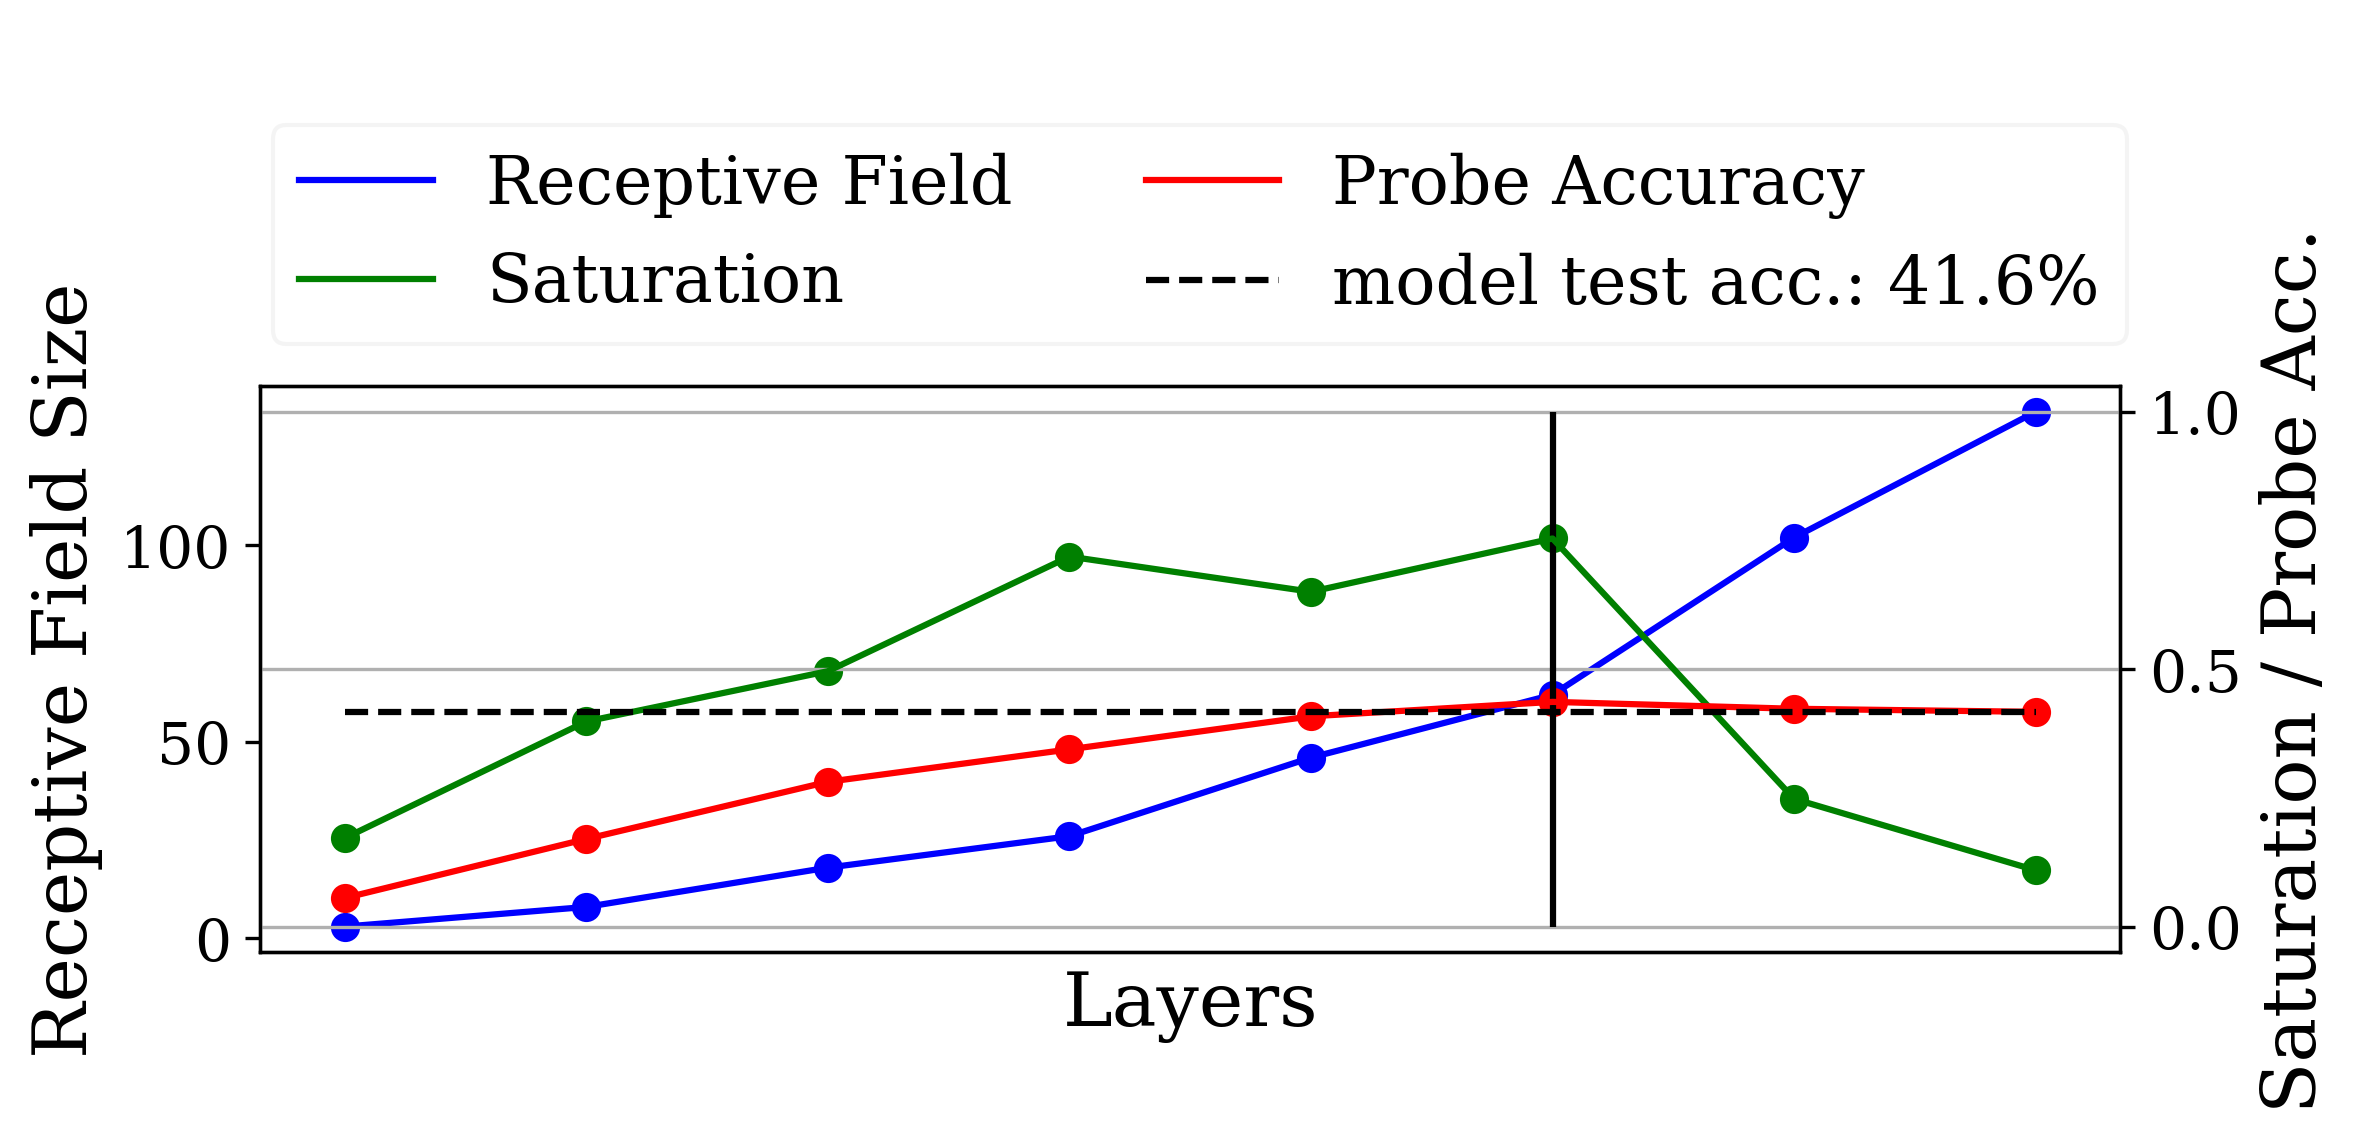

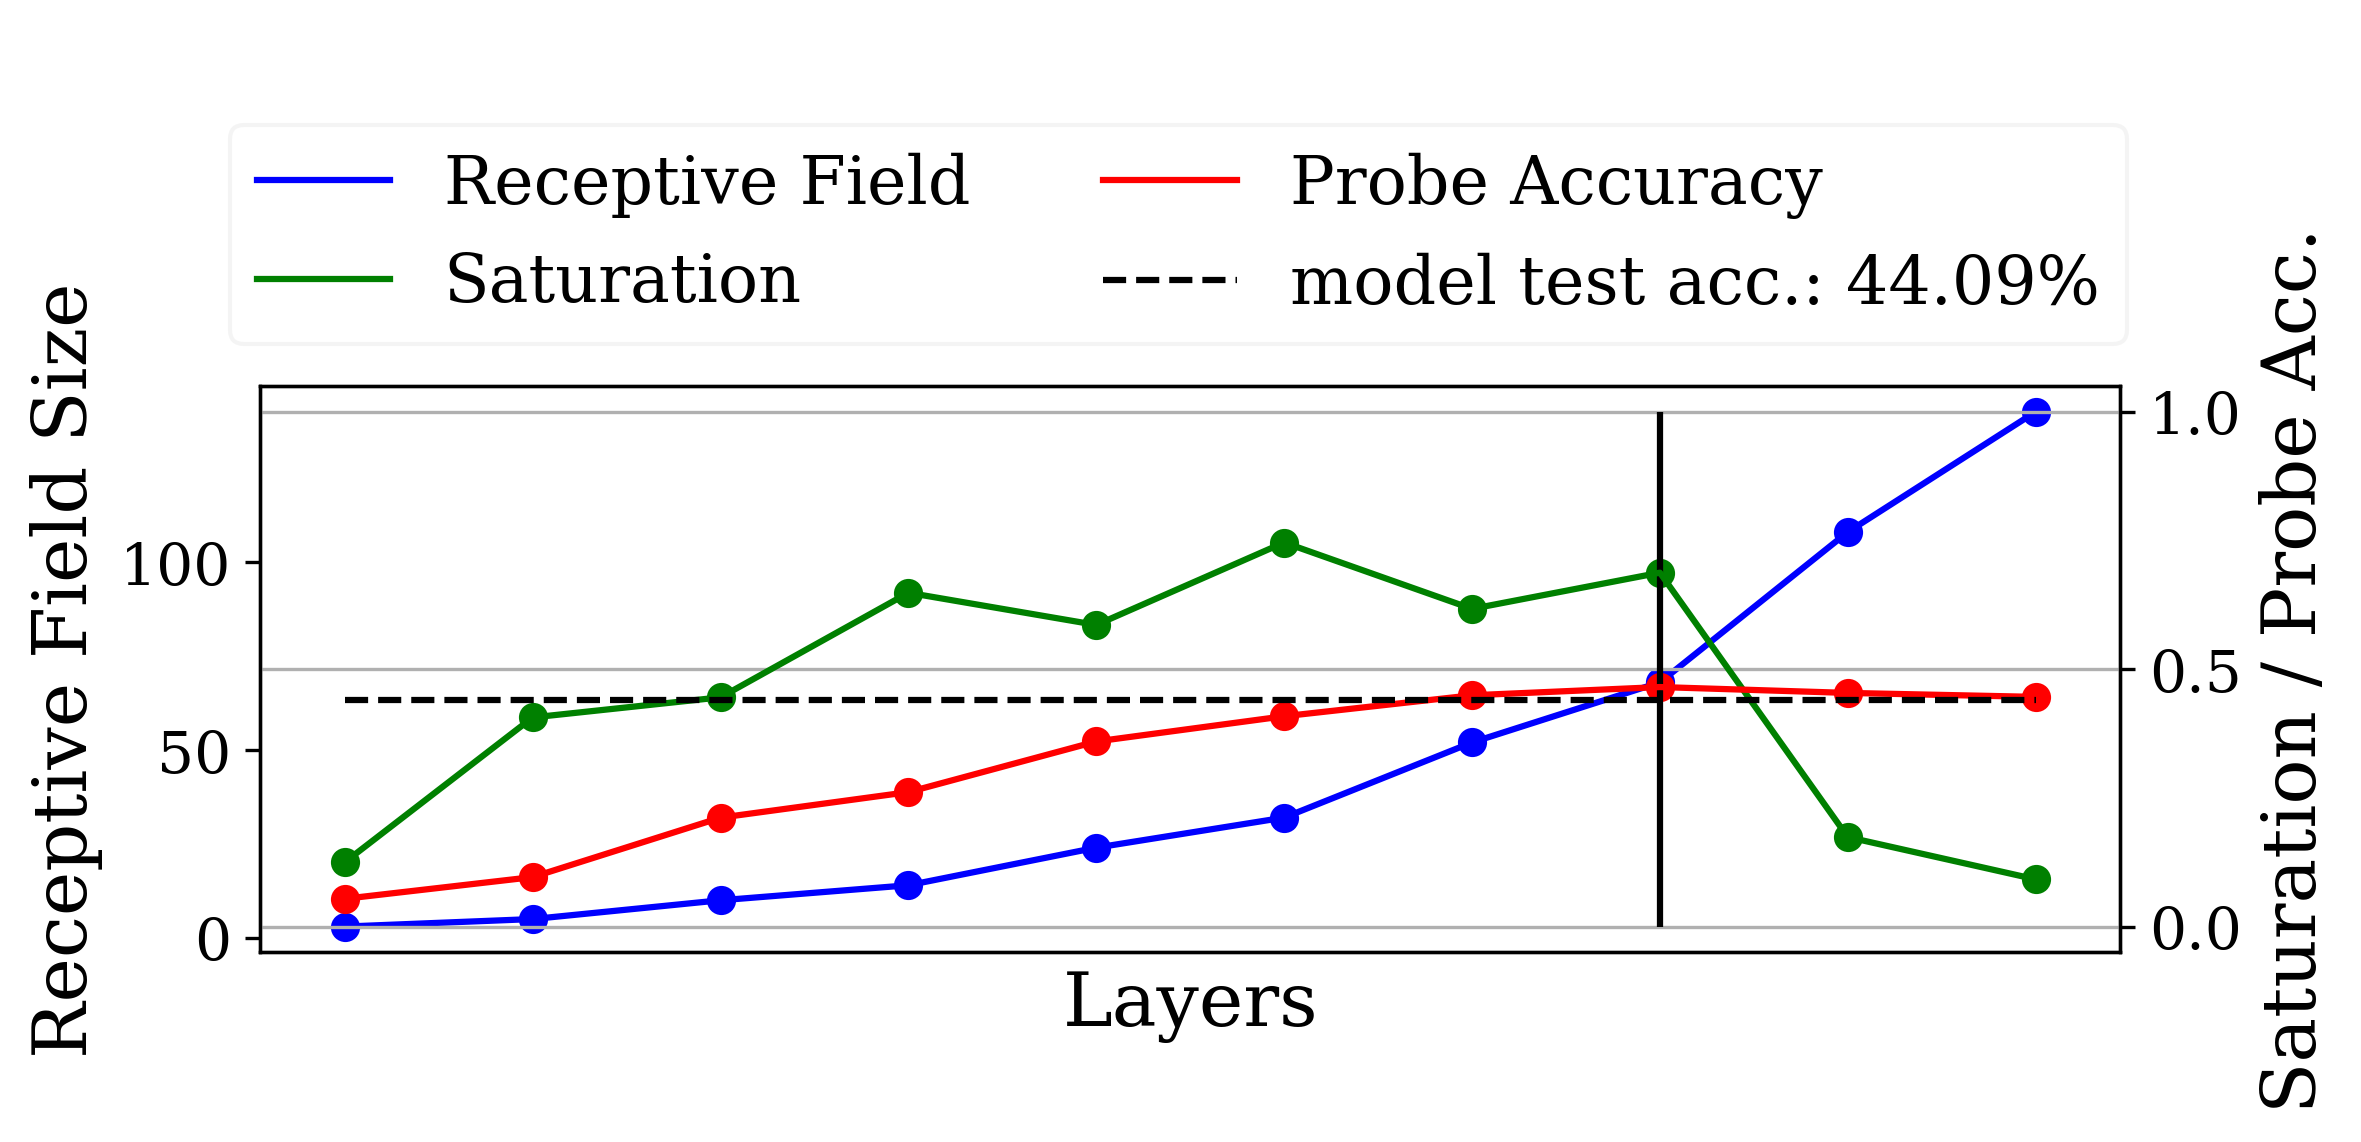

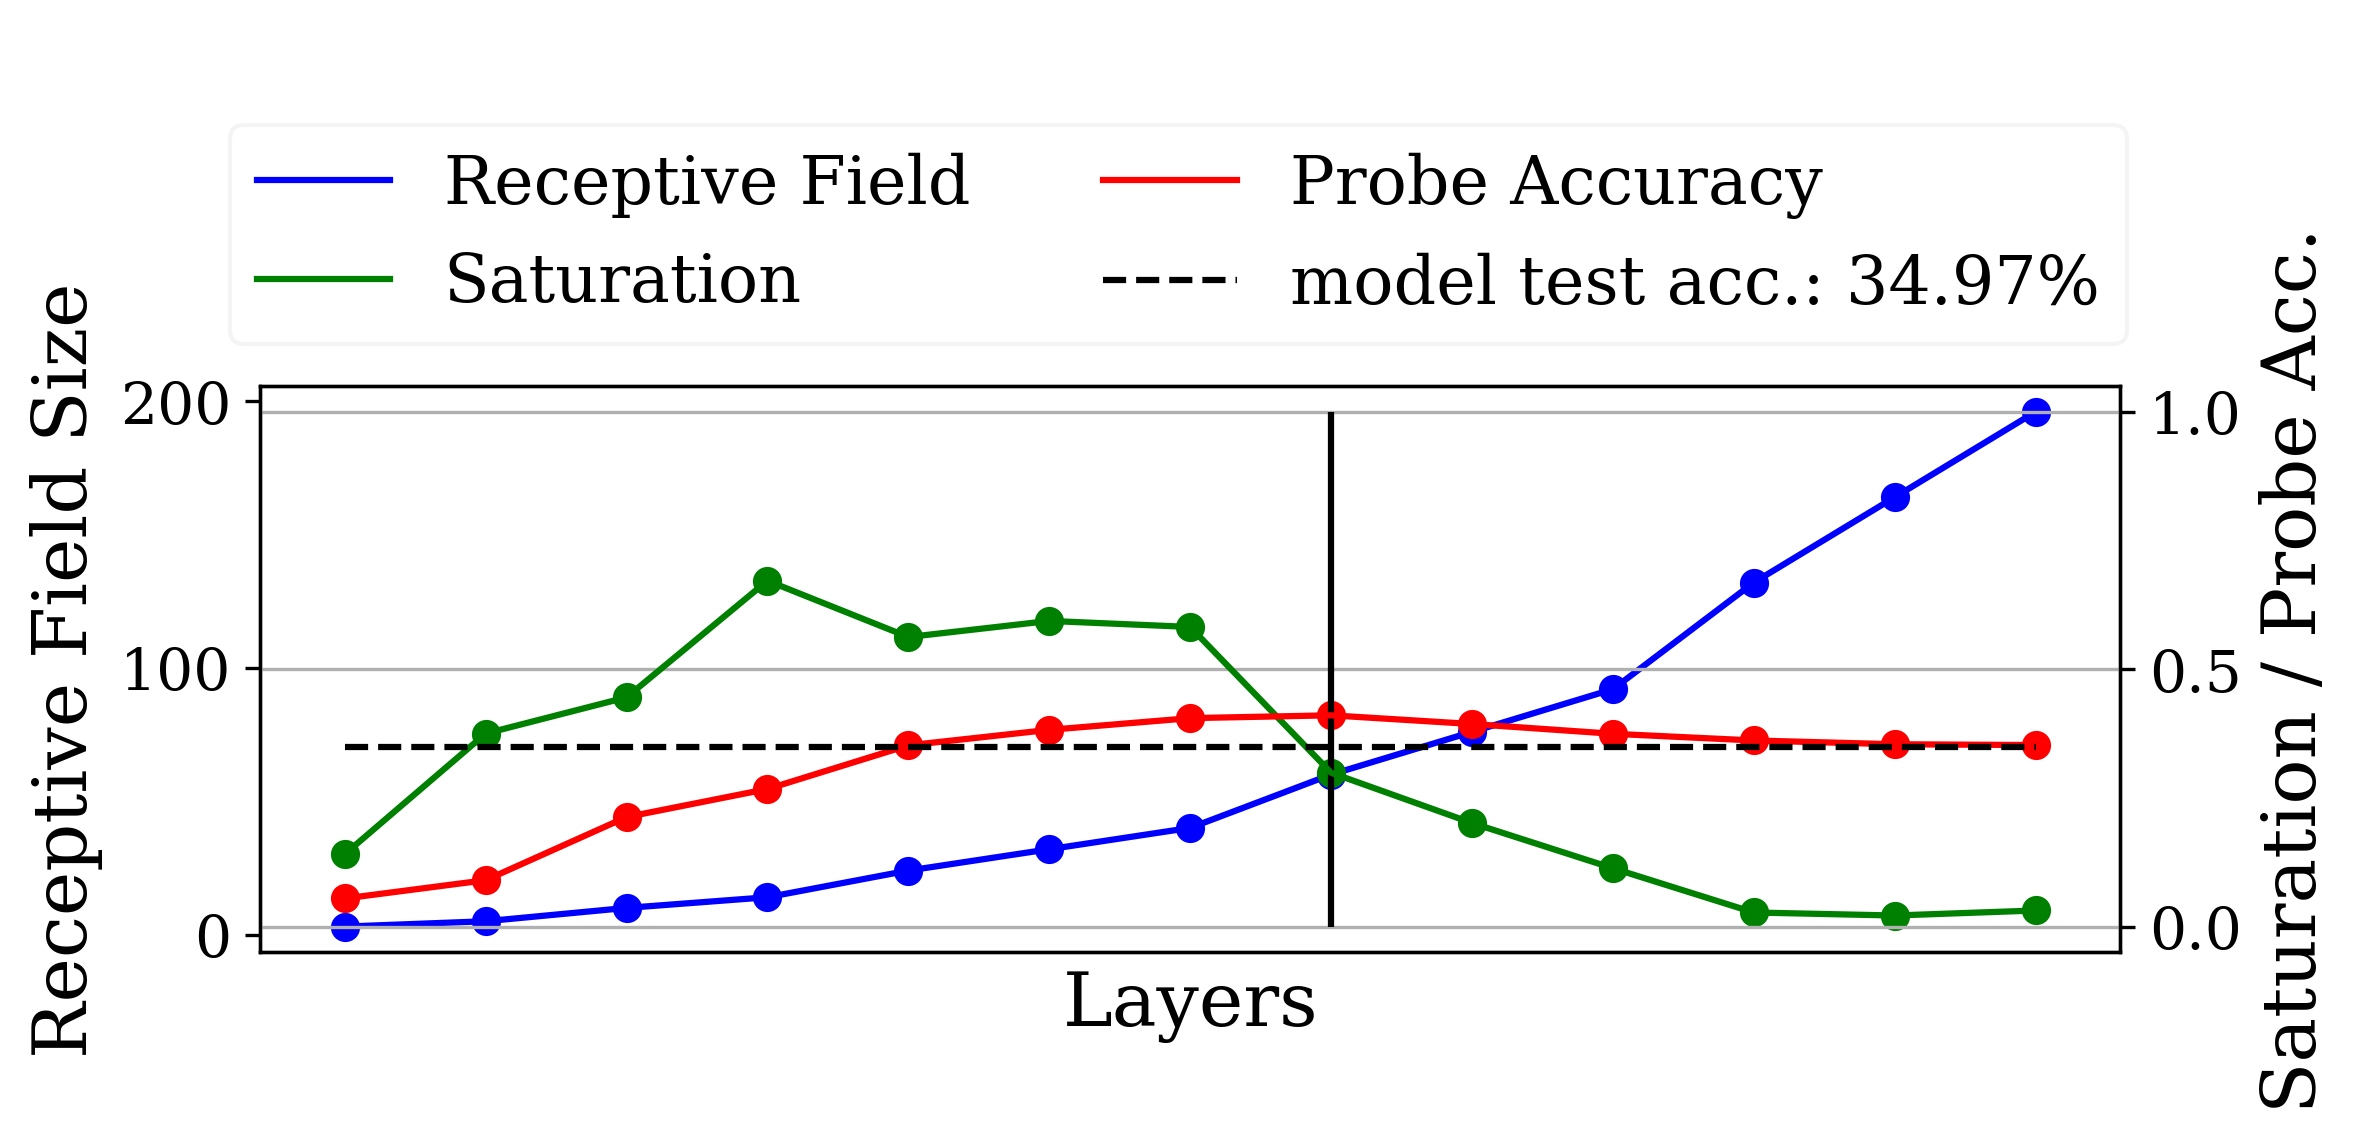

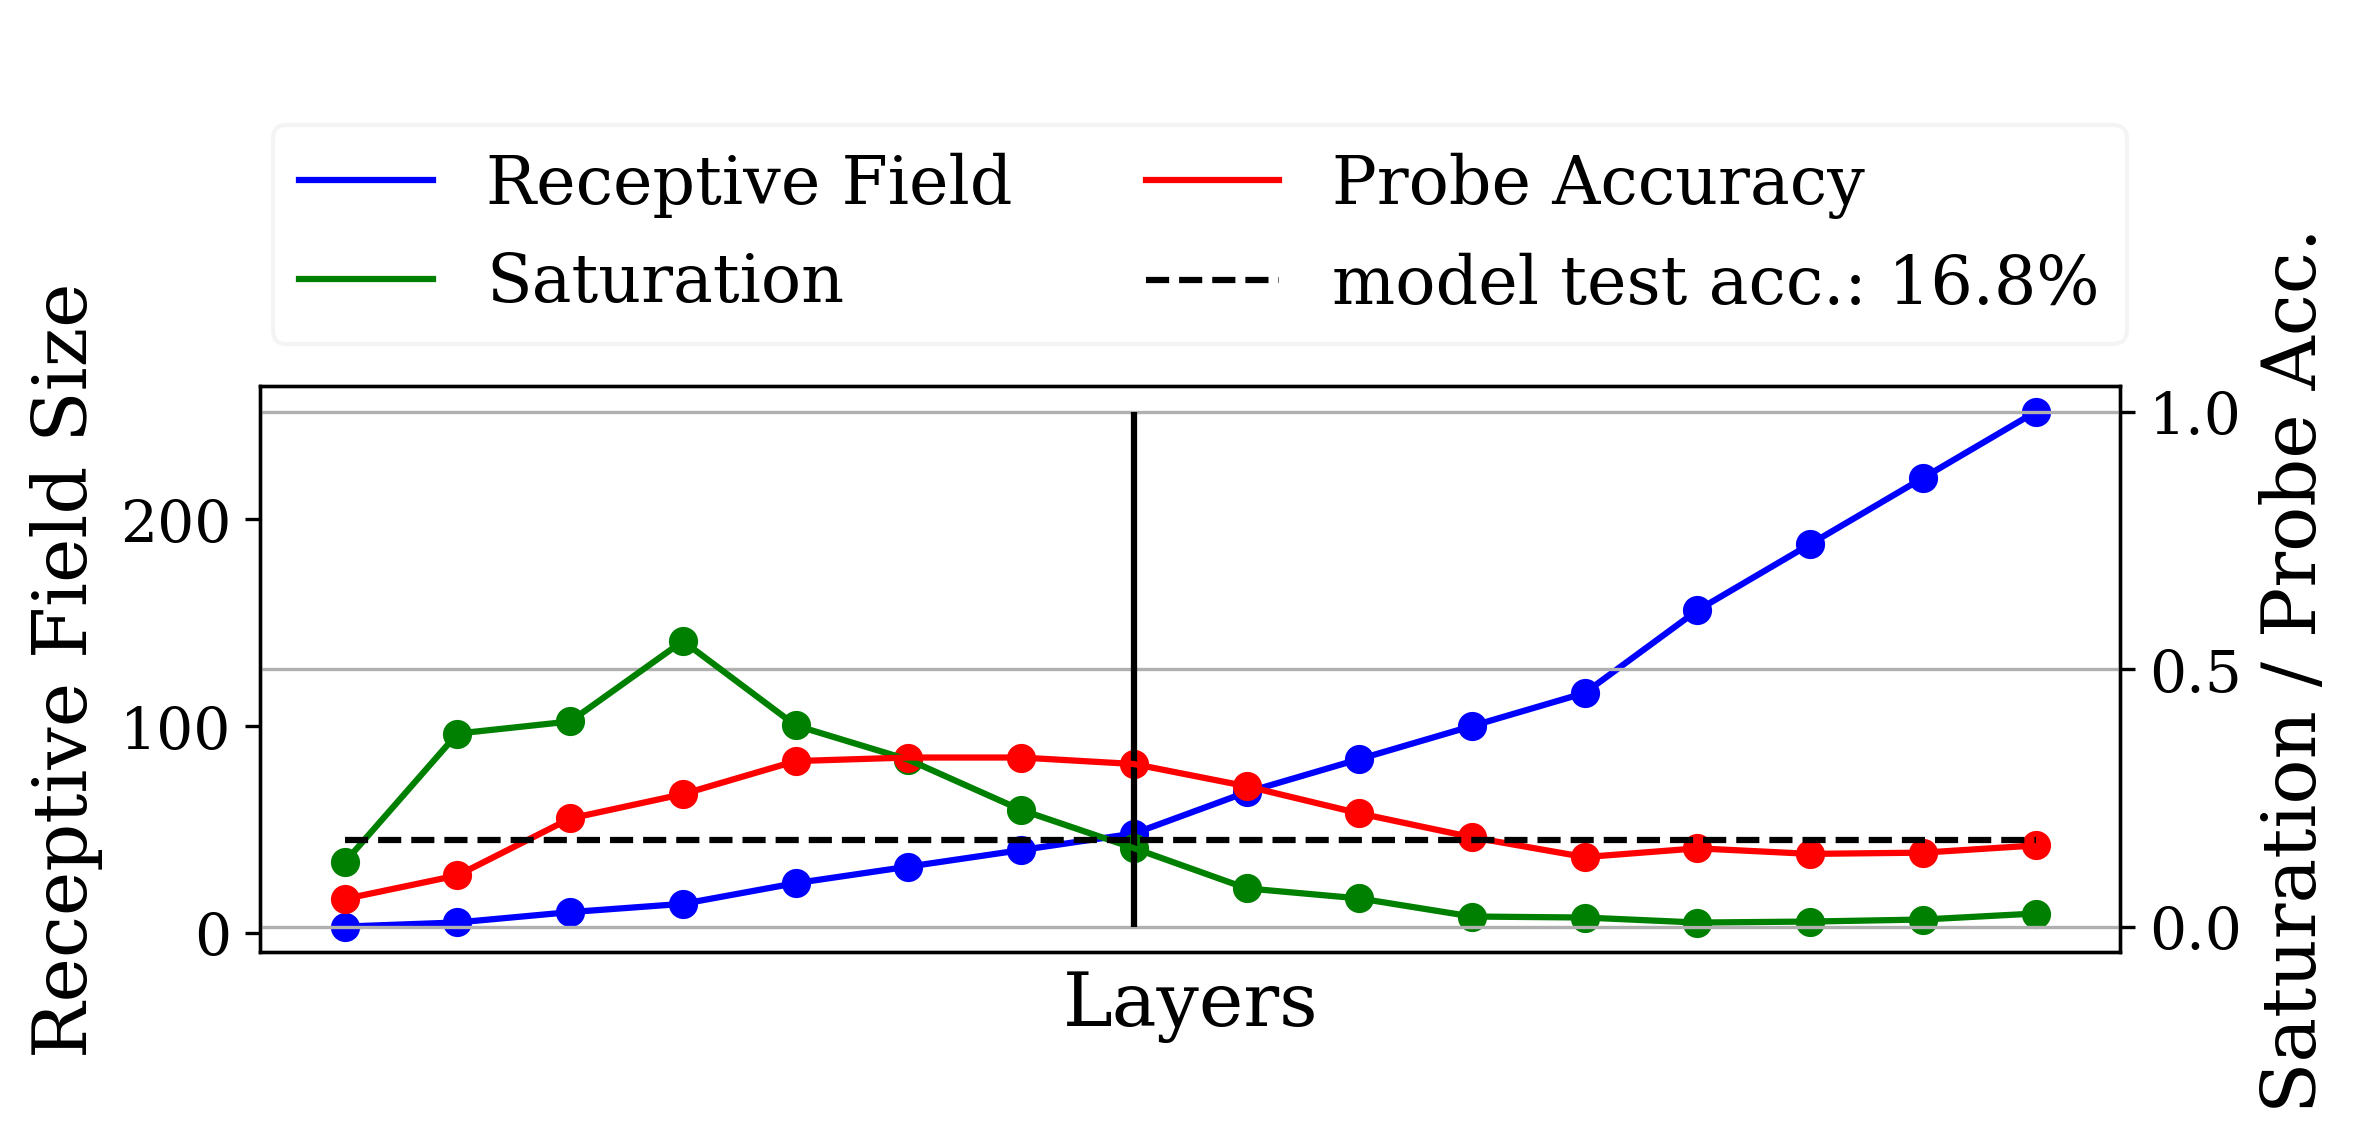

In [6]:
for model in ["VGG11", "VGG13", "VGG16", "VGG19"]:
    dataset = 'MNIST'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

### Figure 7

17 17 21
33 33 37
49 49 50


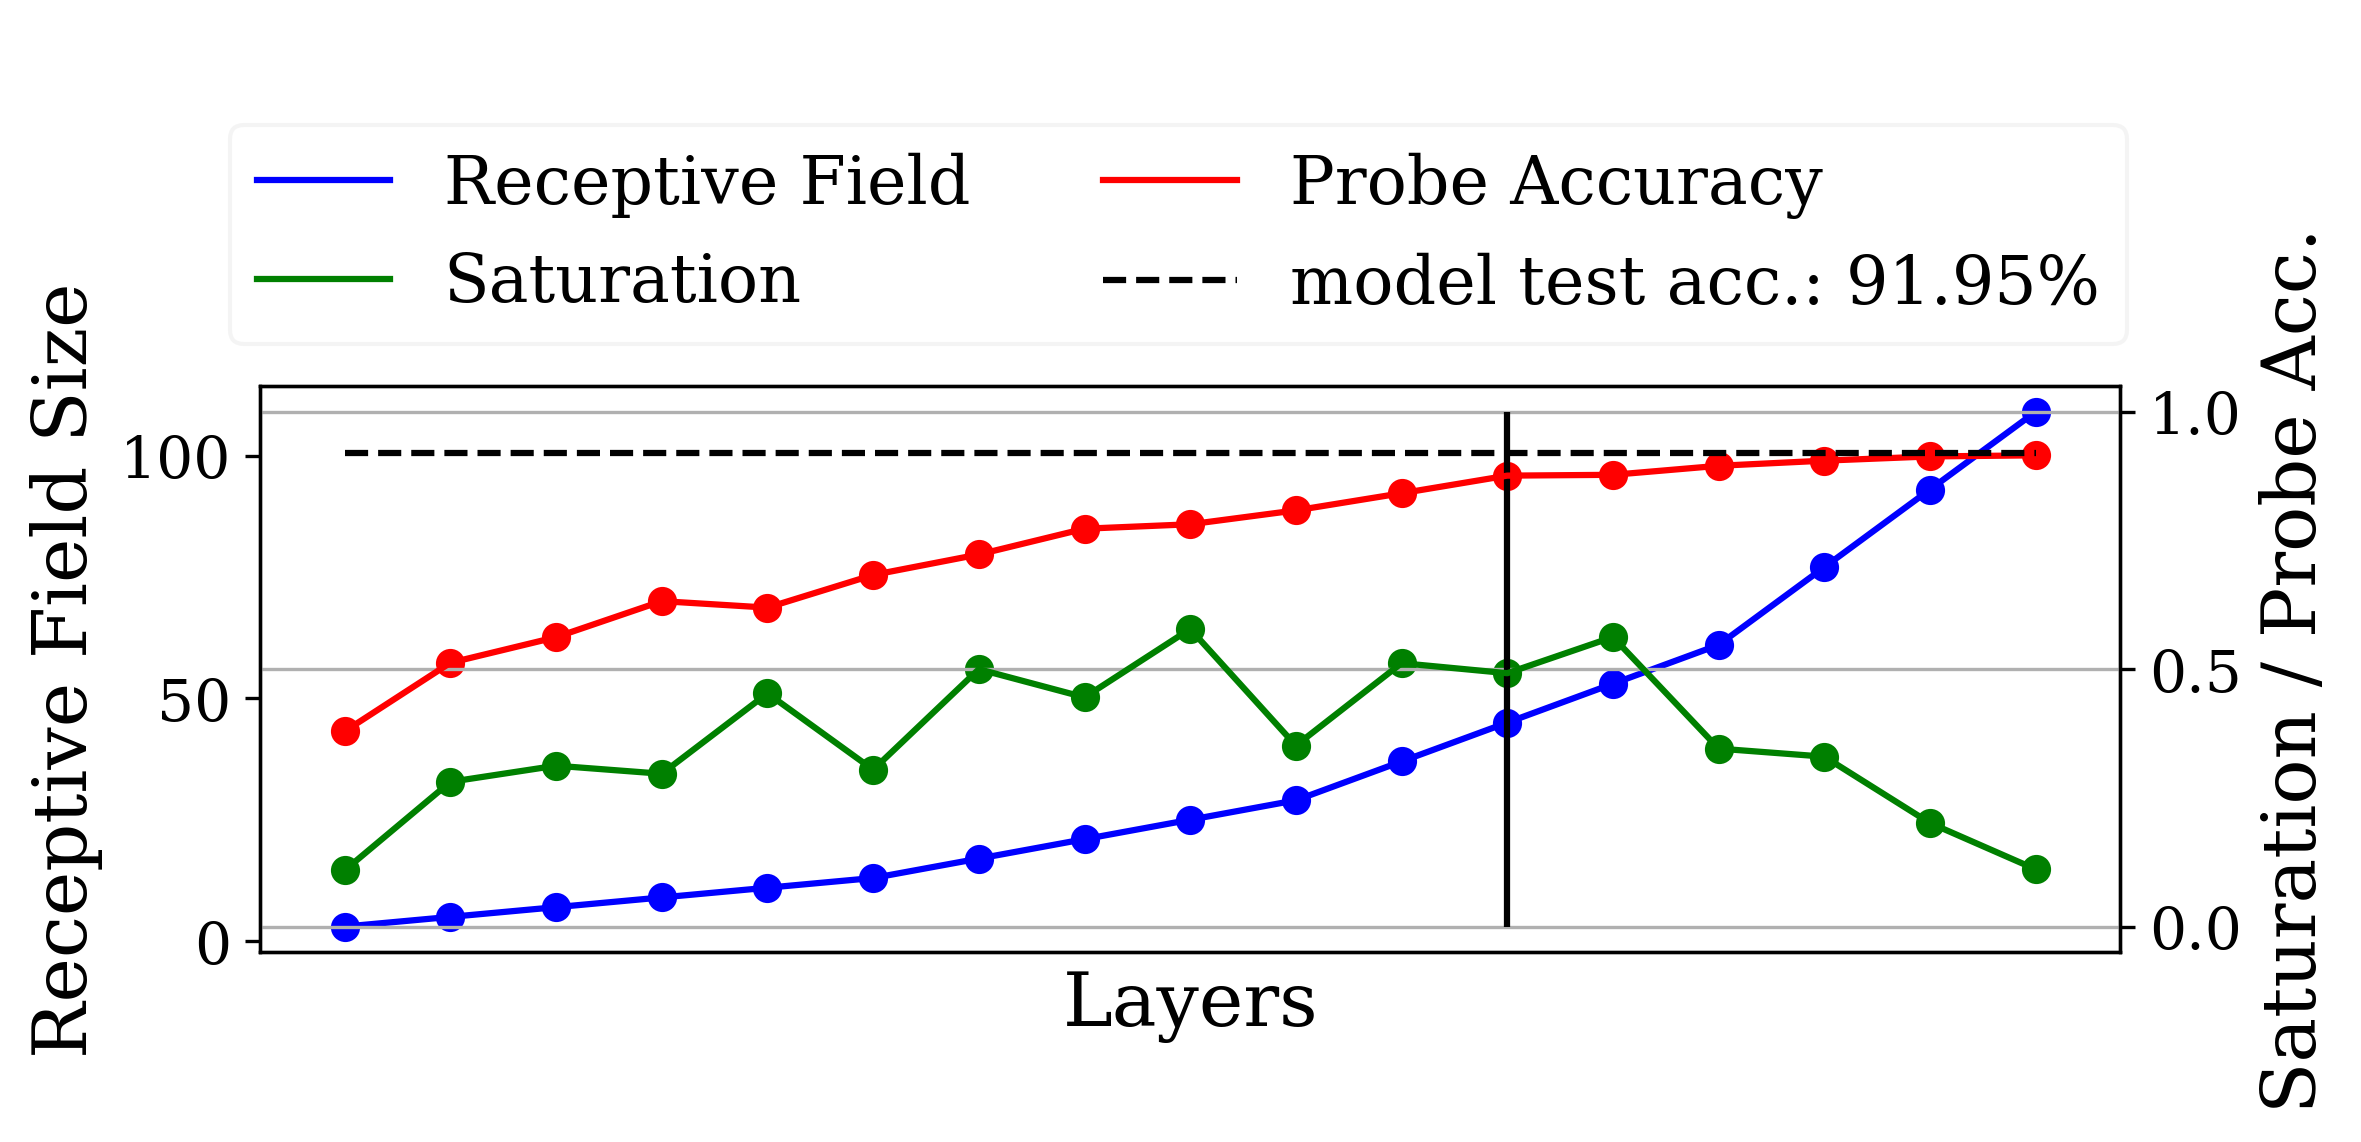

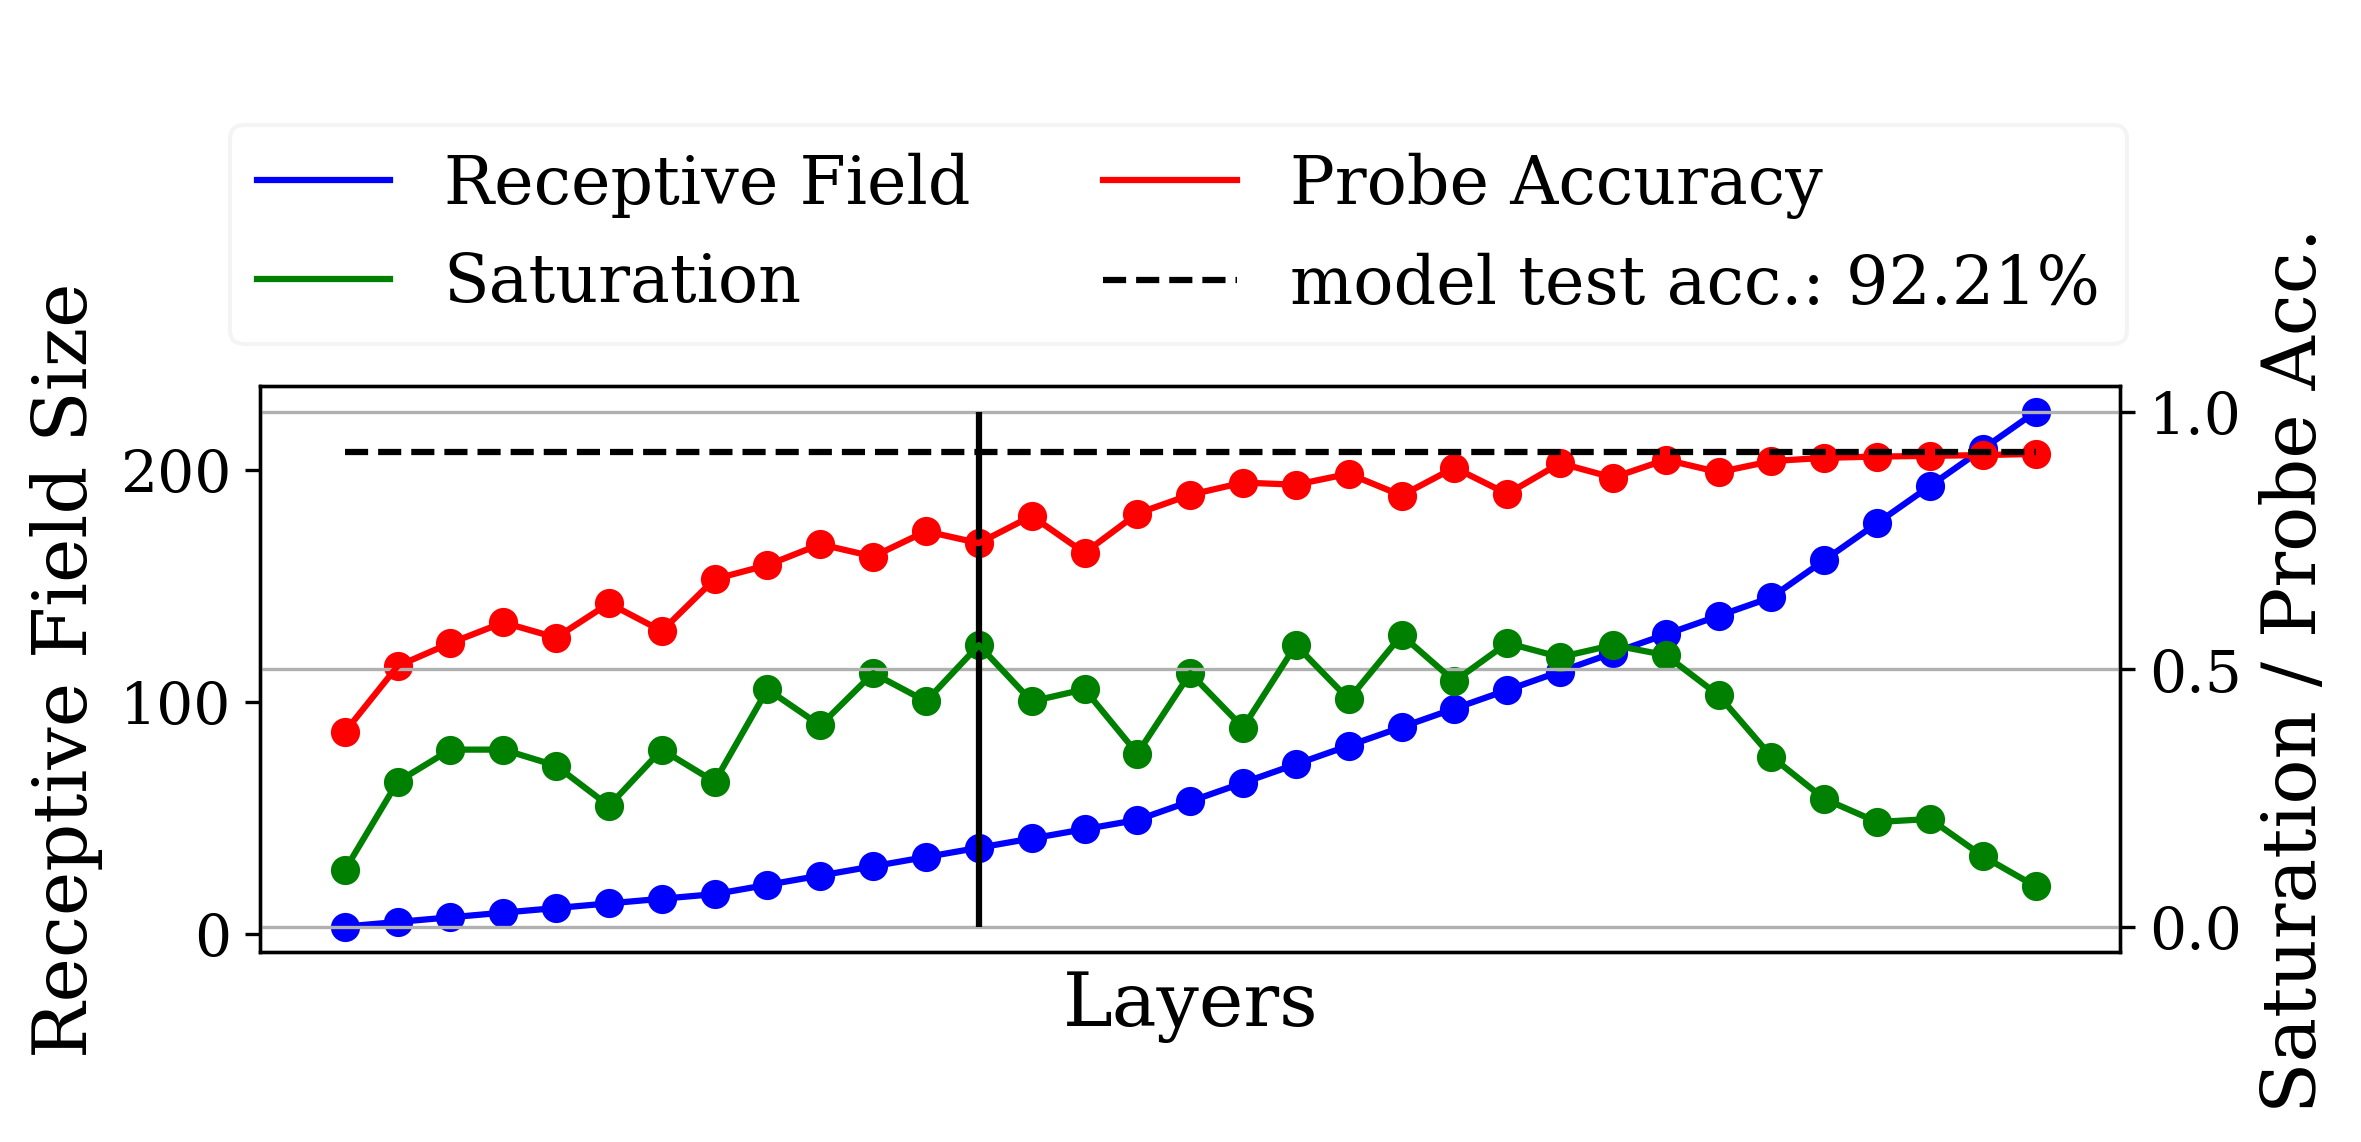

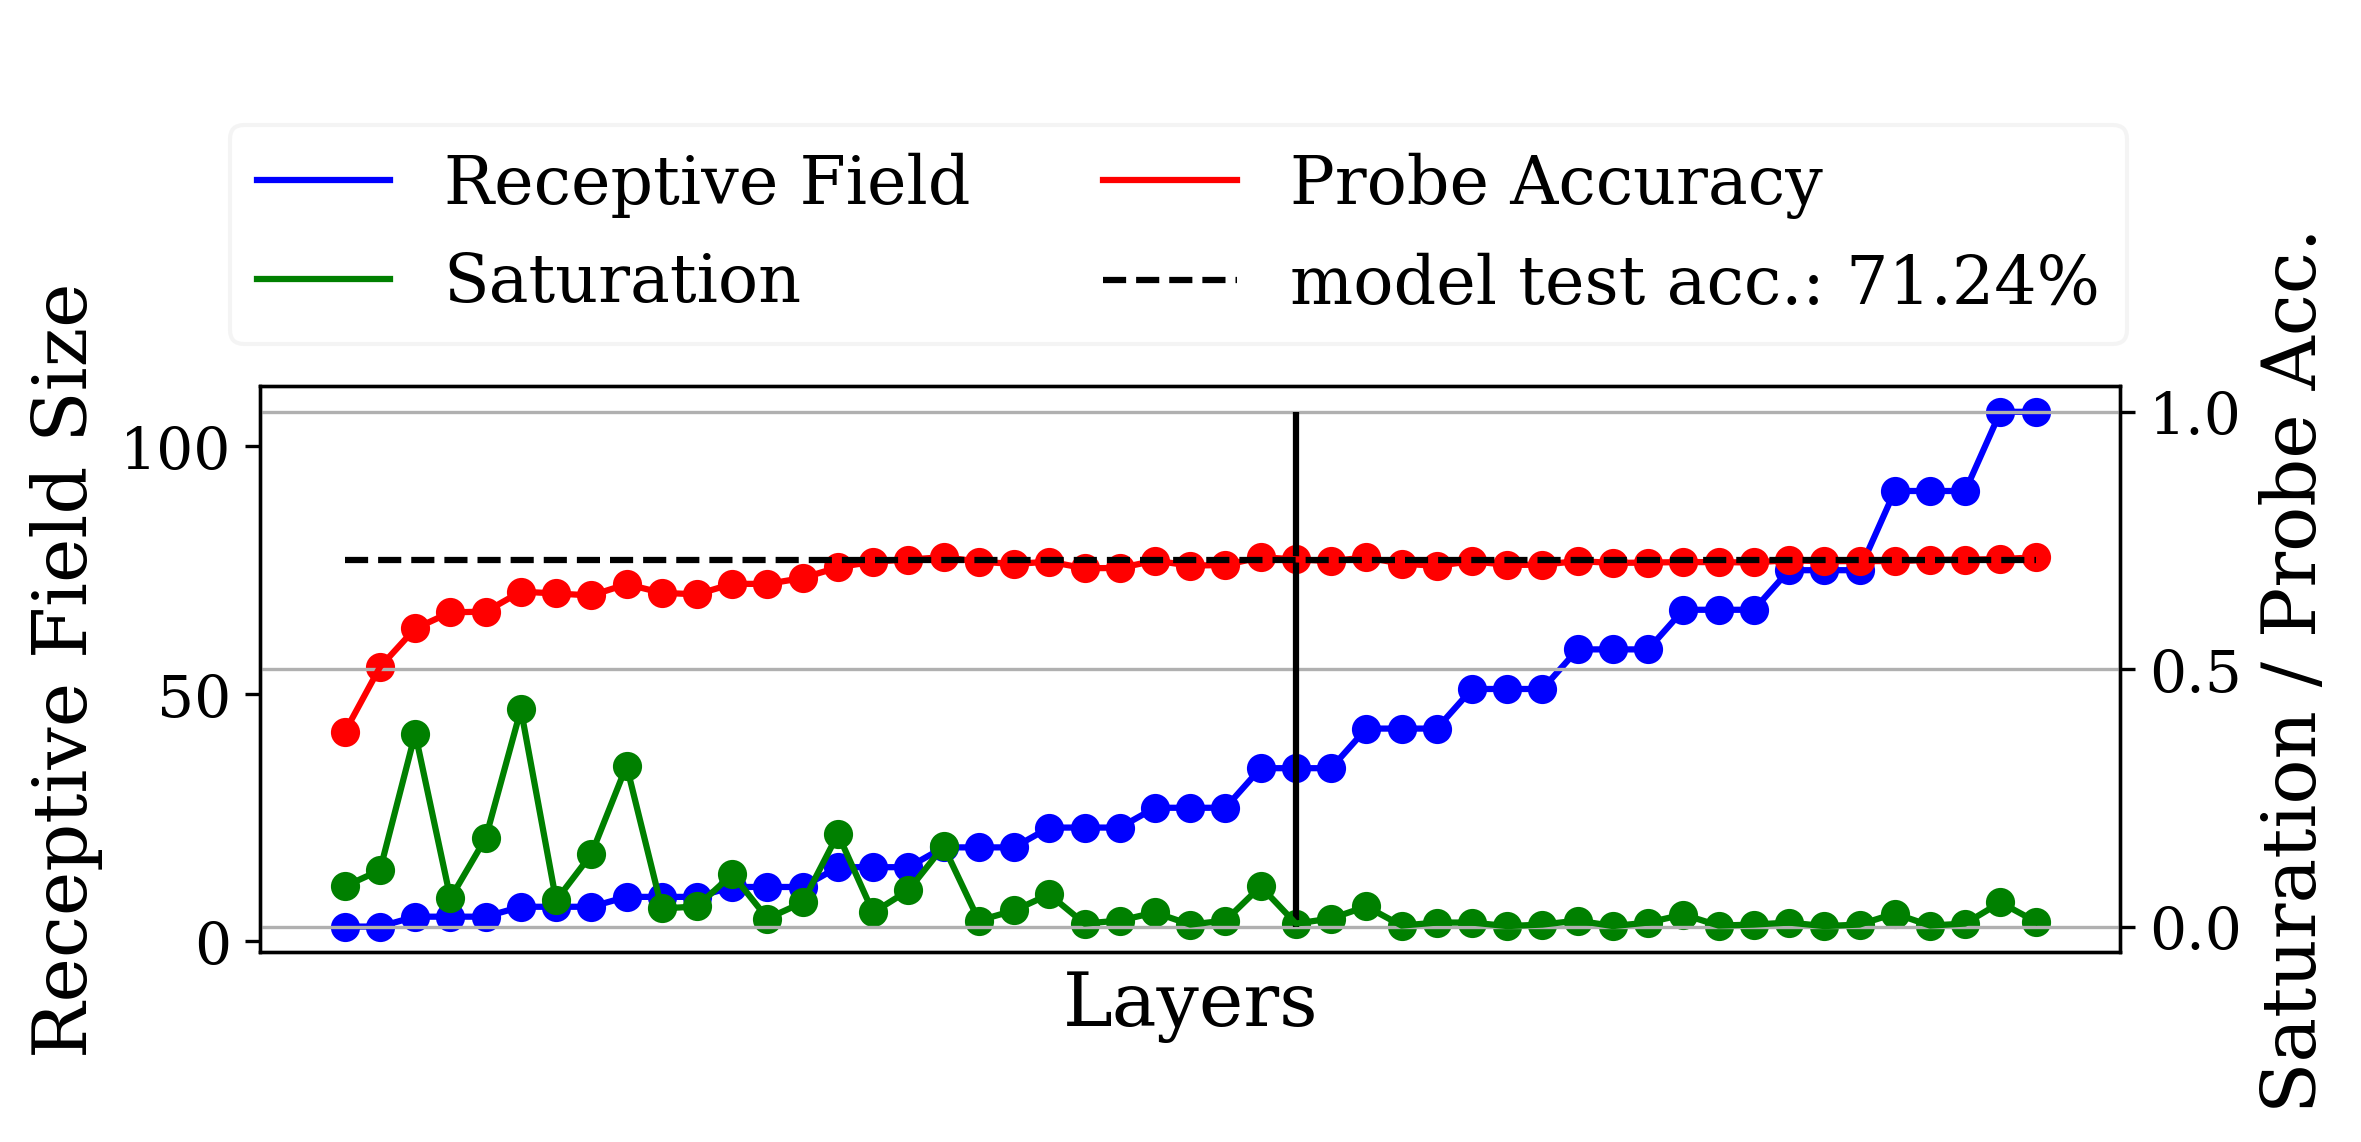

In [7]:
for model in ['ResNet18_PC', "ResNet34_PC", "ResNet50_PC"]:
    dataset = 'Cifar10'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

17 17 21
17 17 18
33 33 37
49 49 54
49 49 50


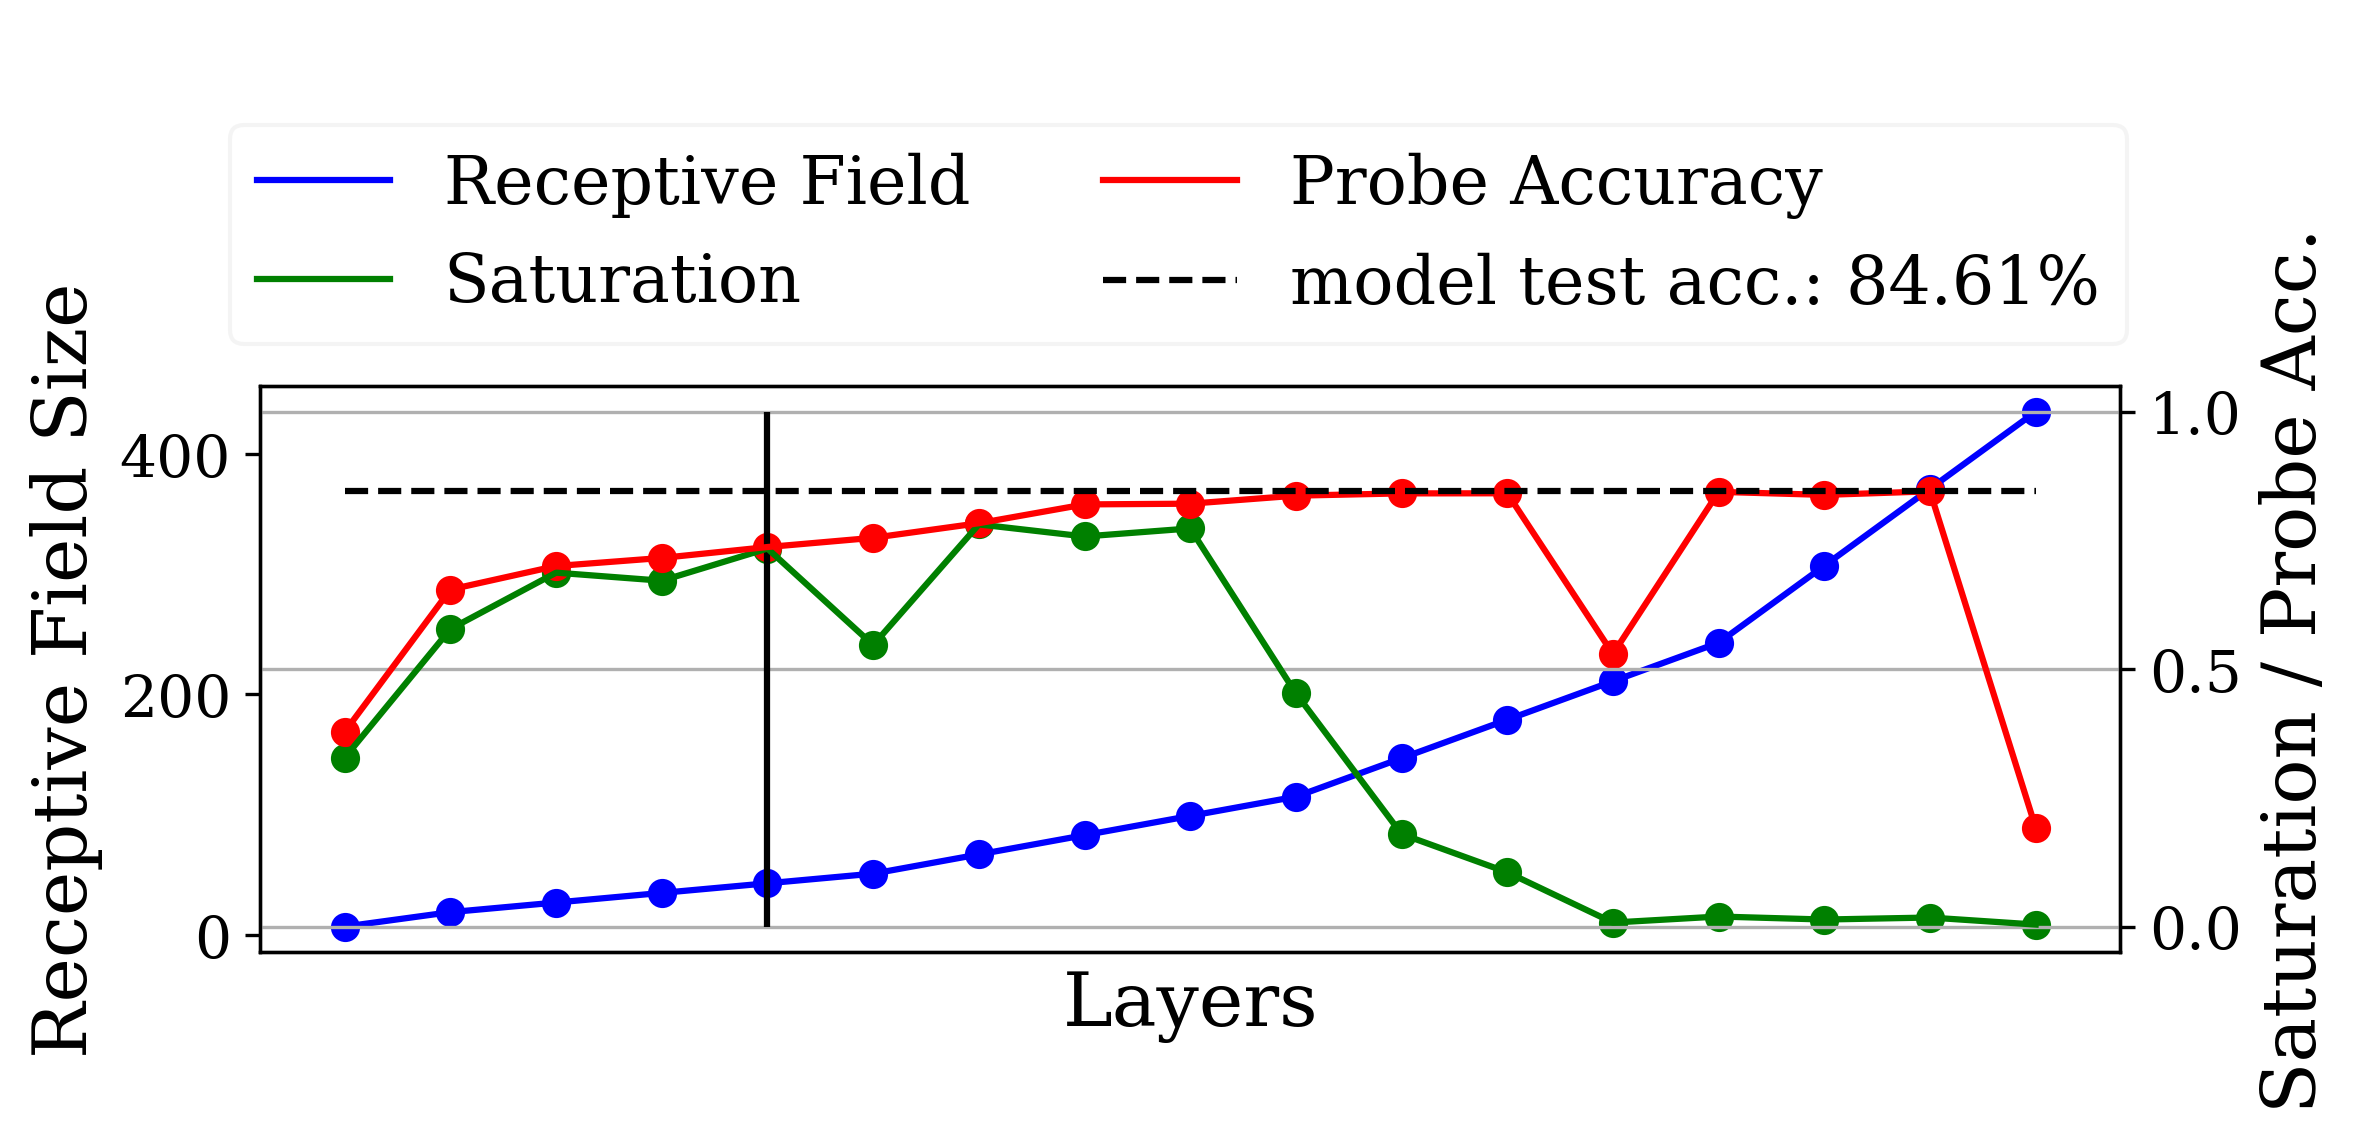

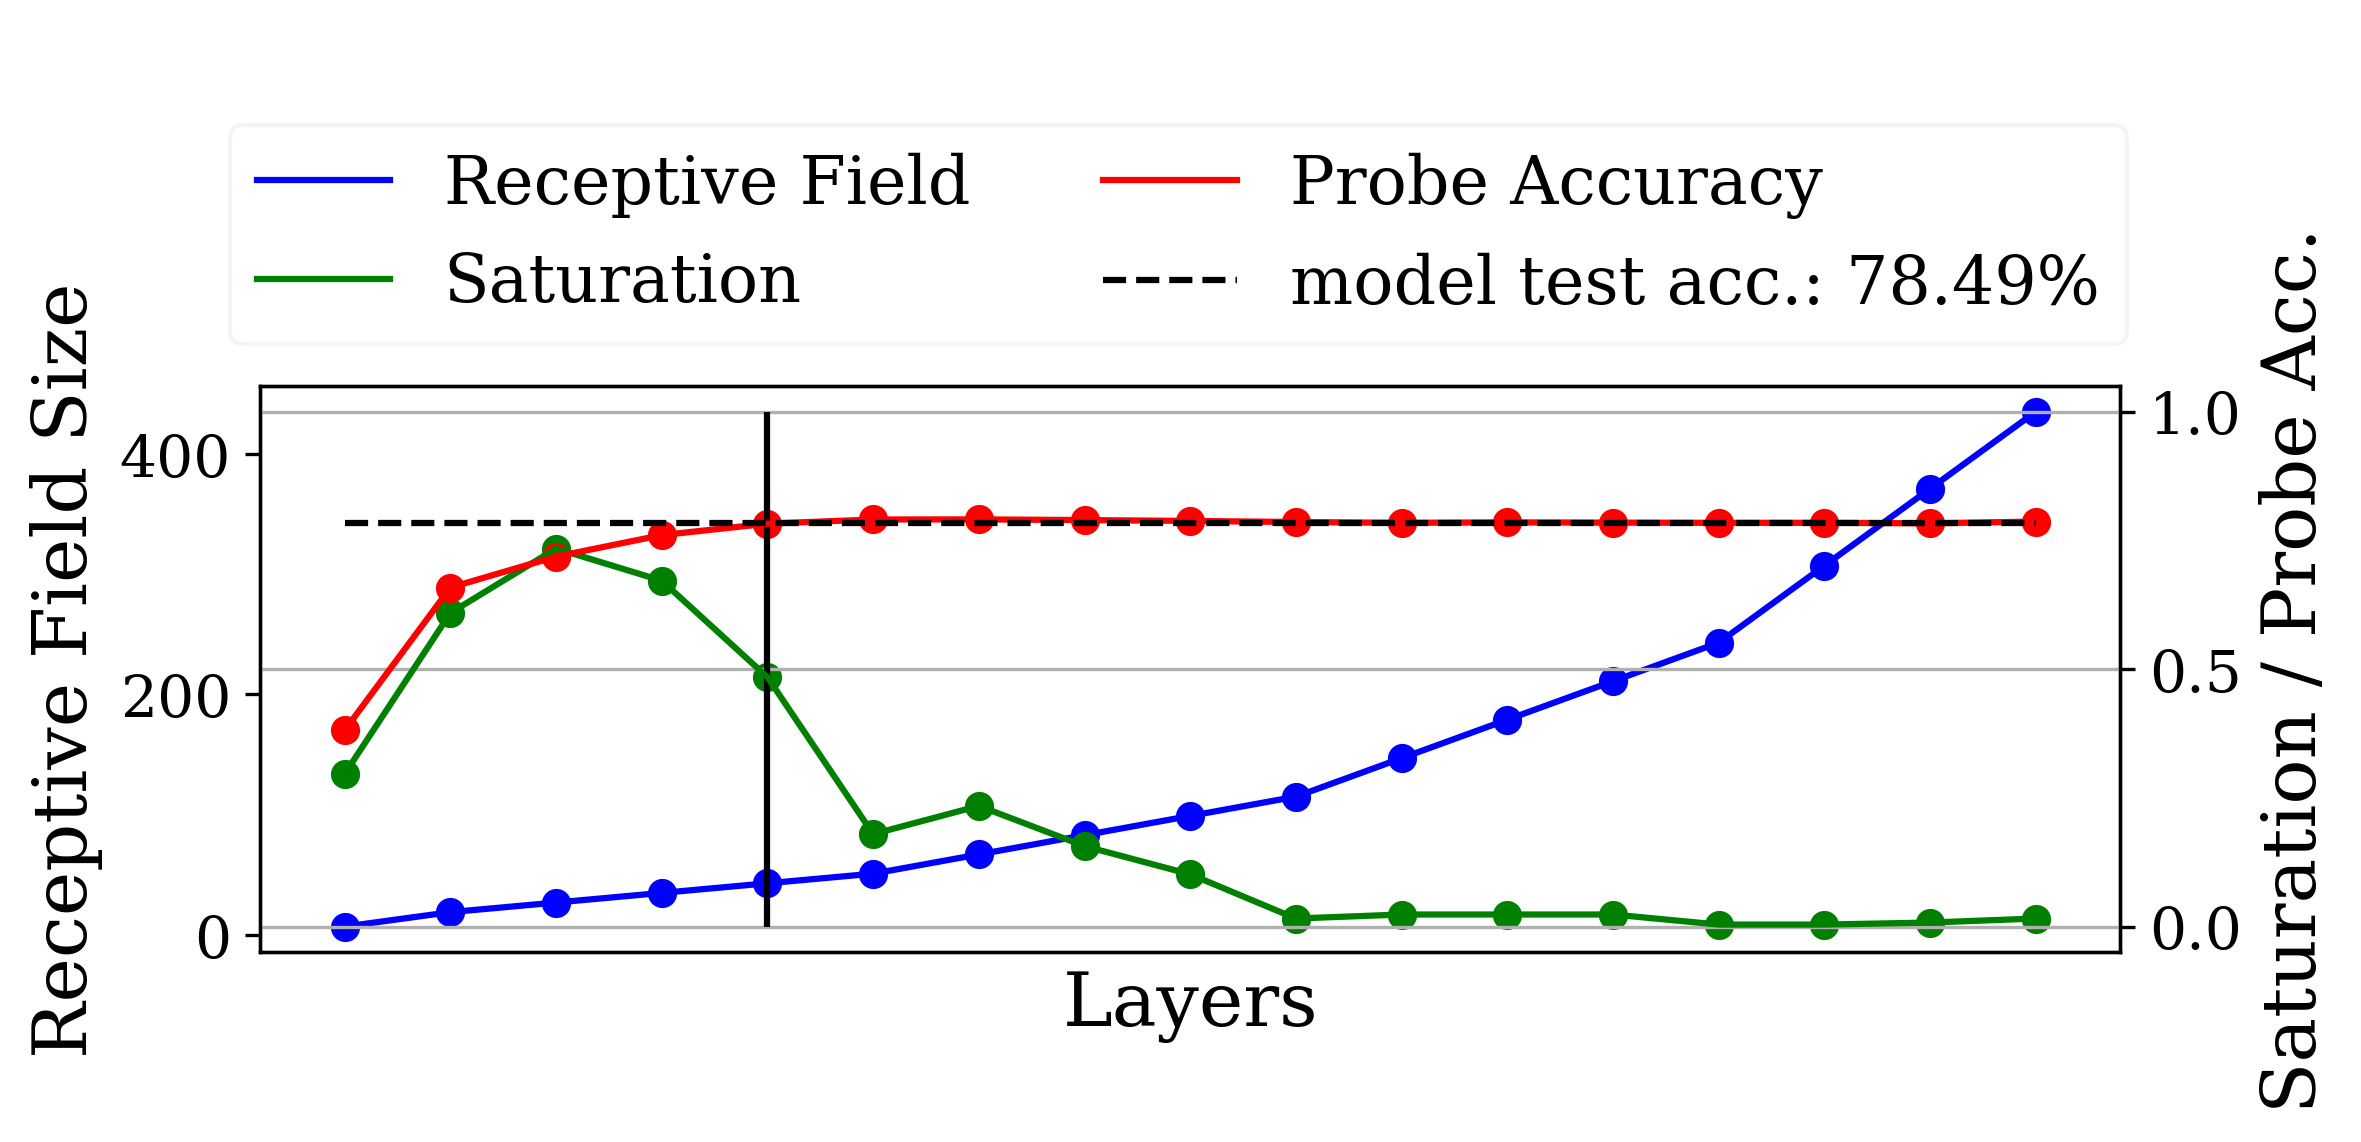

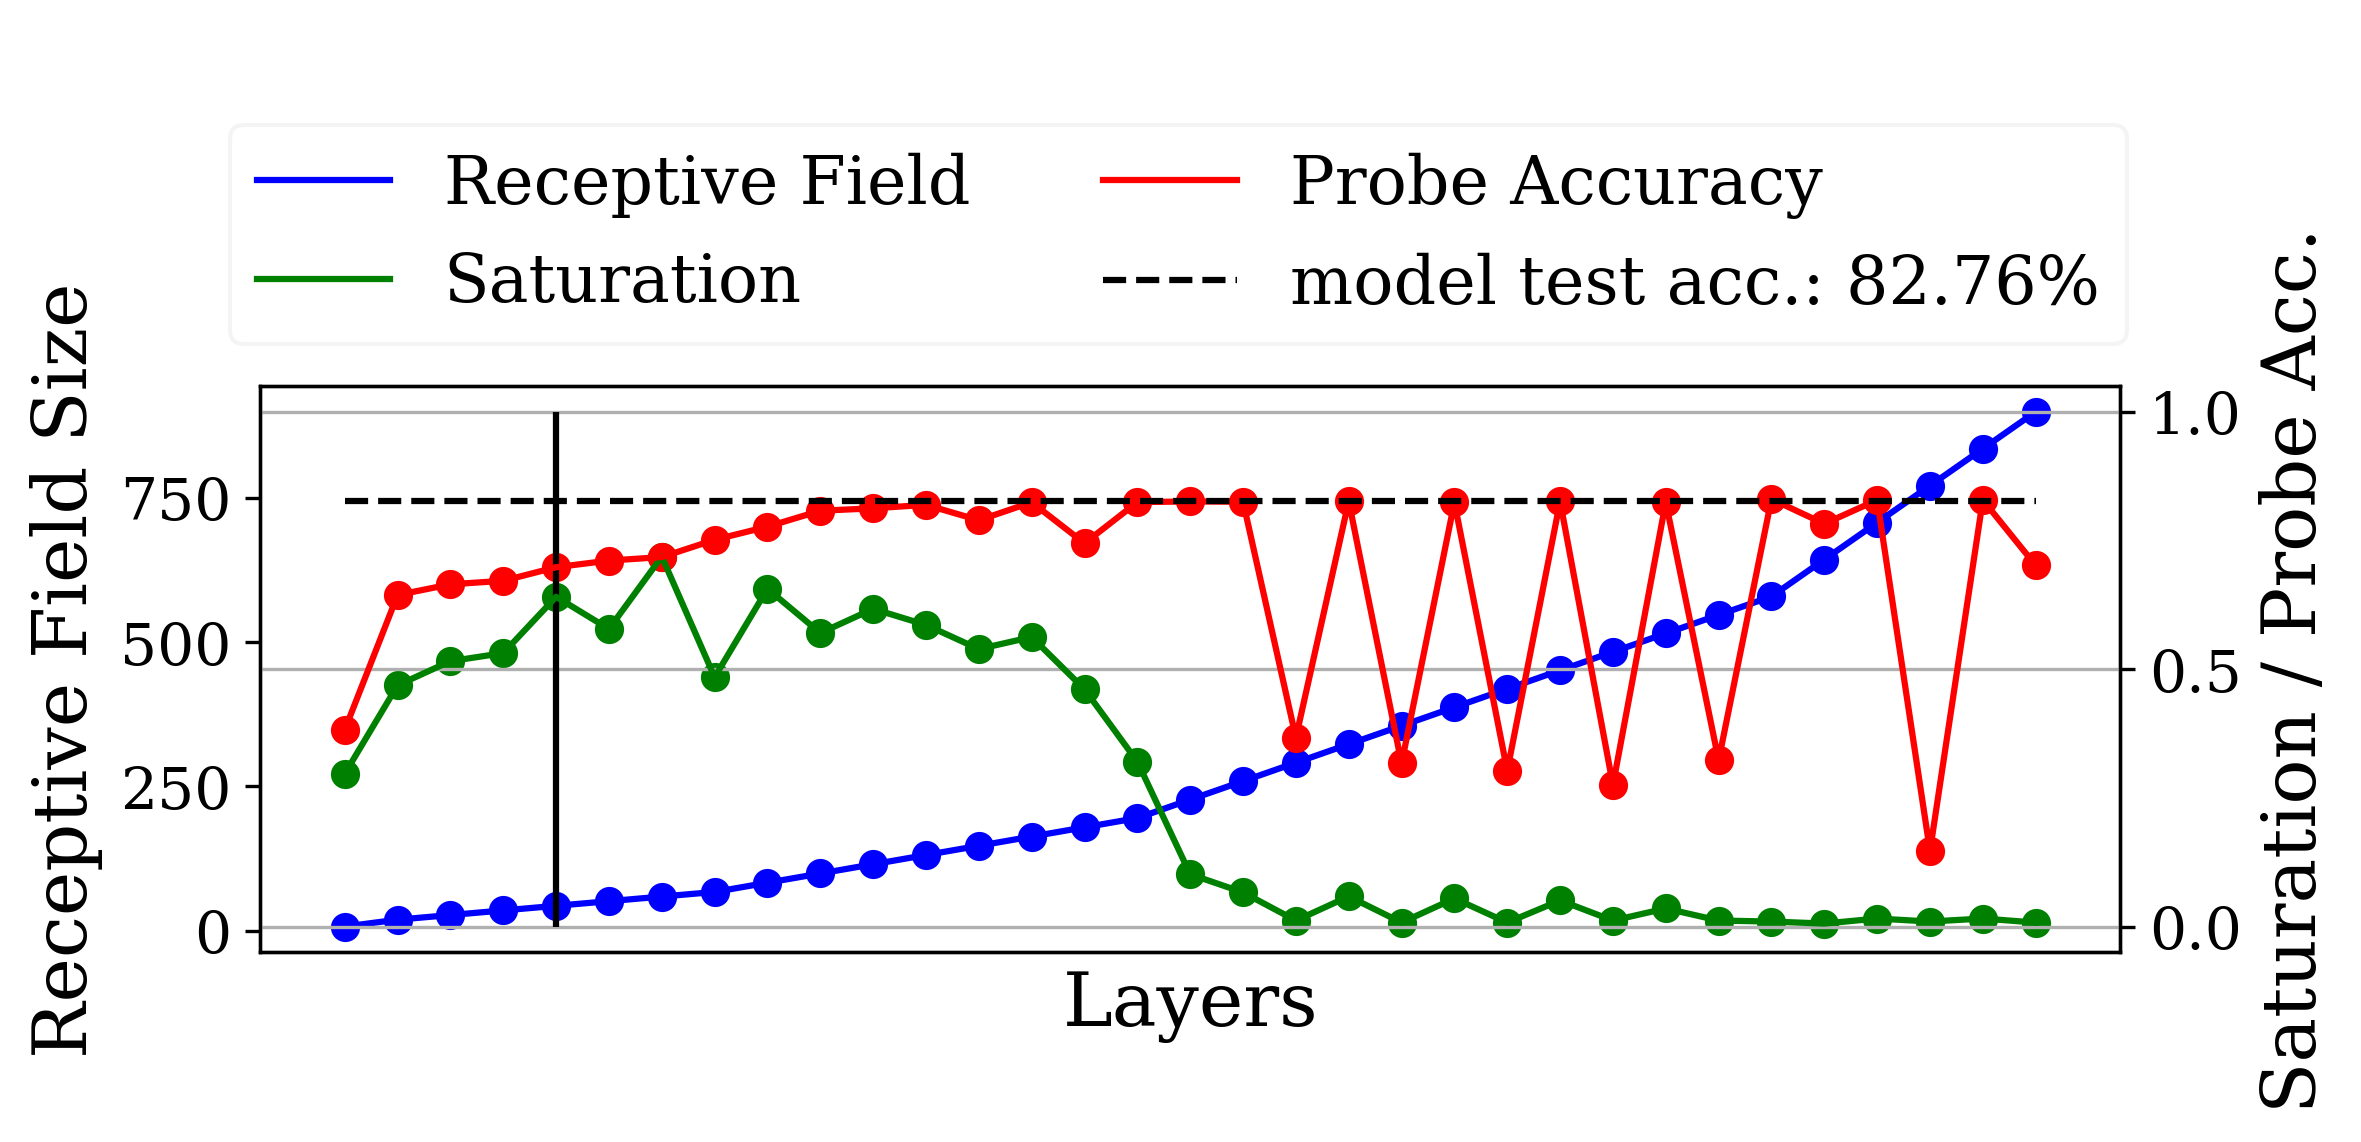

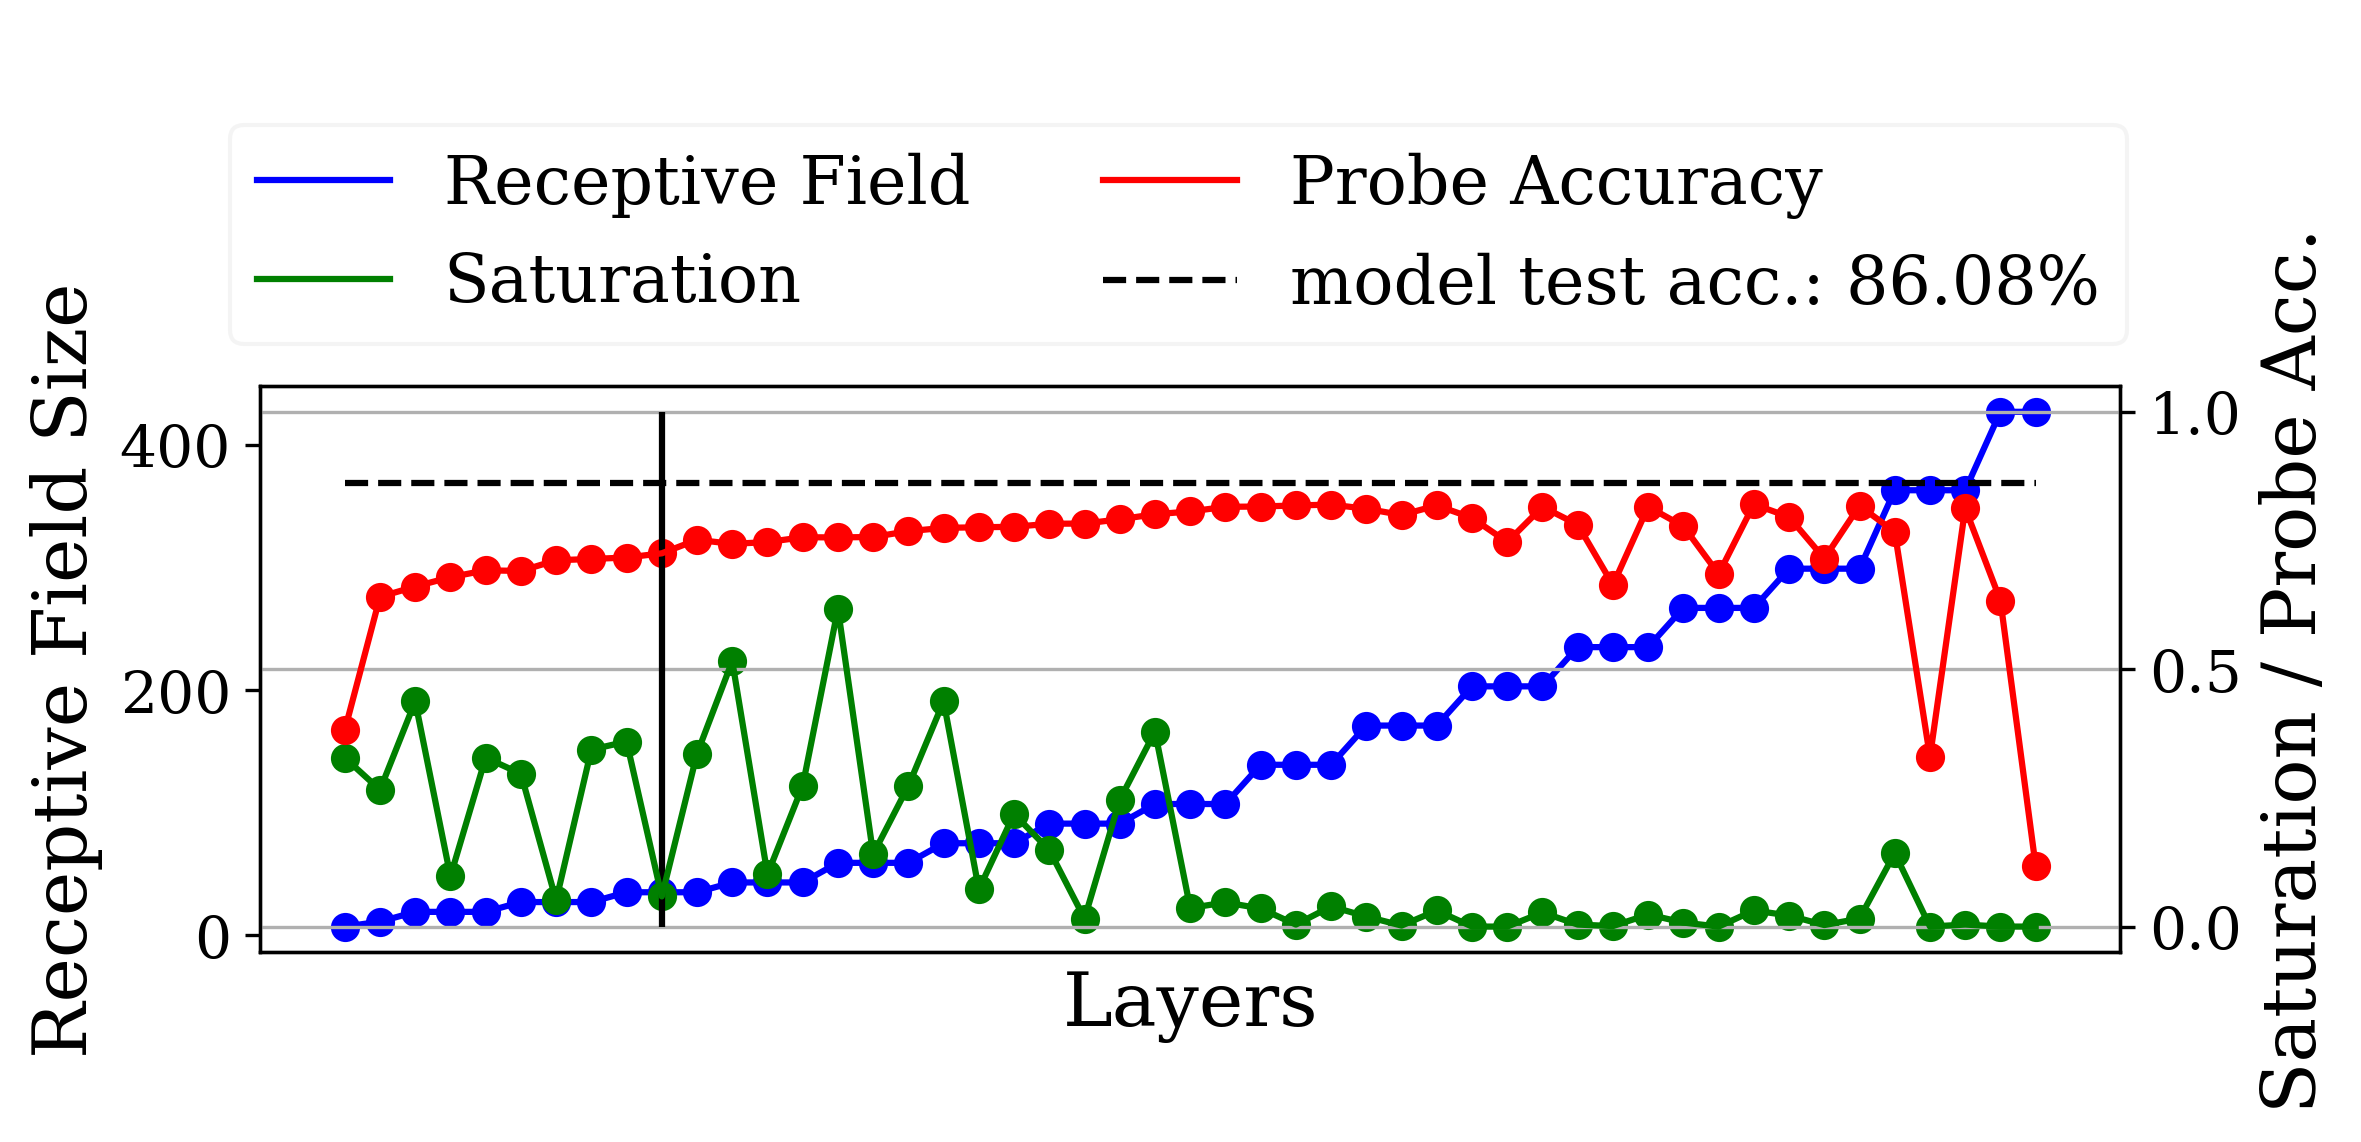

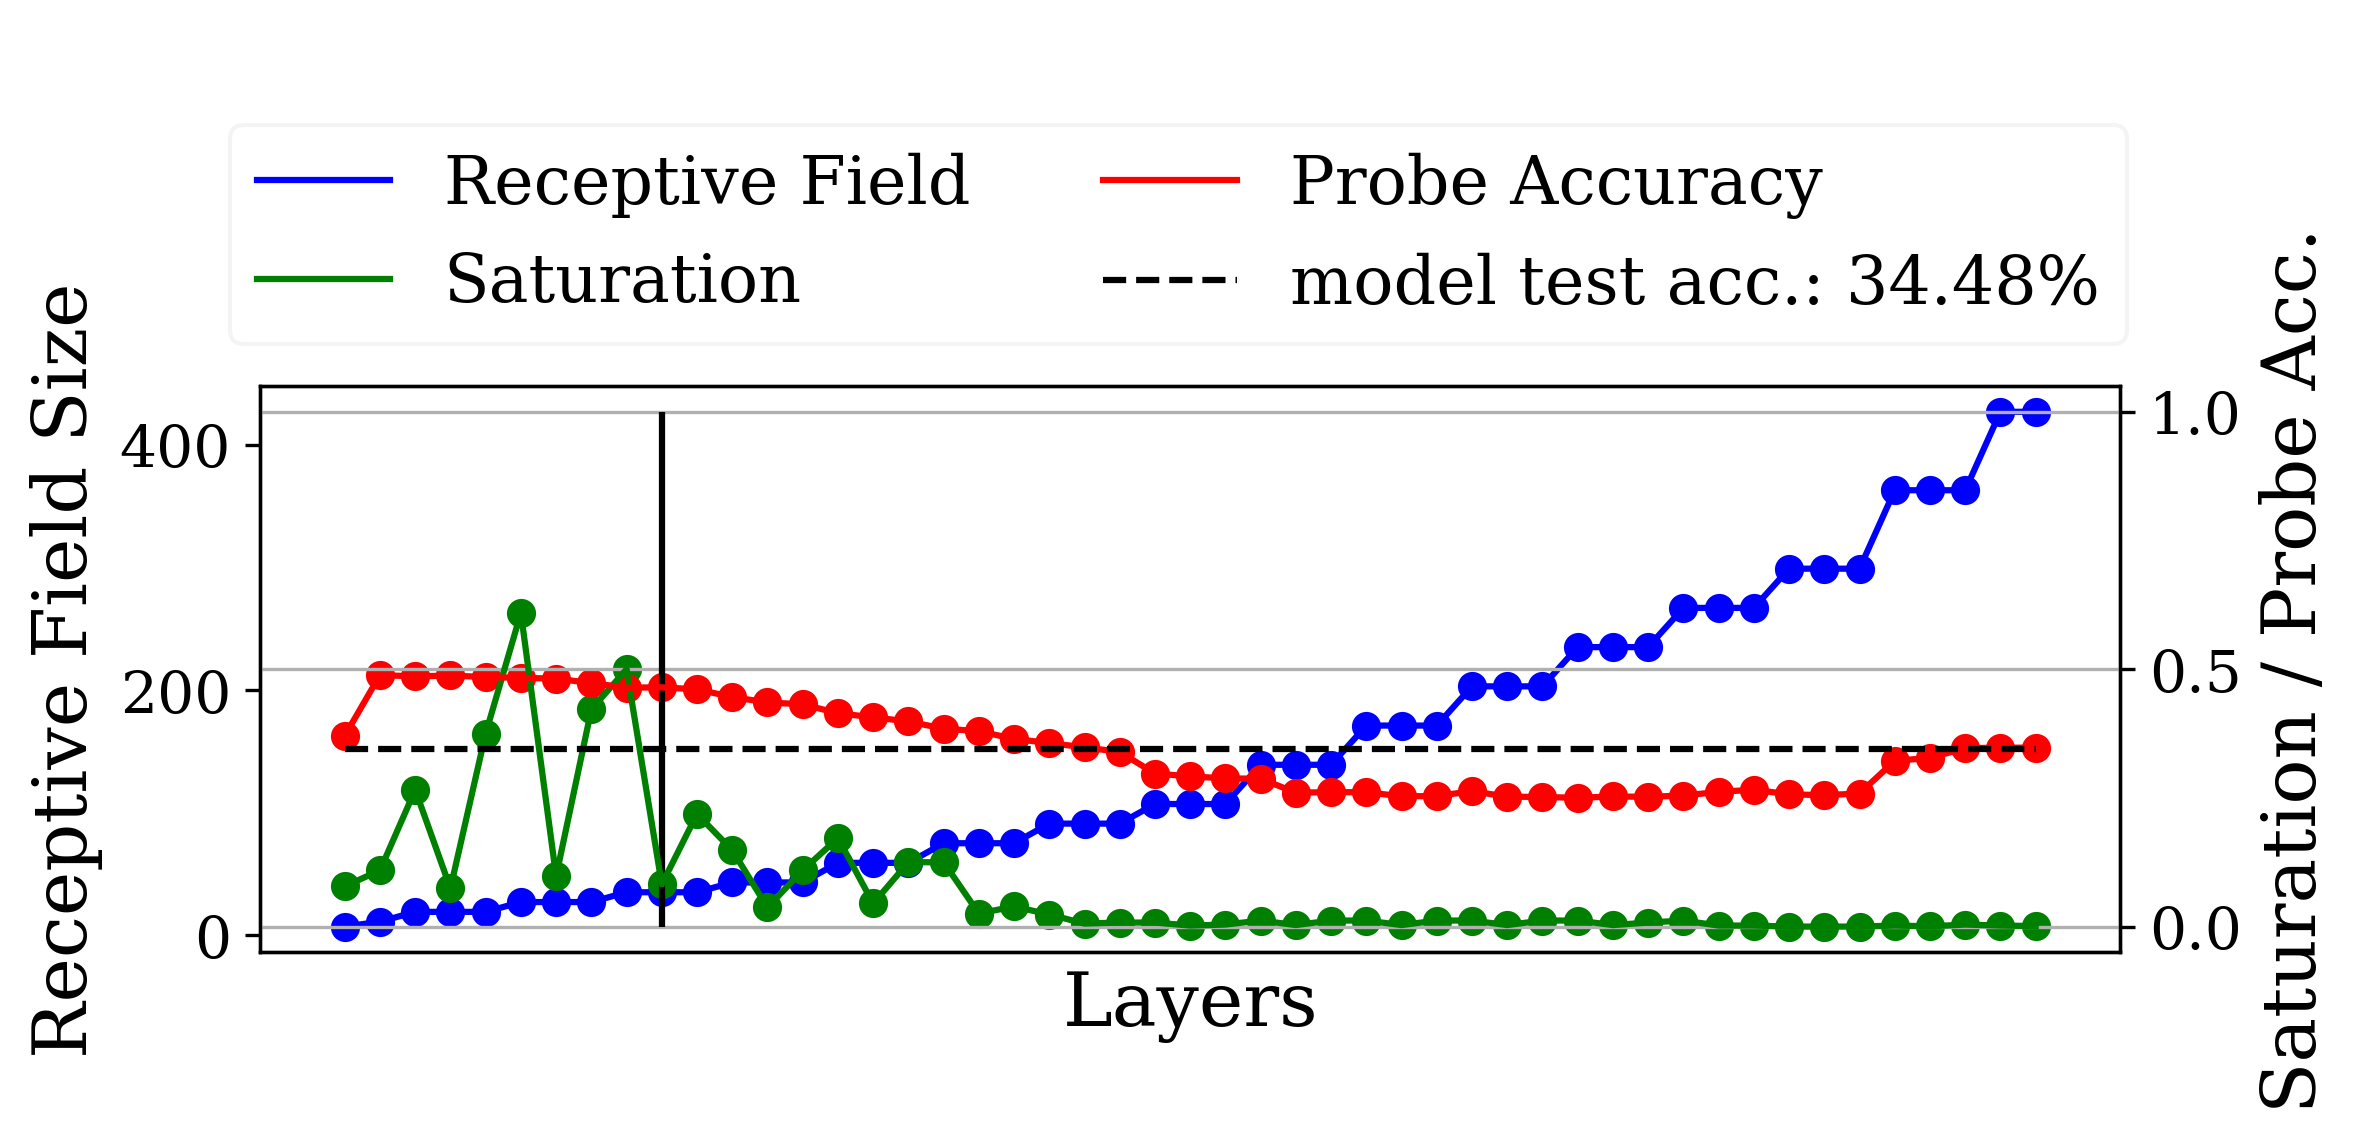

In [8]:
for model in ['ResNet18', "ResNet18NoSkip", "ResNet34", "ResNet50", "ResNet50NoSkip"]:
    dataset = 'Cifar10'
    input_res = 32
    batch_size = 64 if model != "ResNet50NoSkip" else 128
    epochs = 30 if model != "ResNet50" else 60
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

13 13 15


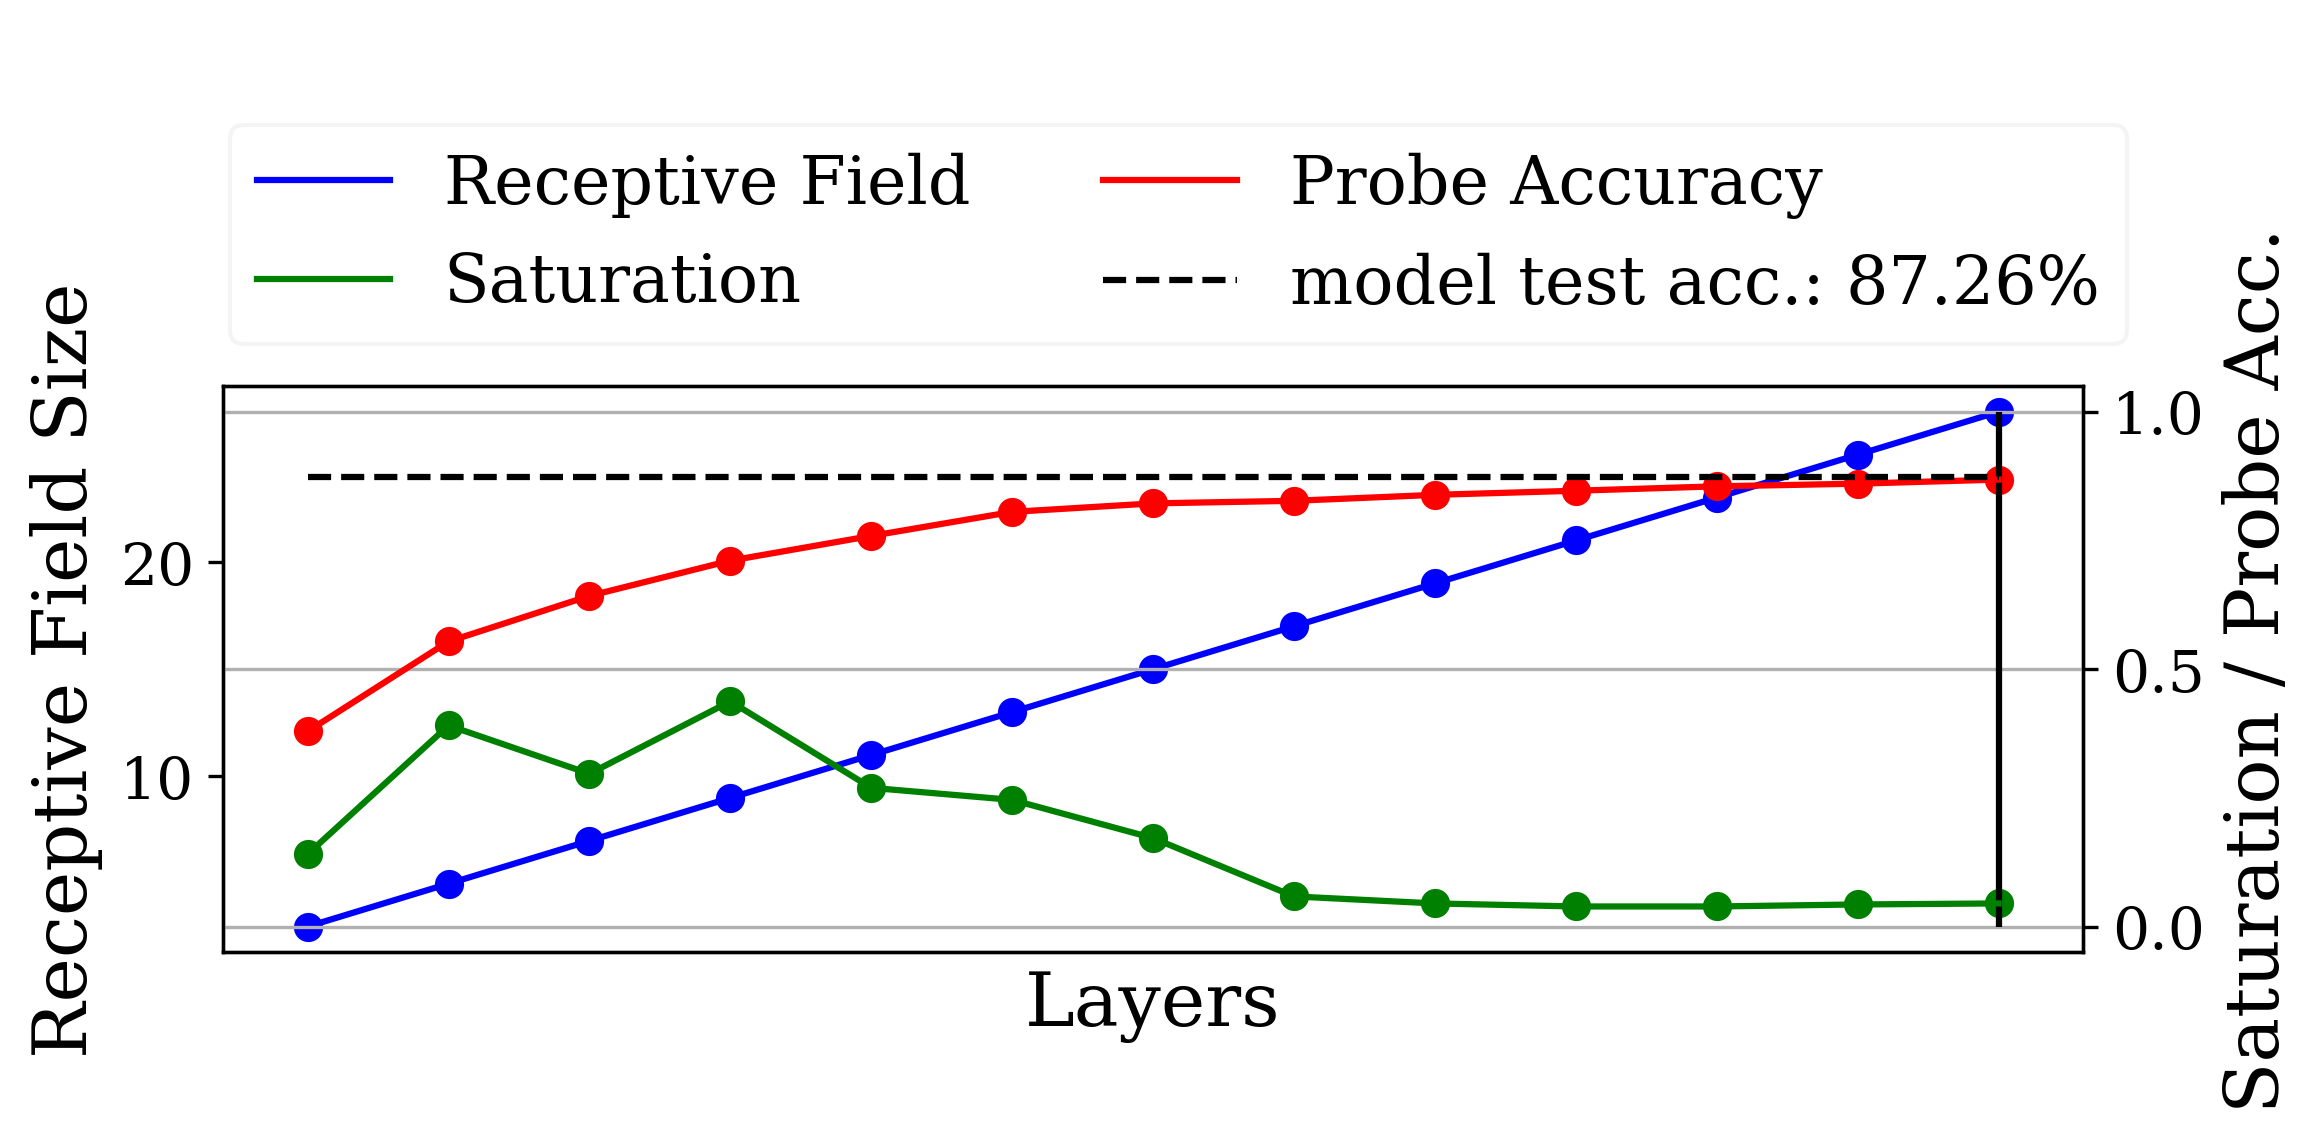

In [9]:
model = 'AlteredPooling5_VGG16'
dataset = 'Cifar10'
input_res = 32
batch_size = 64
epochs = 30
downsampling = 'None'
thresh = 10000
run_id = 'RES'

plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)

17 17 19


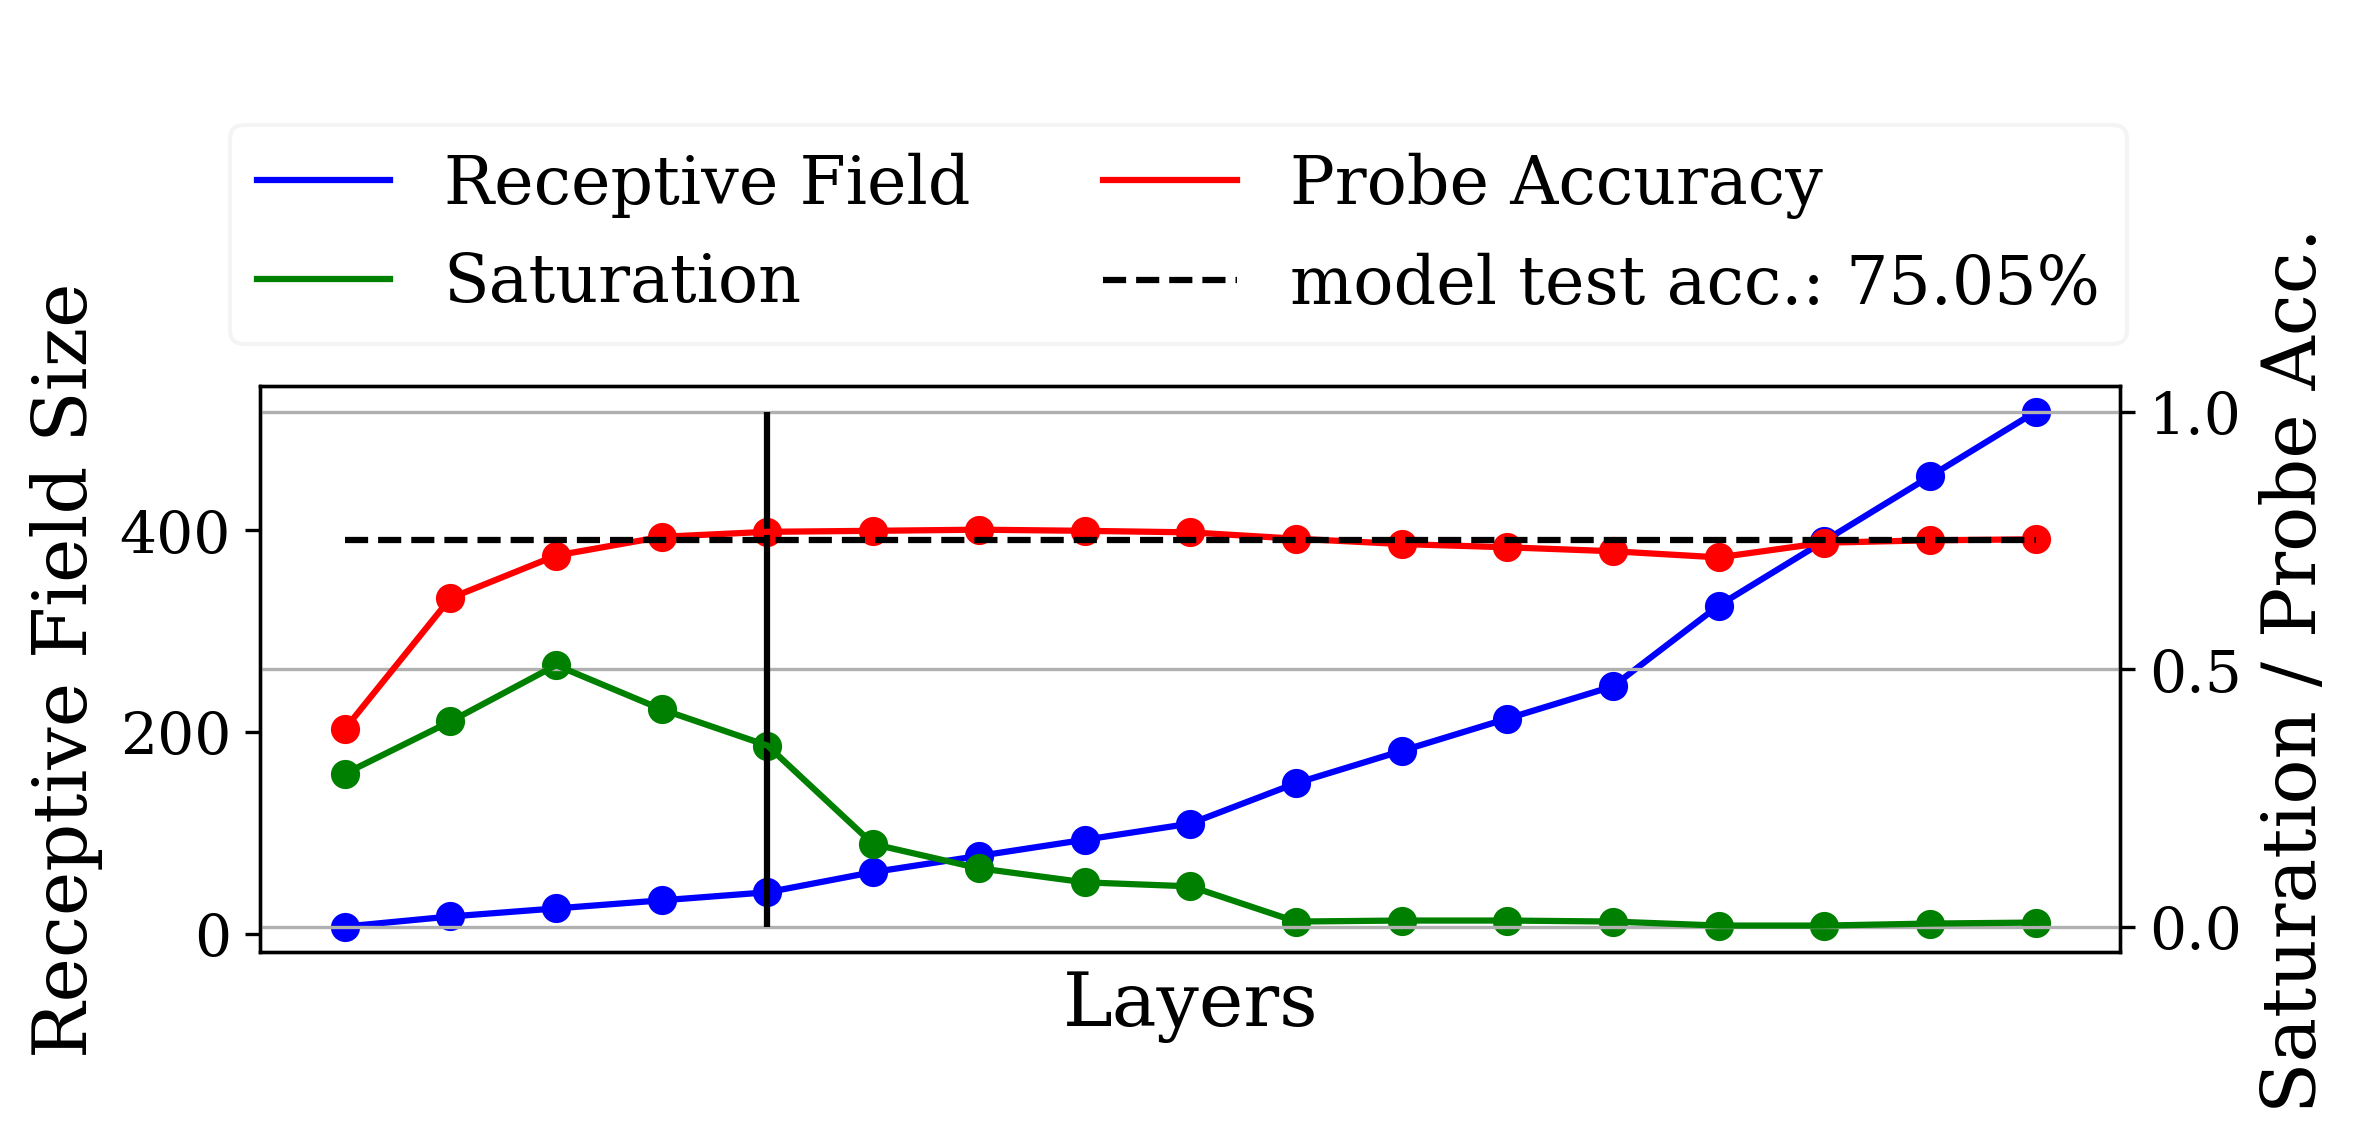

In [10]:
model = 'VGGResNet2'
dataset = 'Cifar10'
input_res = 32
batch_size = 64
epochs = 30
downsampling = 'None'
thresh = 10000
run_id = 'RES'

plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)

17 17 19


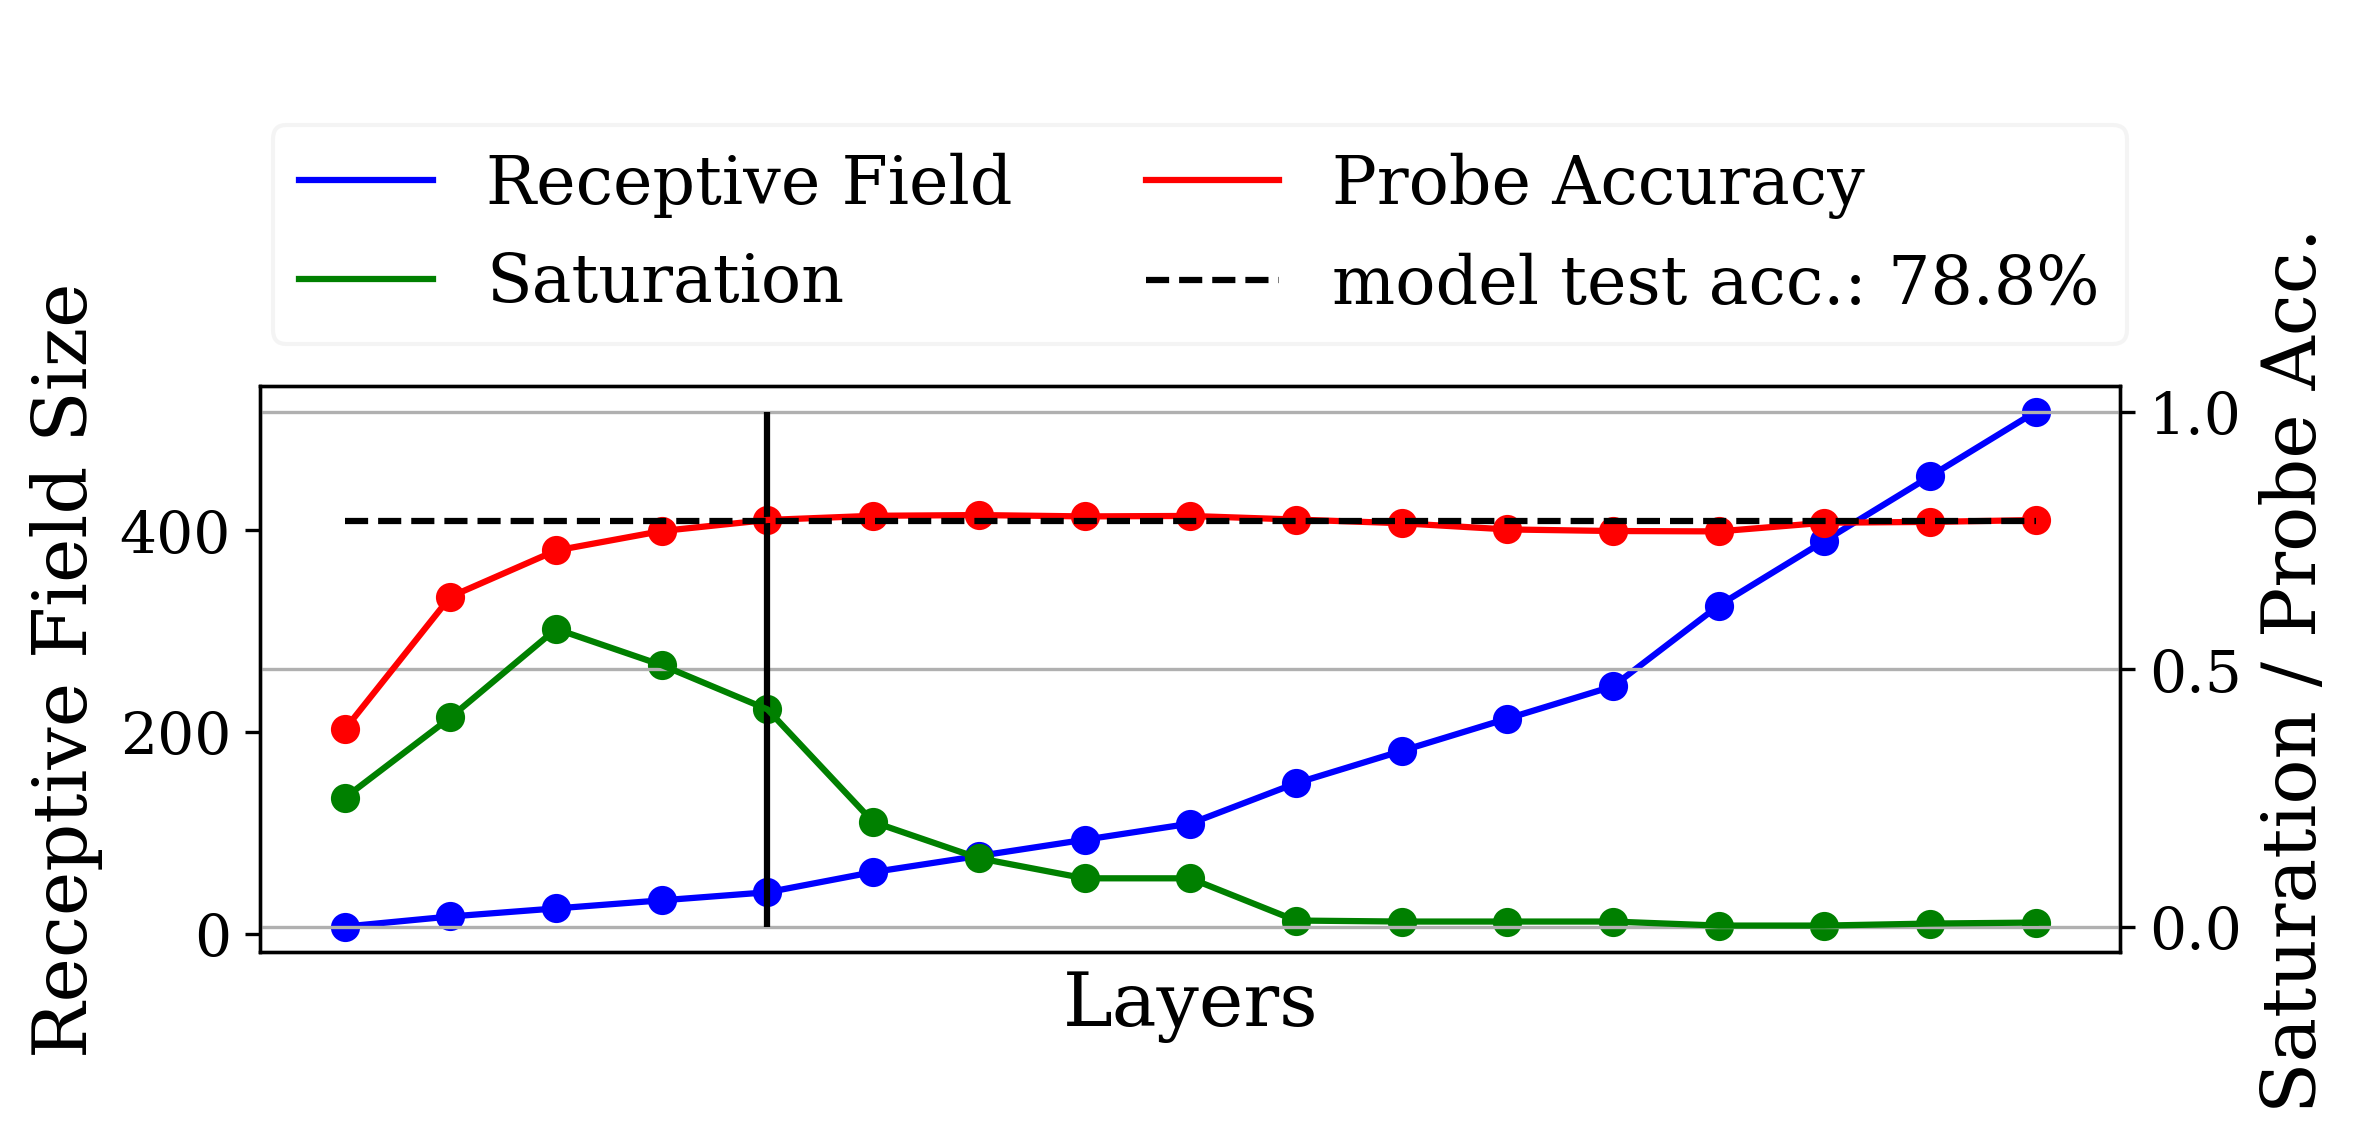

In [11]:
model = 'VGGResNet'
dataset = 'Cifar10'
input_res = 32
batch_size = 64
epochs = 30
downsampling = 'None'
thresh = 10000
run_id = 'RES'

plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)

8 8 10


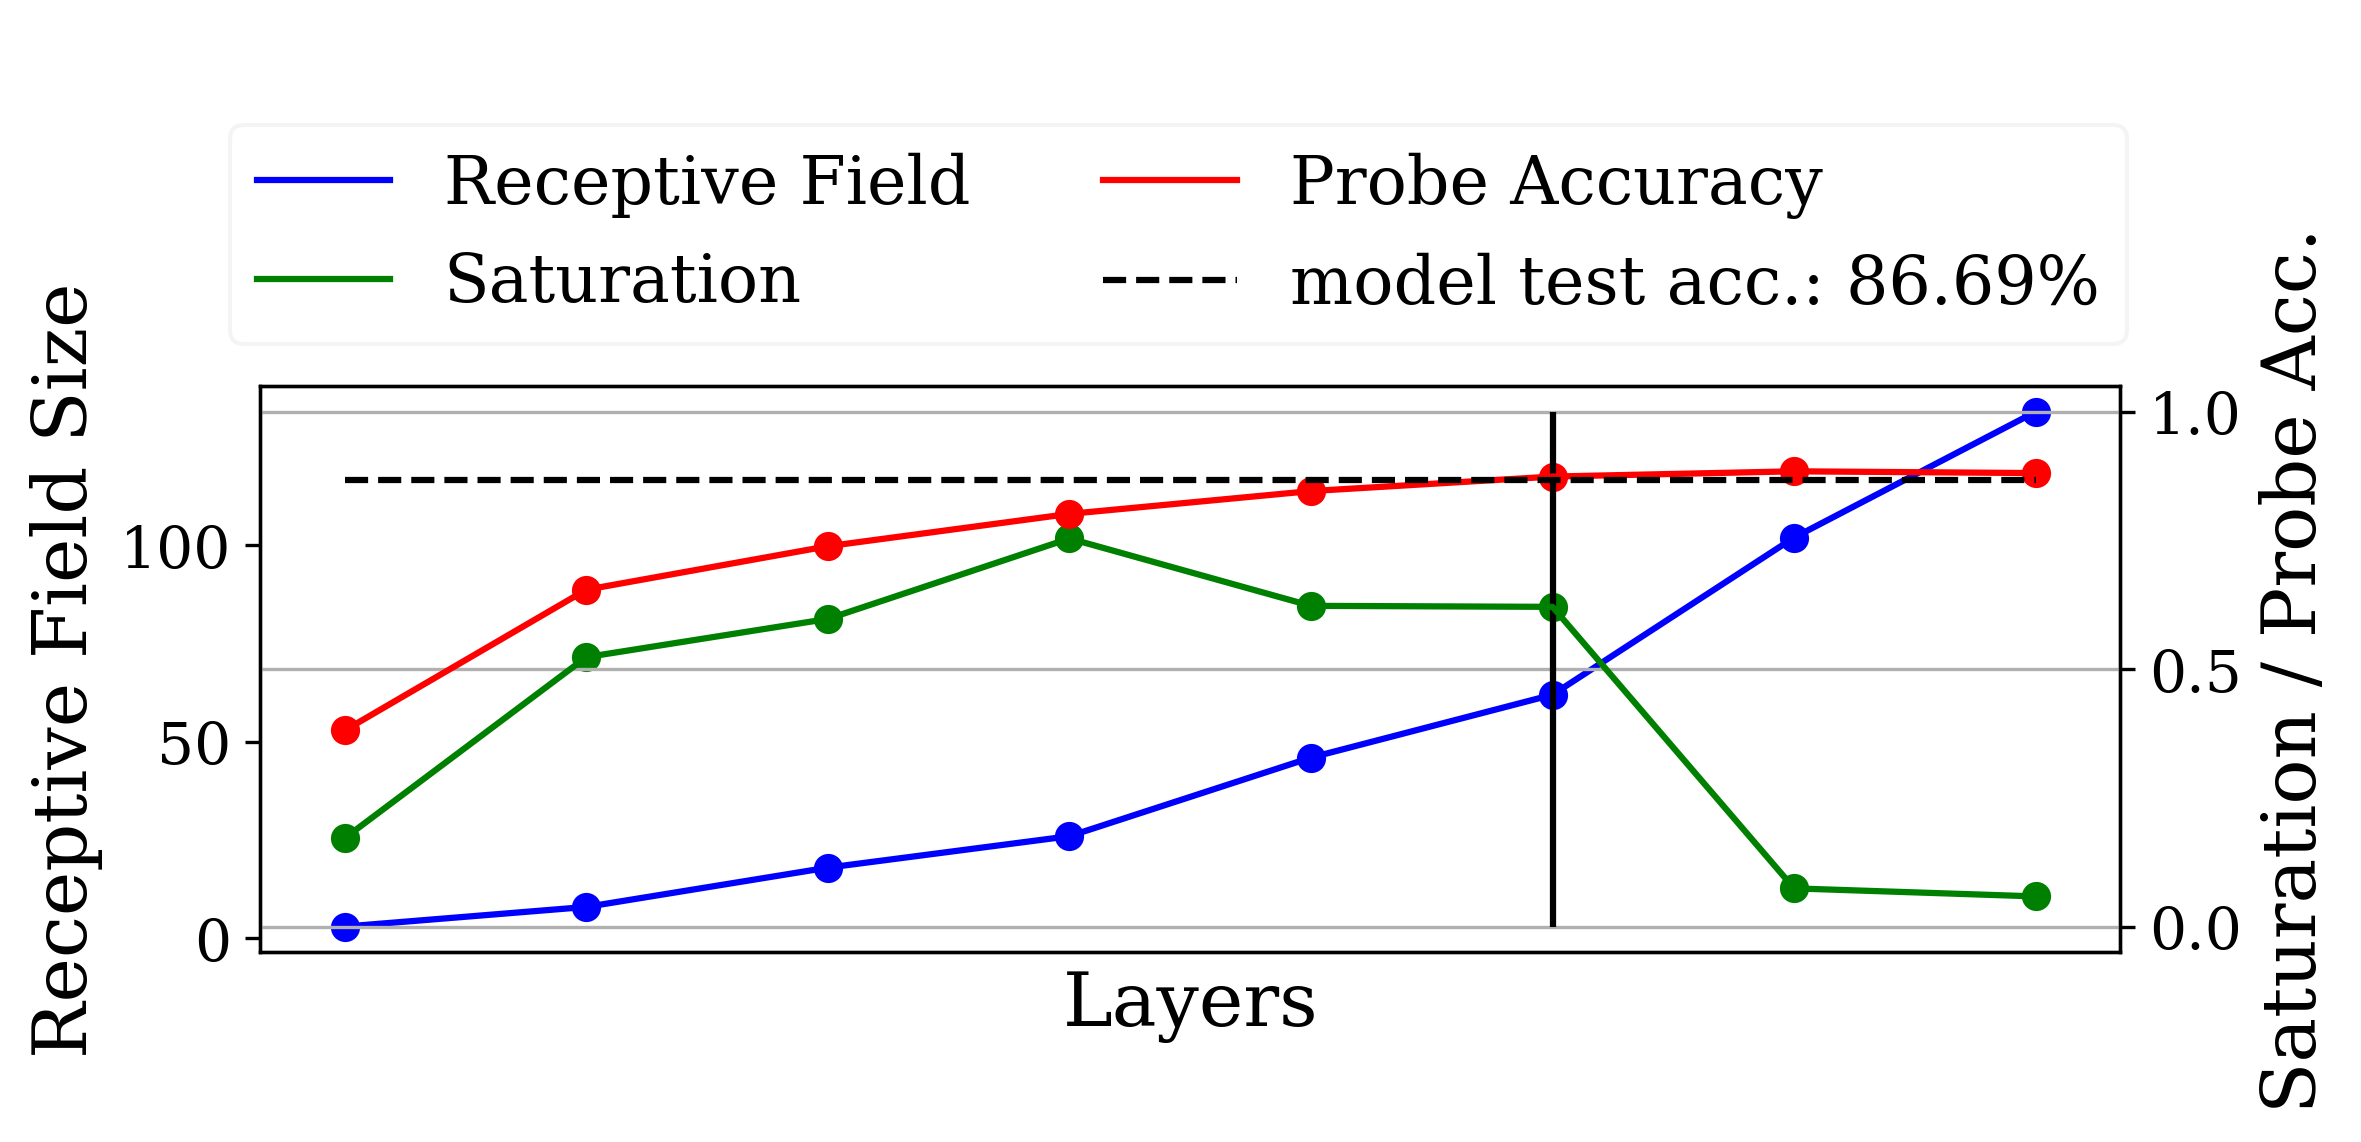

In [12]:
model = 'VGG11'
dataset = 'Cifar10'
input_res = 32
batch_size = 512
epochs = 30
downsampling = 'None'
thresh = 10000
run_id = 'B2P'

plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)

8 8 10
10 10 12
13 13 15
16 16 18


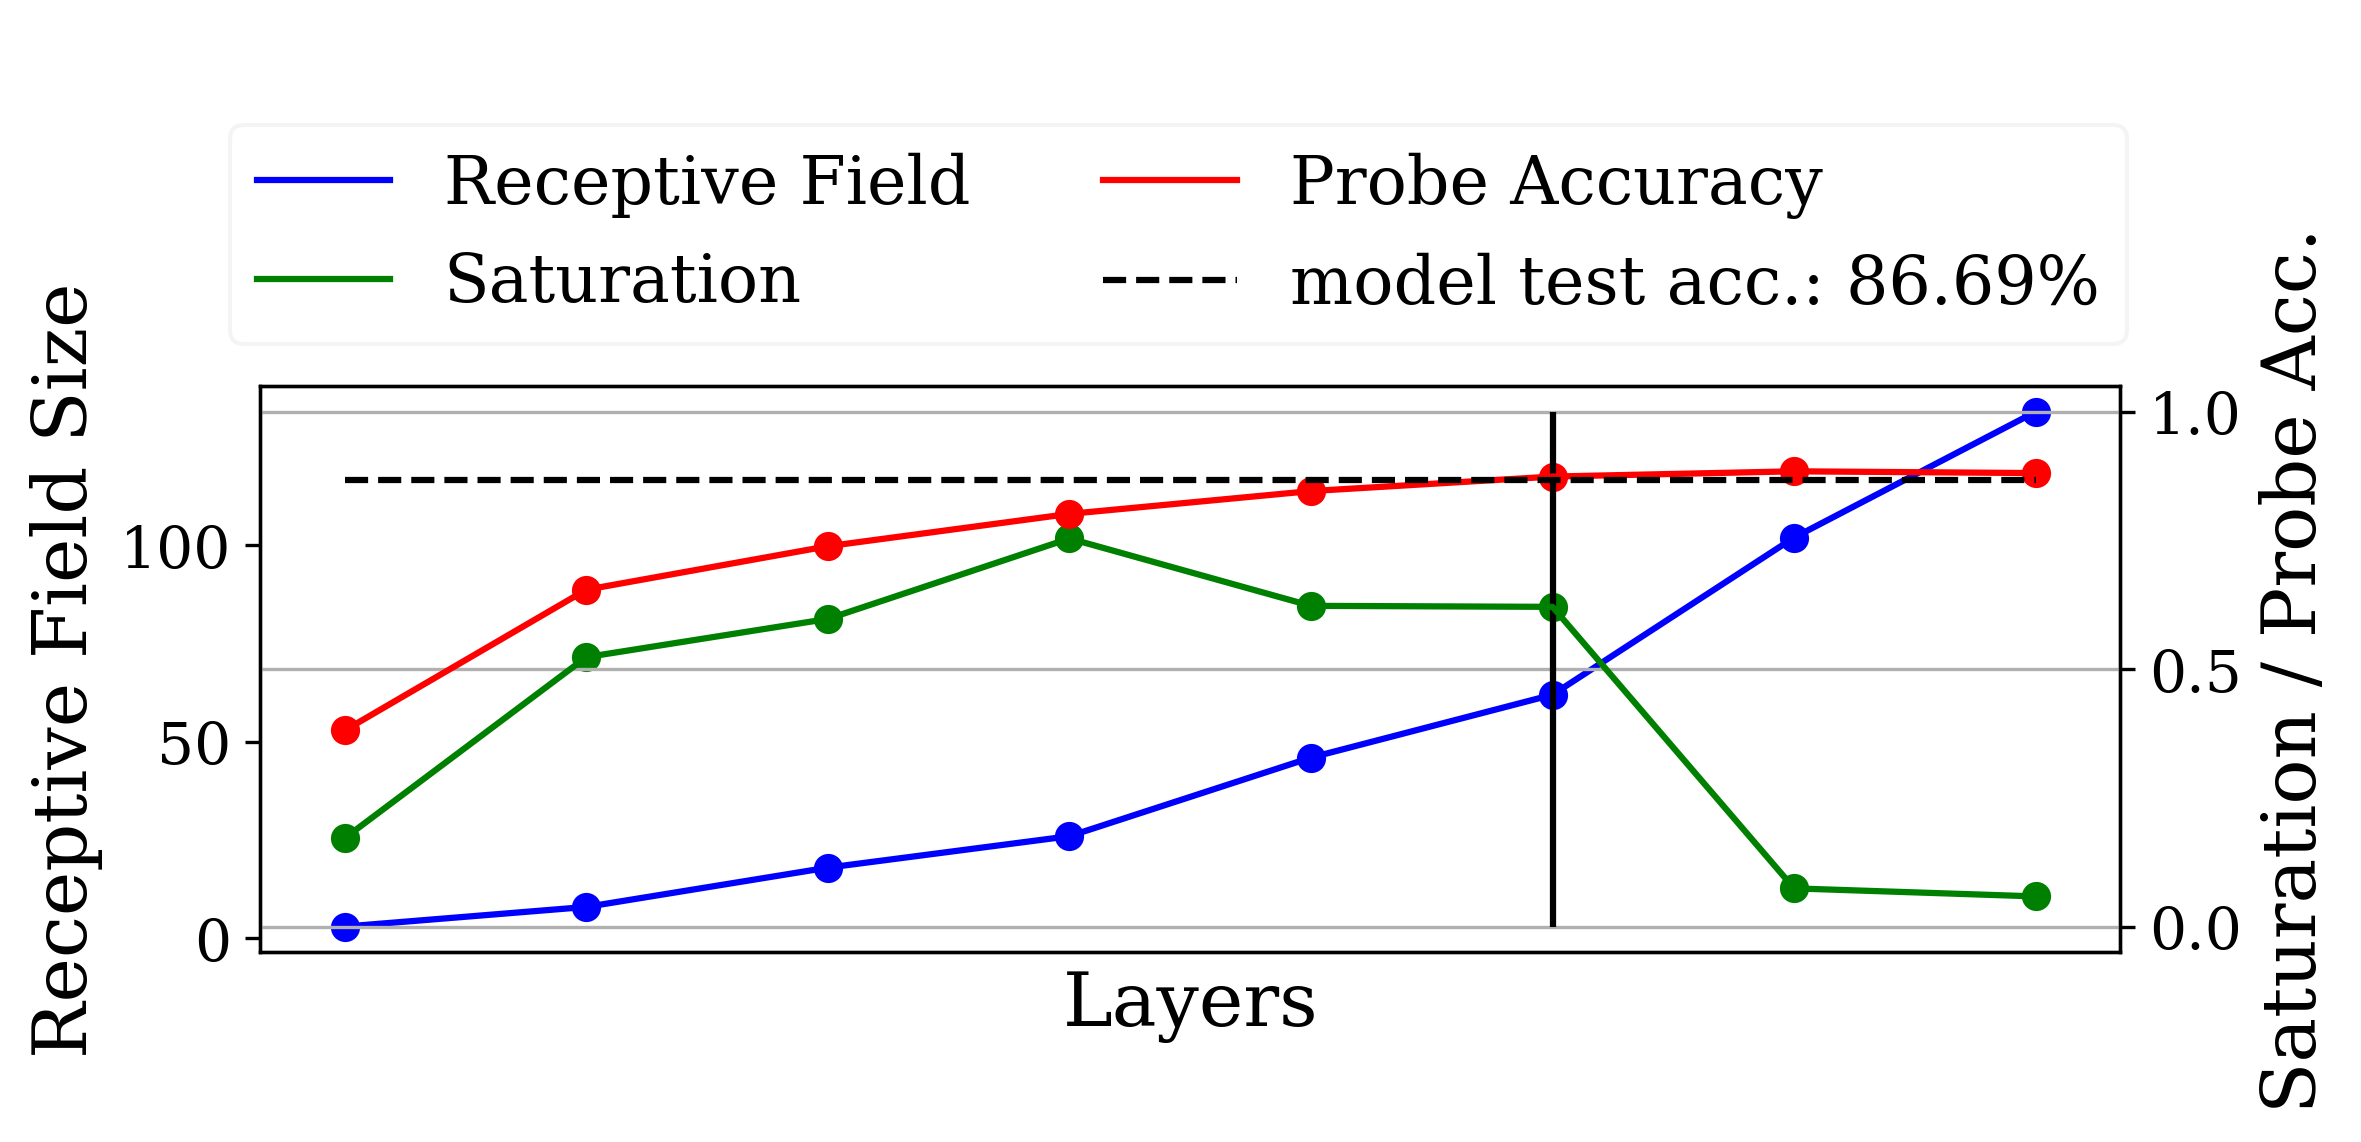

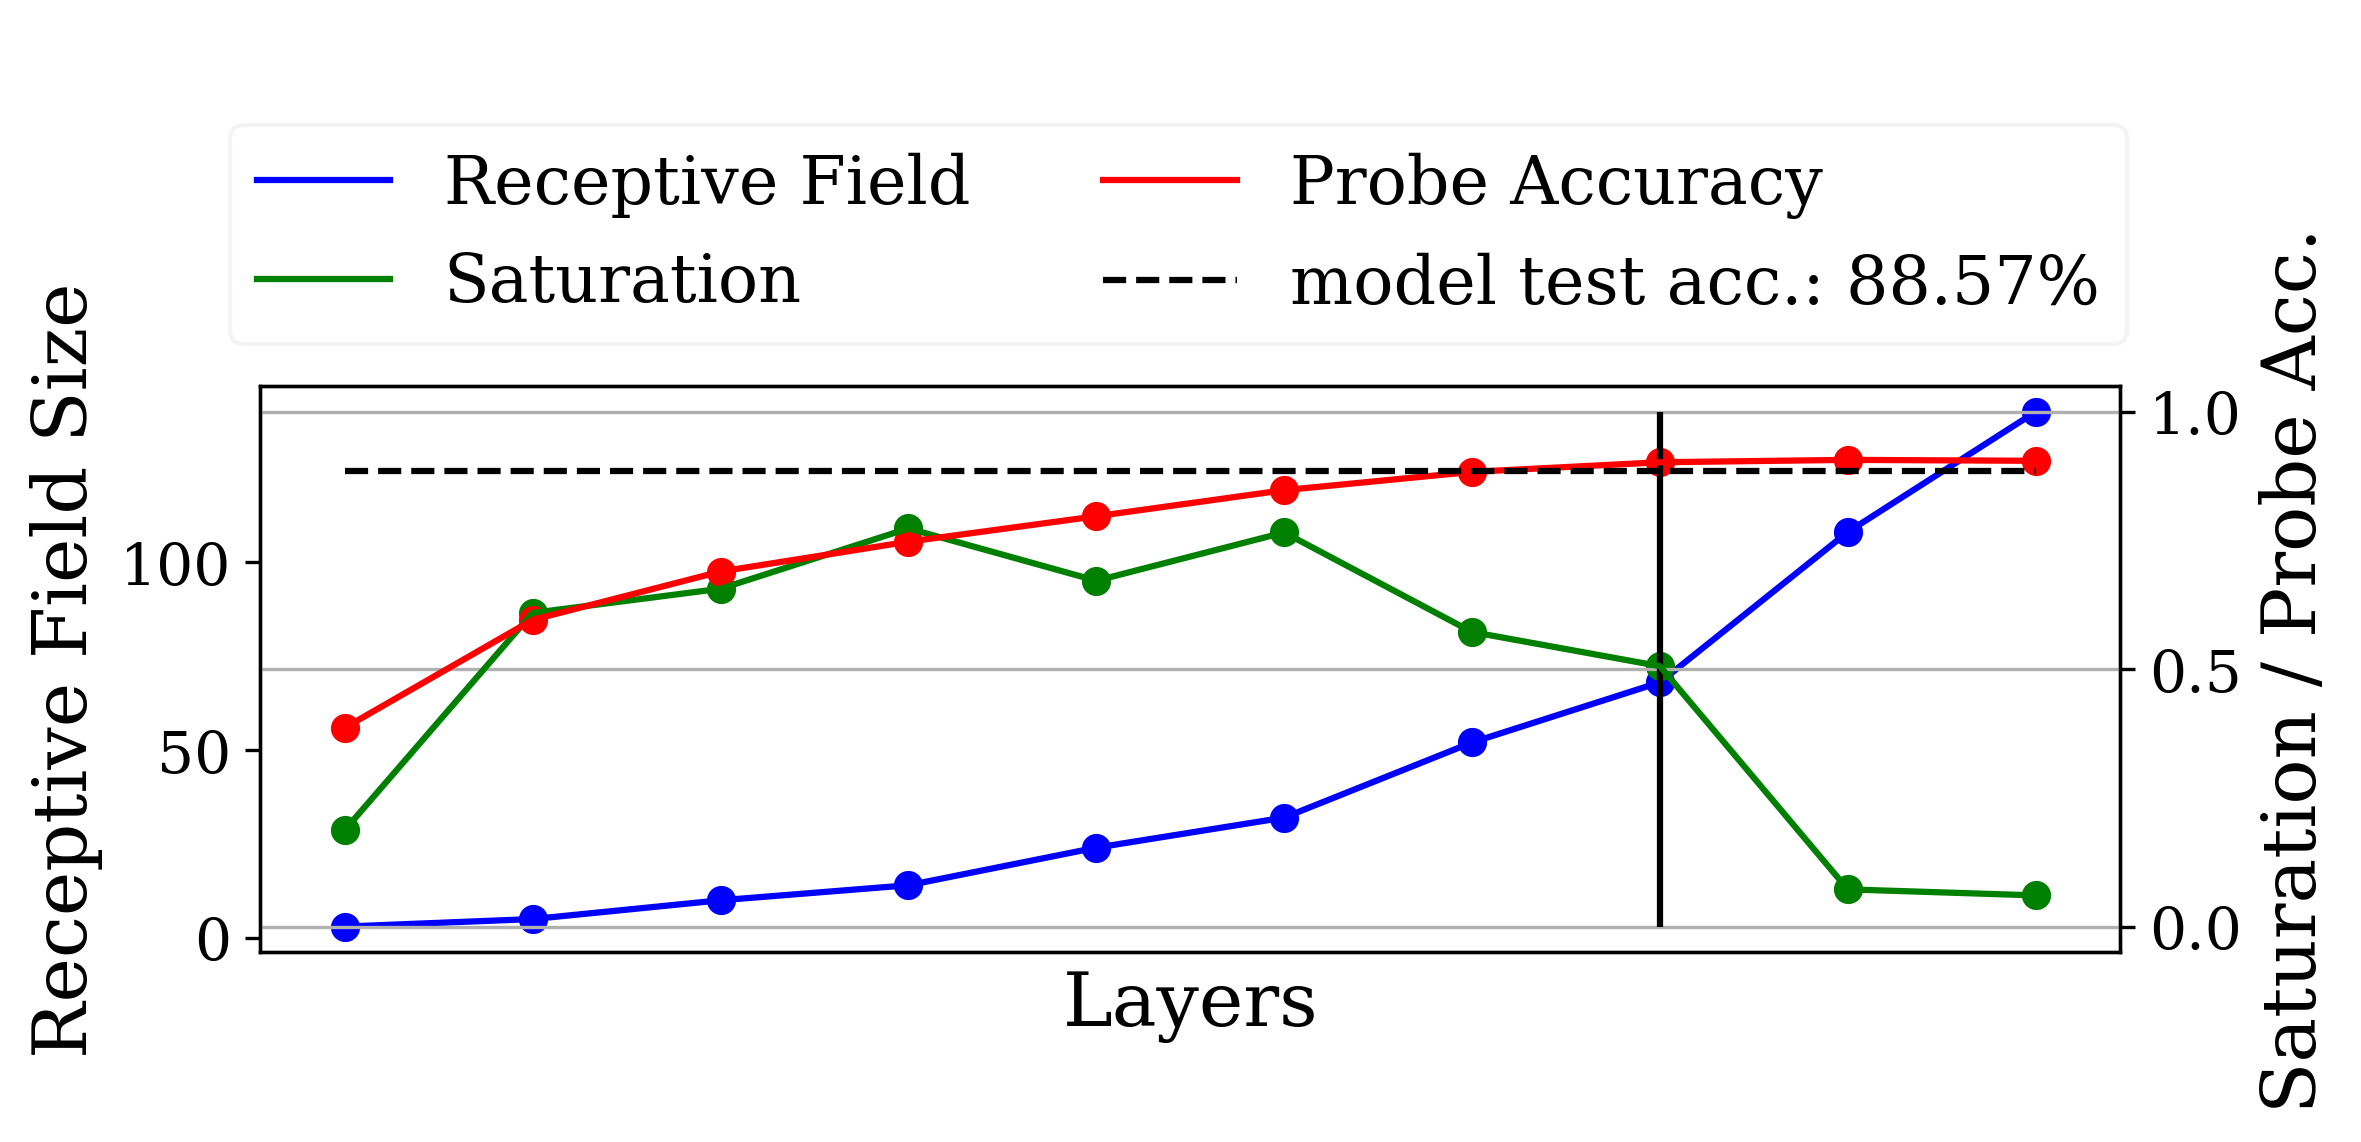

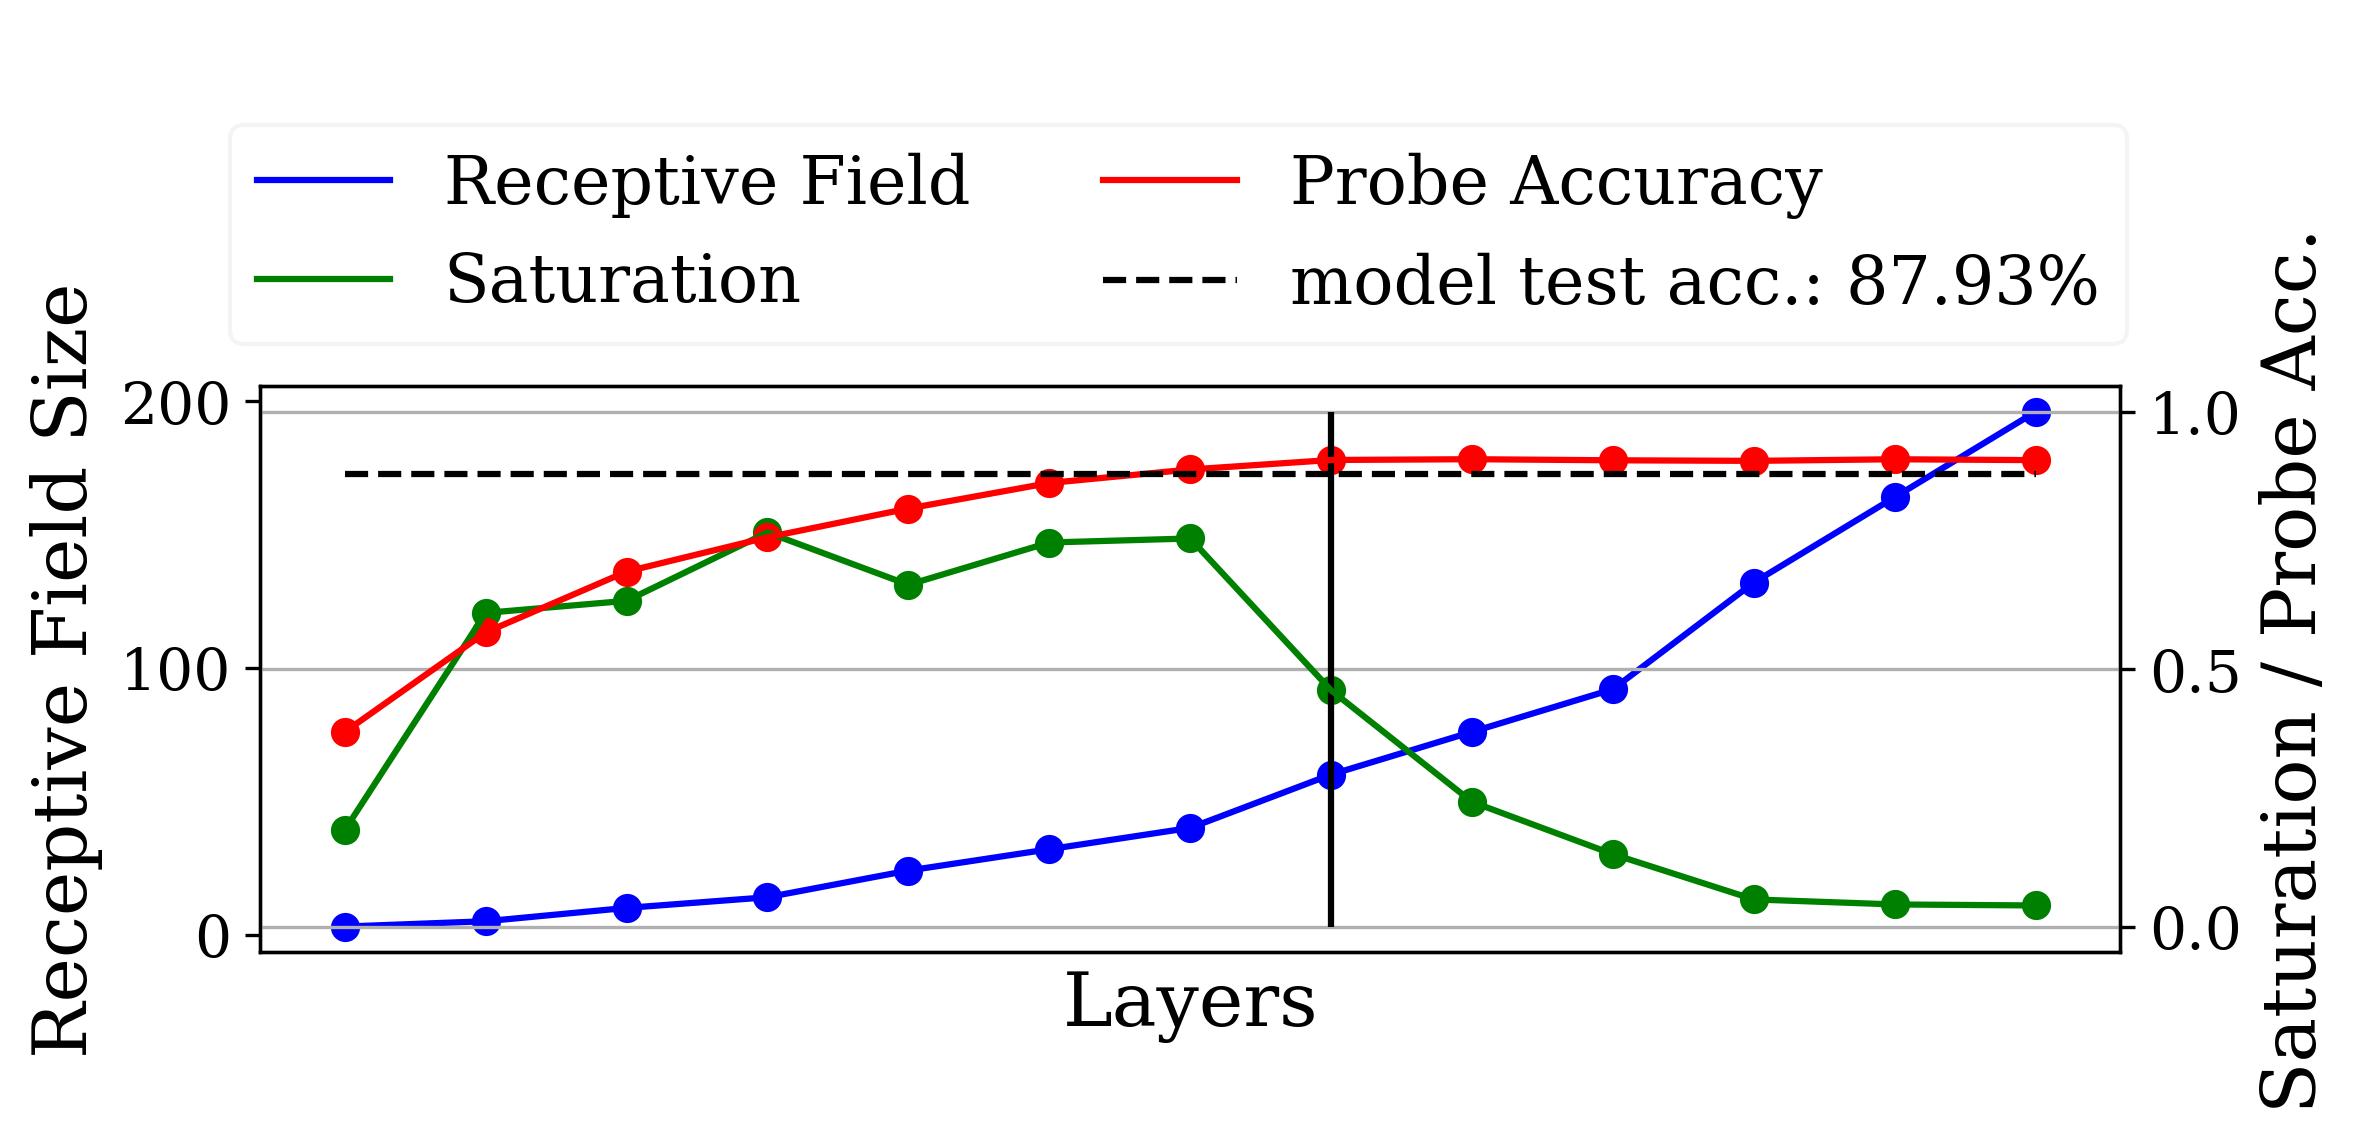

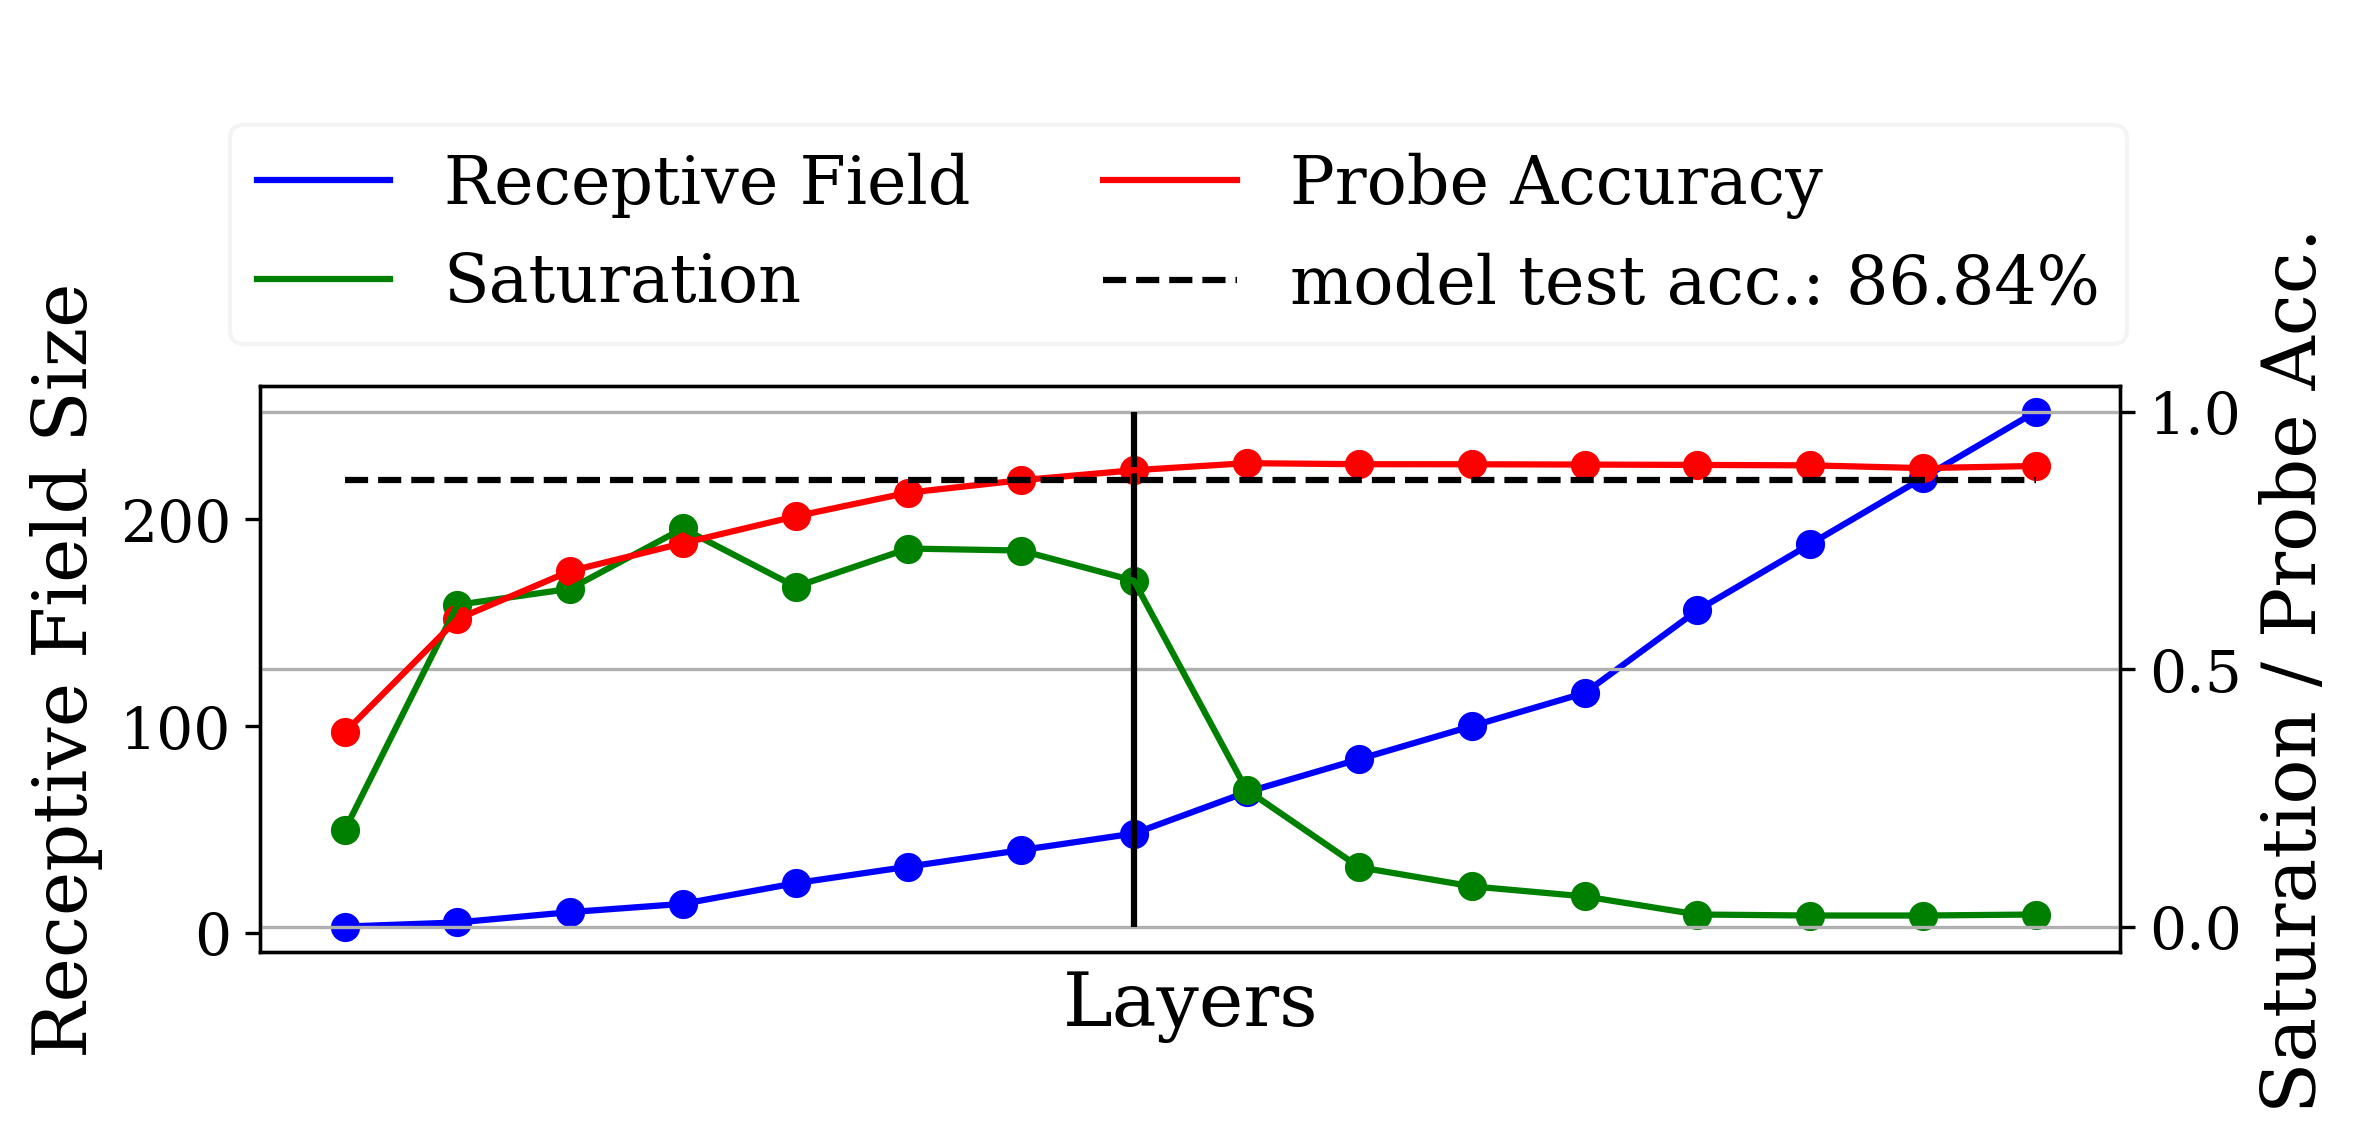

In [13]:
for model in ['VGG11', 'VGG13', 'VGG16', 'VGG19']:
    dataset = 'Cifar10'
    input_res = 32
    batch_size = 512
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'B2P'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')

8 8 10
10 10 12
13 13 15
16 16 18


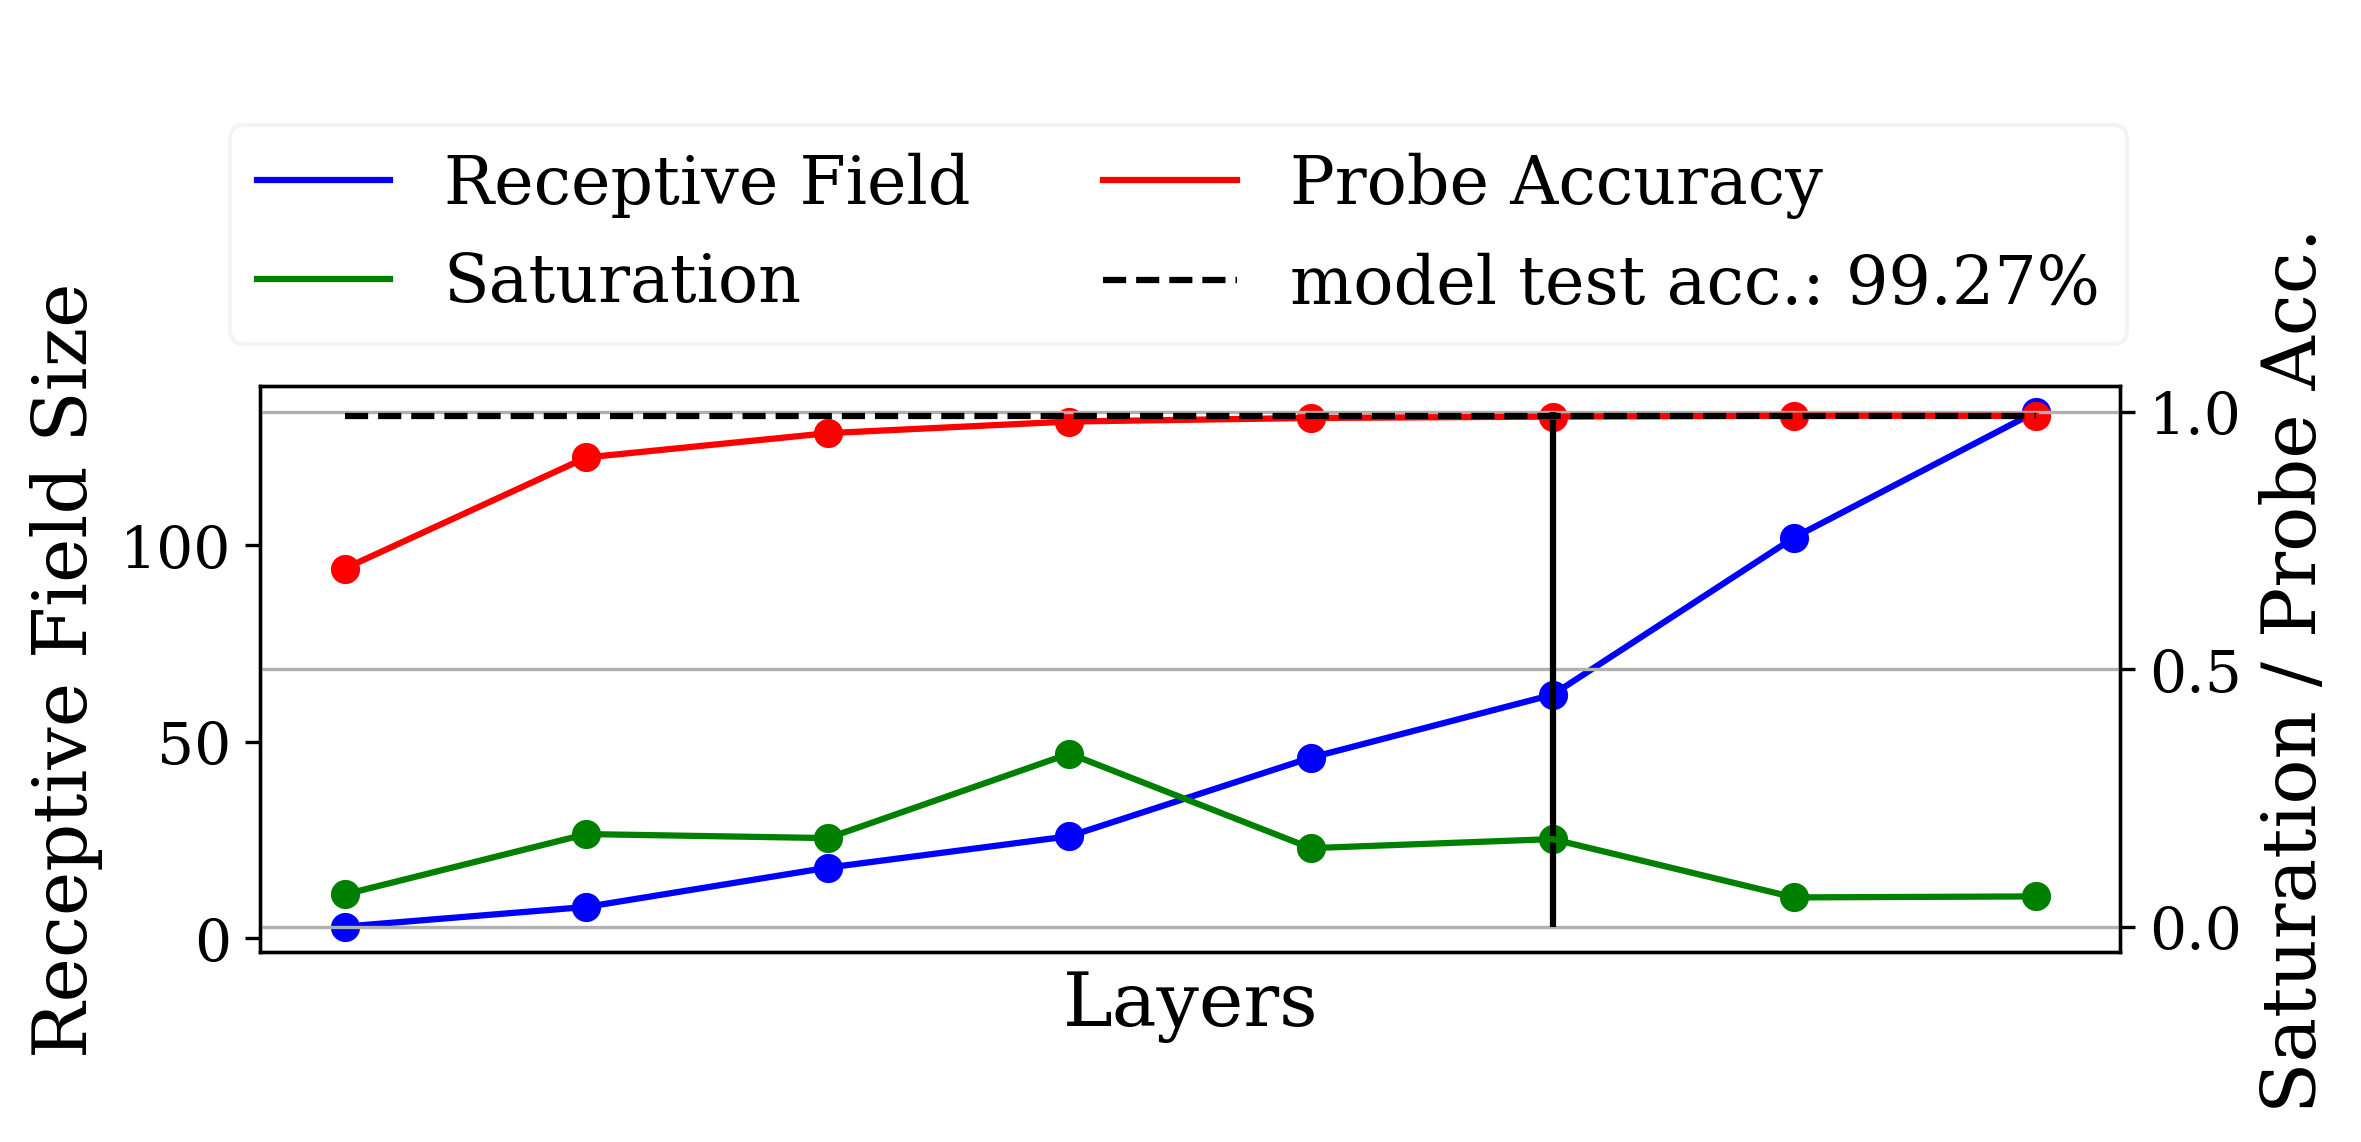

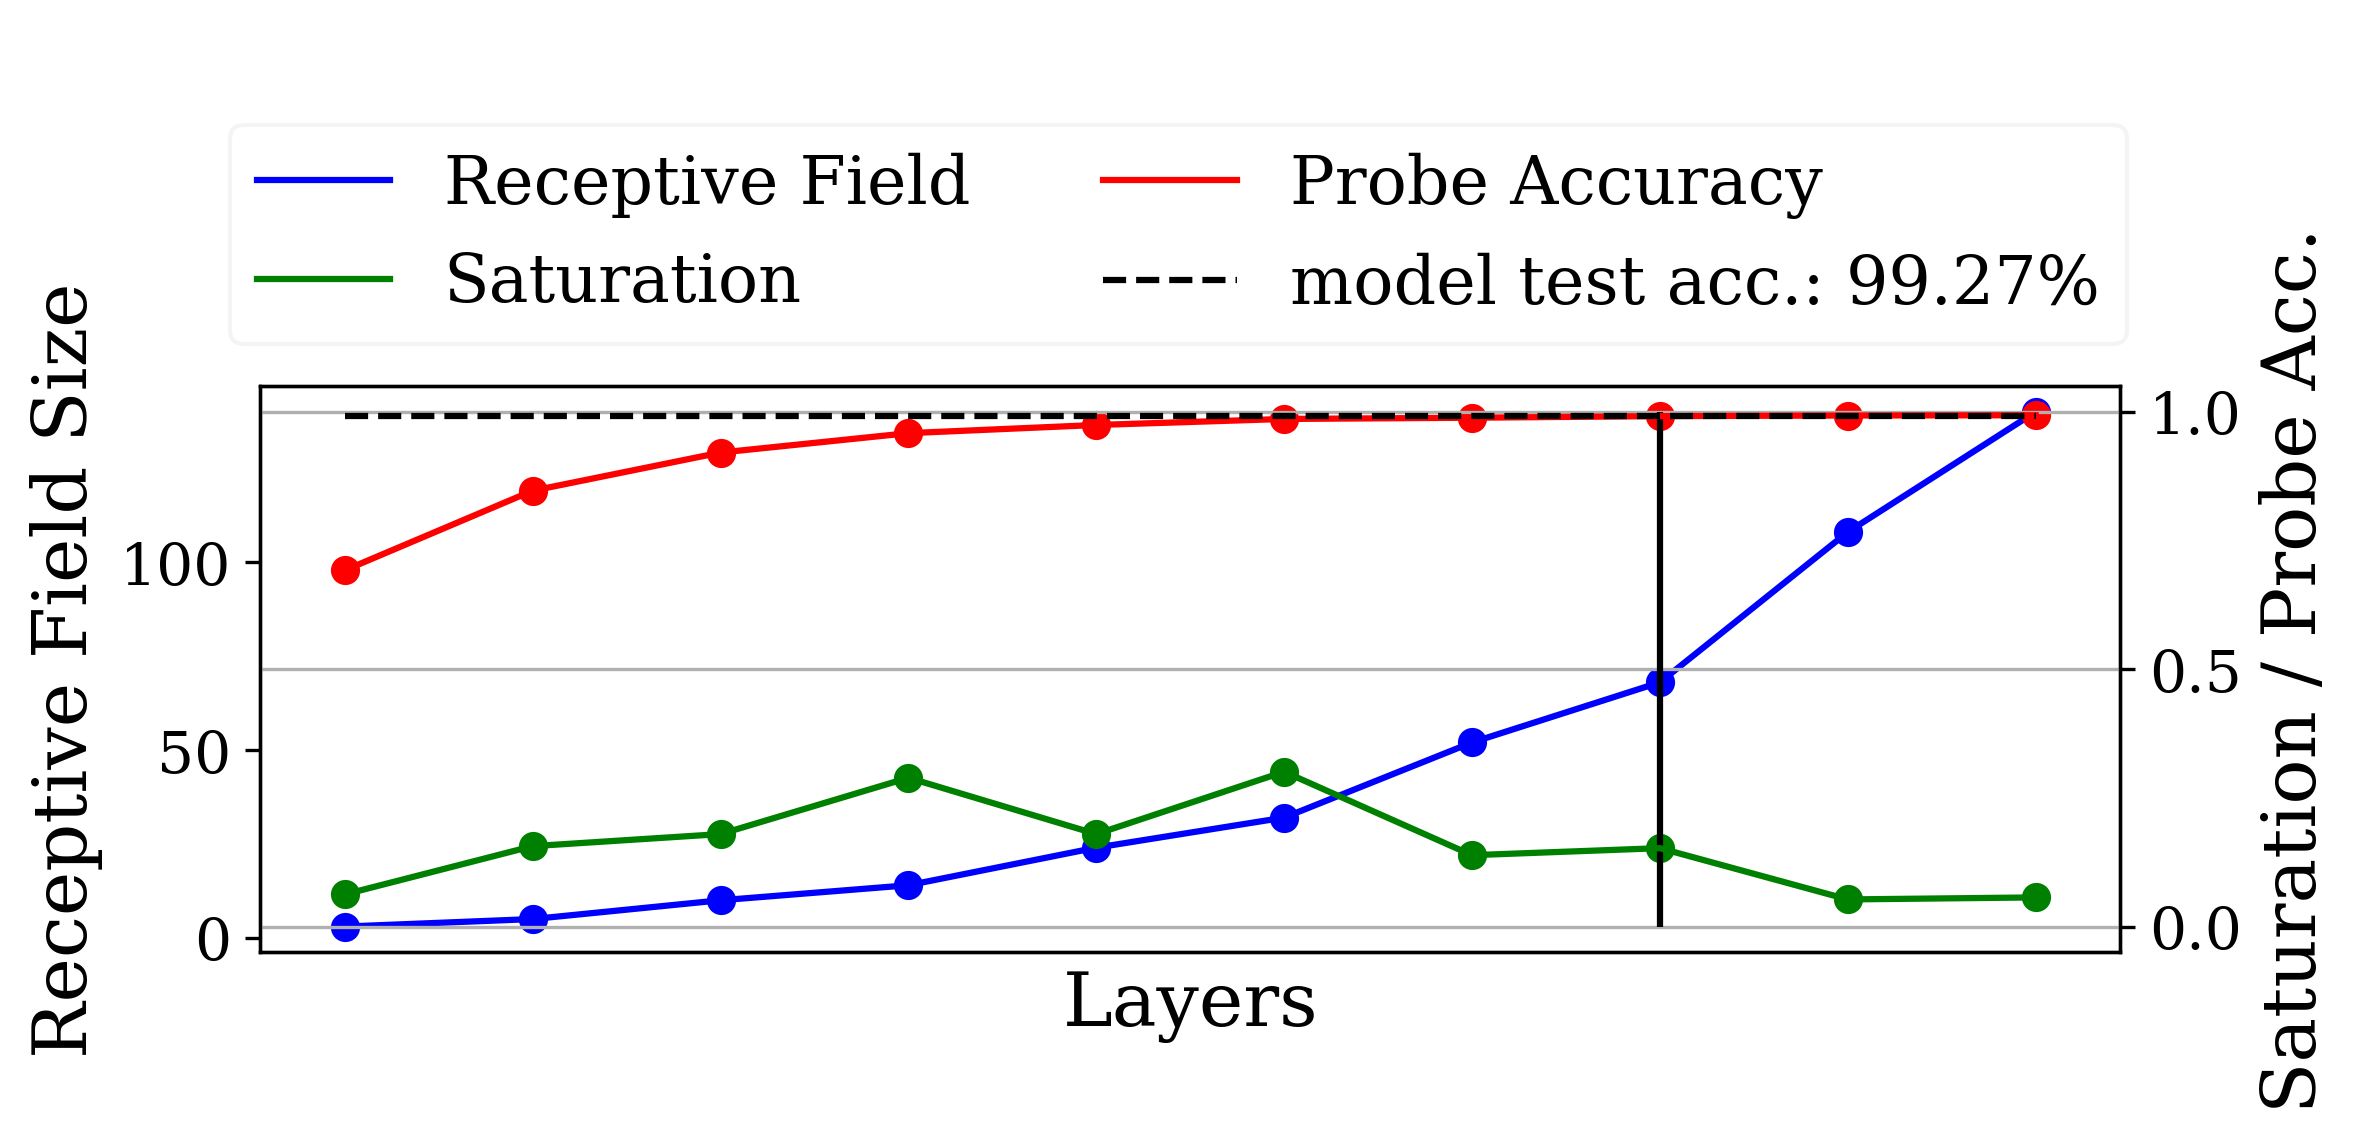

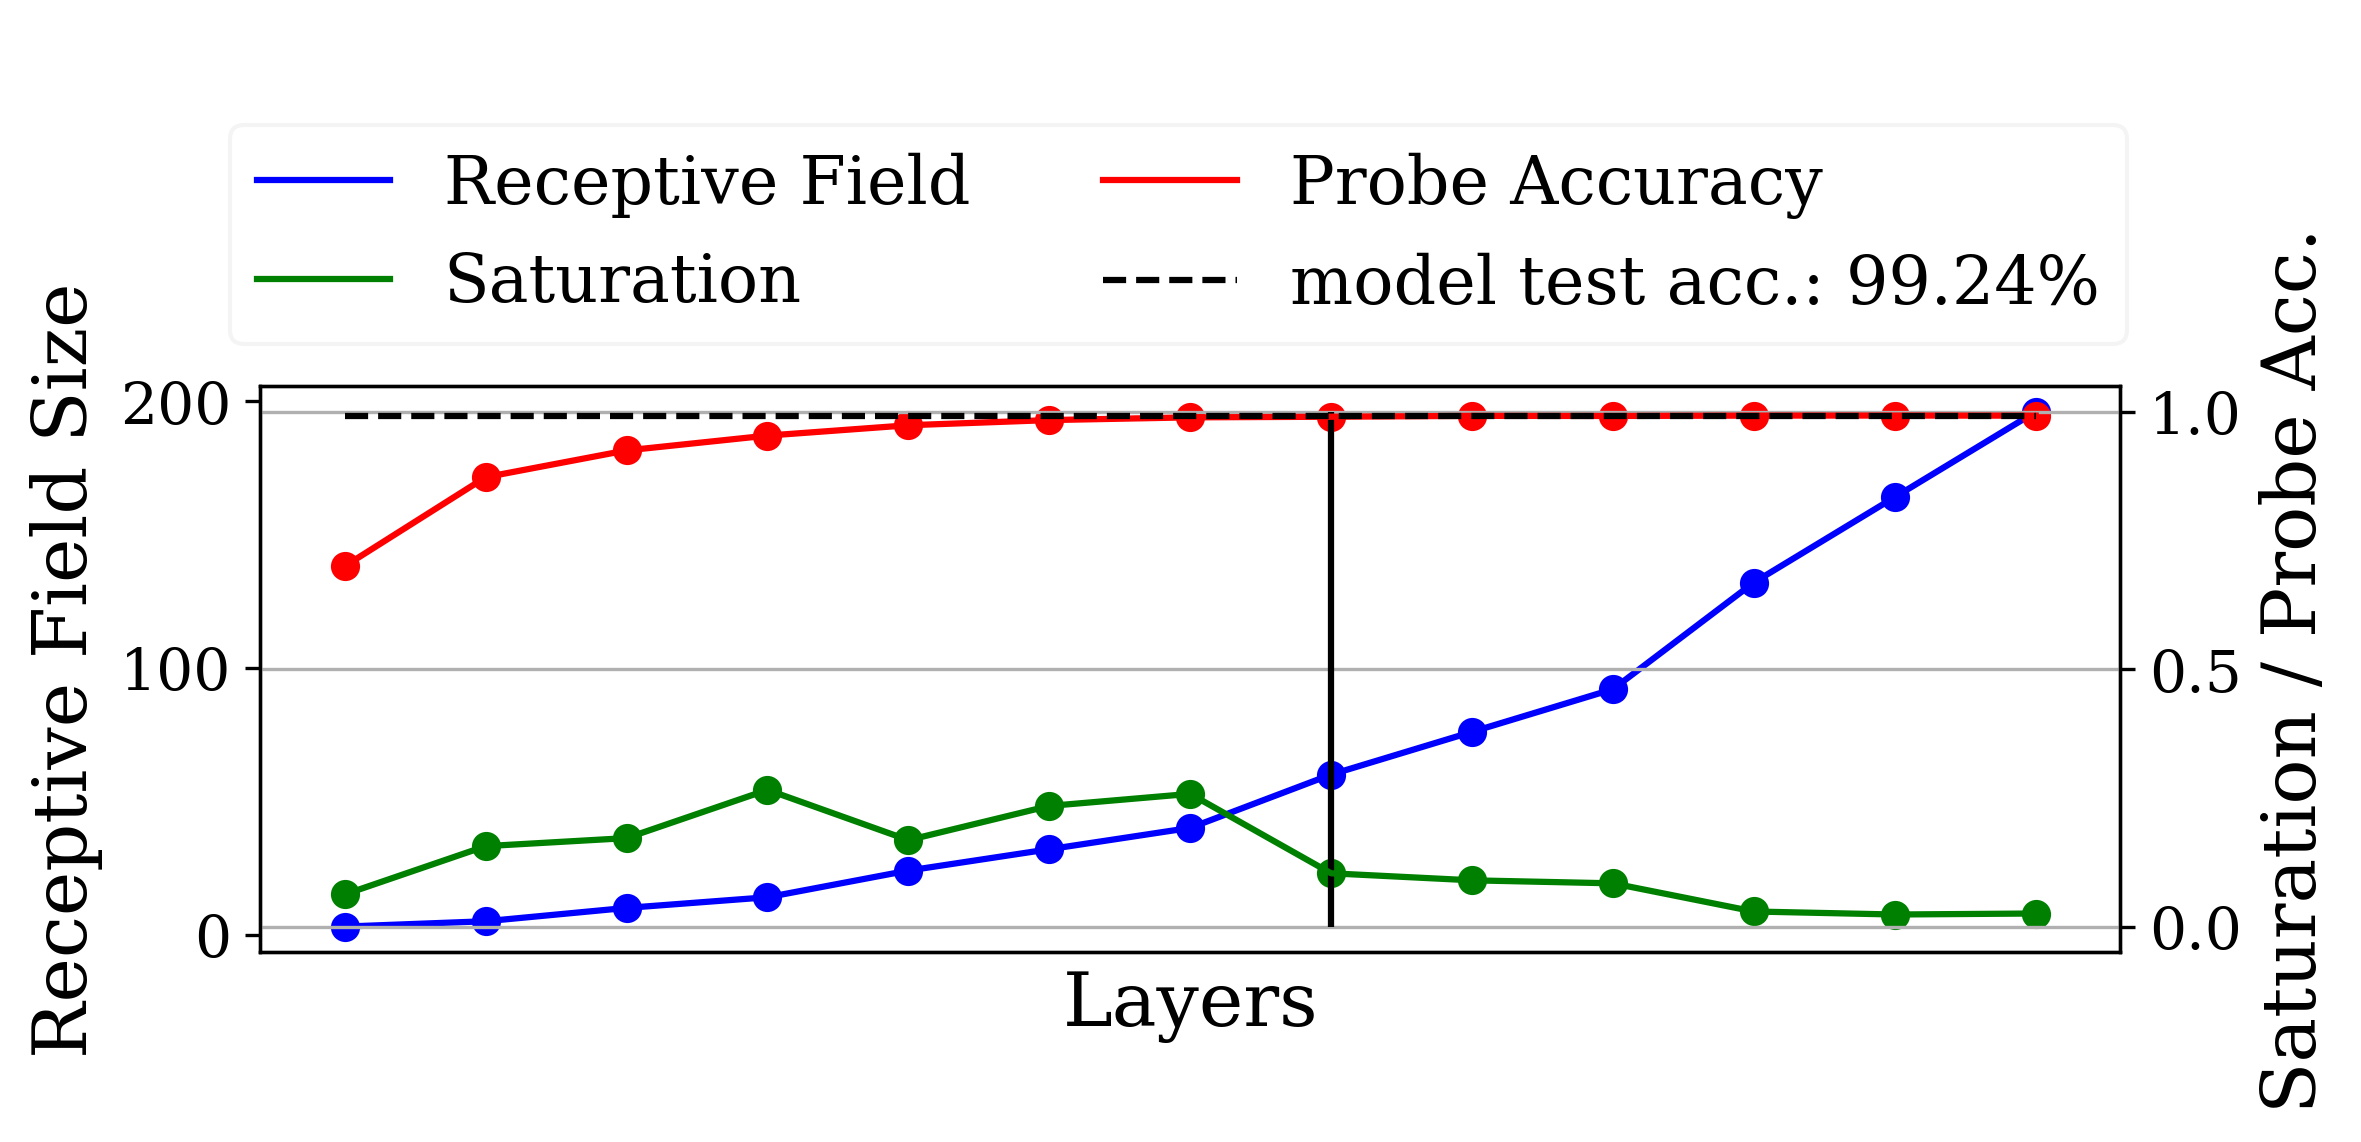

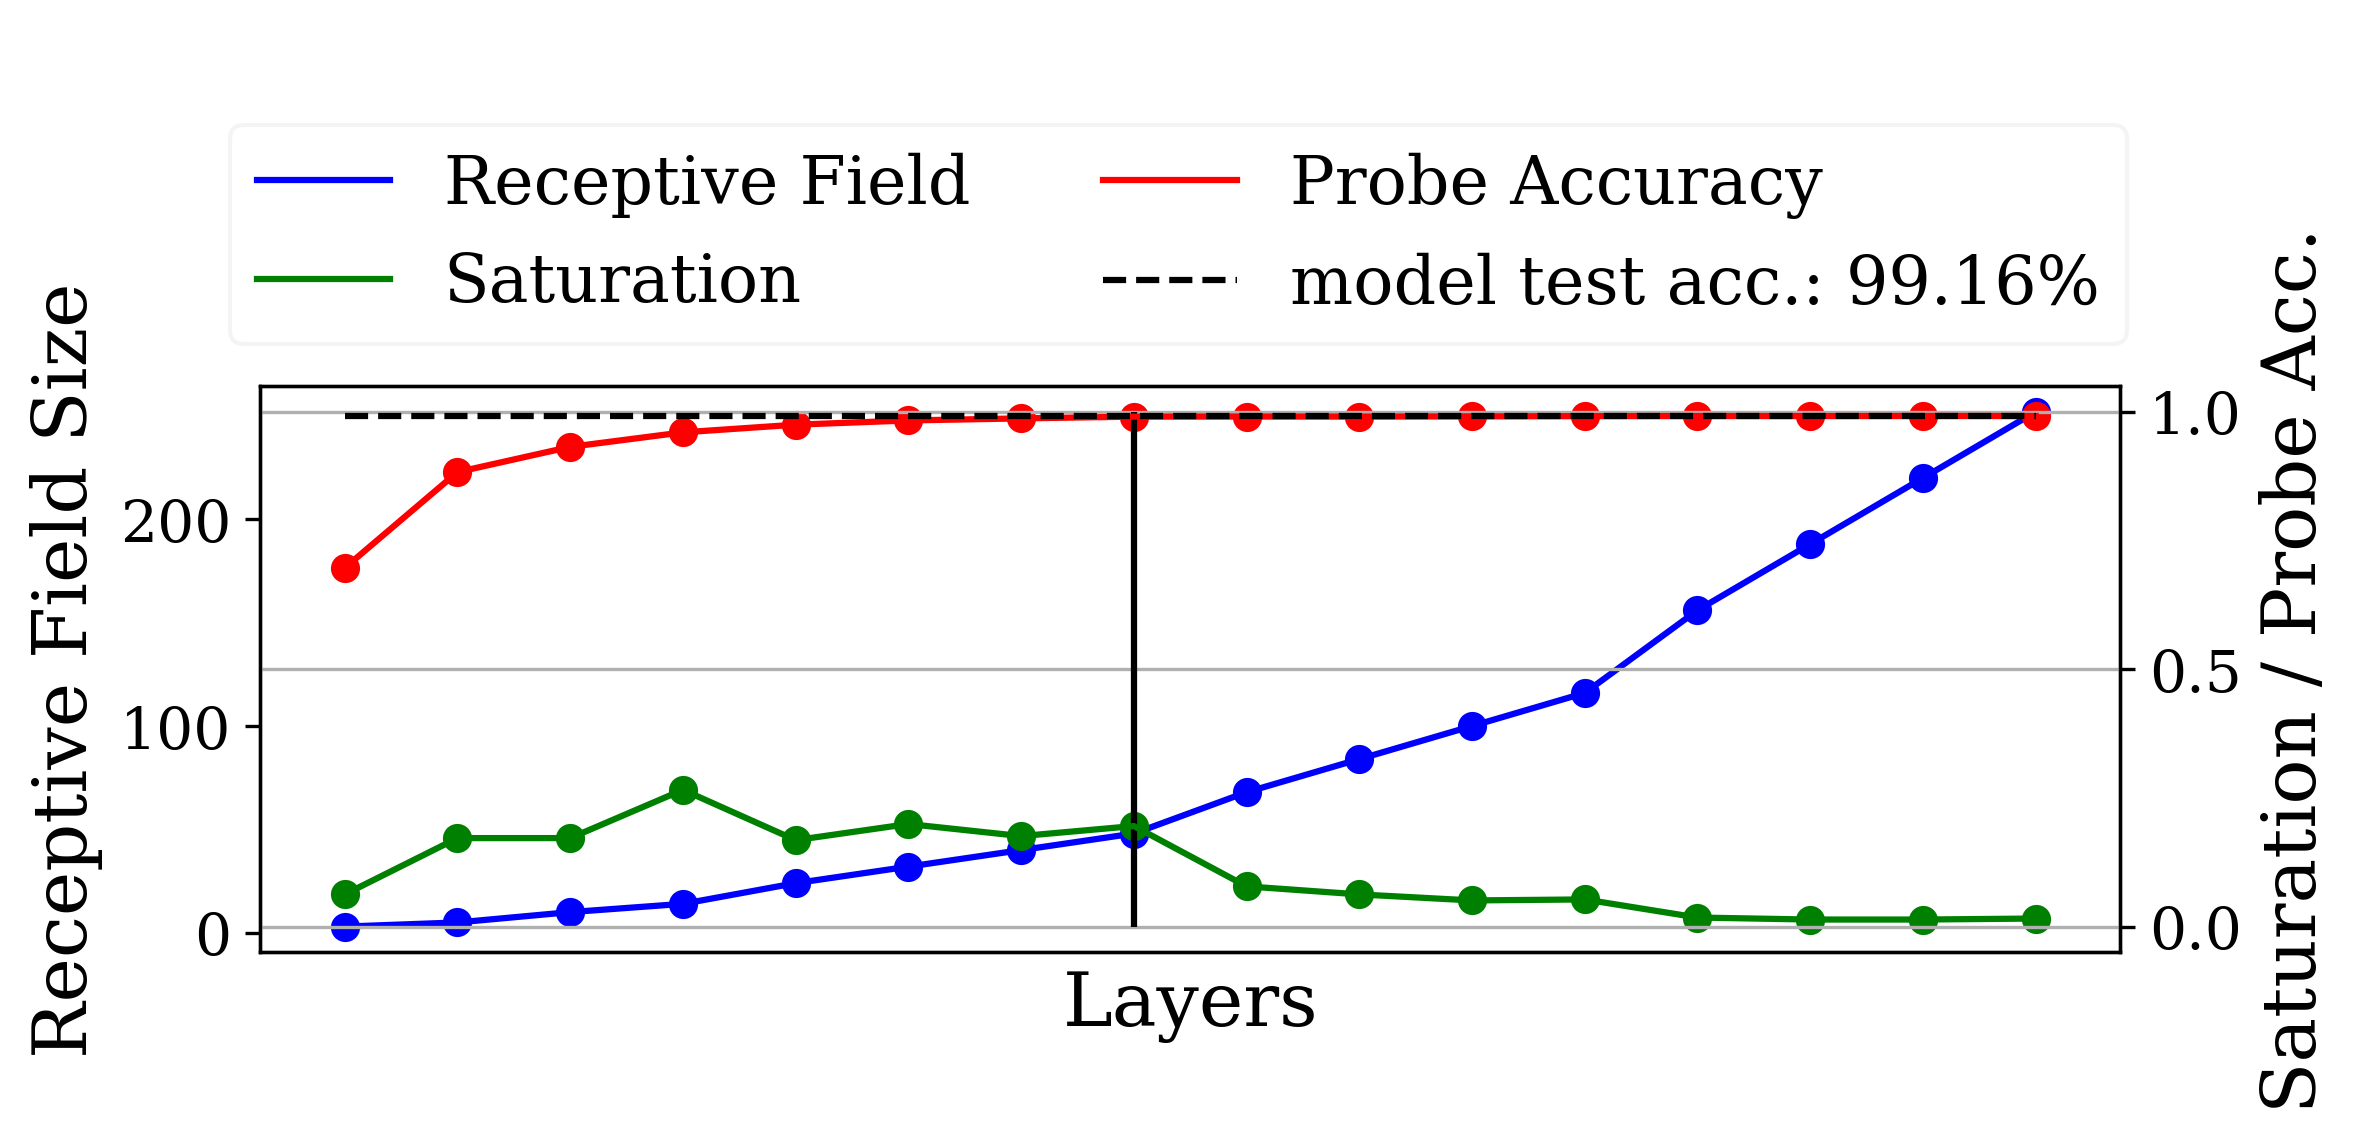

In [14]:
for model in ['VGG11', 'VGG13', 'VGG16', 'VGG19']:
    dataset = 'MNIST'
    input_res = 32
    batch_size = 64
    epochs = 30
    downsampling = 'None'
    thresh = 10000
    run_id = 'RES'

    plot_receptive_field(model, dataset, batch_size, epochs, downsampling, thresh, run_id, input_res)
    savepath = os.path.join(path,f'{model}_{dataset}_{input_res}.png')
    plt.savefig(savepath, bbox_inches='tight')